In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import torch.nn as nn
import os

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

# device = torch.device("cpu")
print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cpu


In [3]:
path_prefix = os.getcwd()

In [4]:
#here as argument to the method we give dx, dy sequentially
class LWCNMP(nn.Module):
    def __init__(self, in_shape):
        super(LWCNMP, self).__init__()
        
        d_x, d_y = in_shape[0], in_shape[1]
        
        self.encoder = nn.Sequential(
            nn.Linear(d_x+d_y, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256)
#             nn.ReLU(),
#             nn.Linear(256, 256)
        )
        
        self.query = nn.Sequential(
            nn.Linear(256+d_x, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, d_y*2*2)
        )

    def forward(self, observations, target):
        # 2 sets of observations are given
        # for each set, n < n_max observations are fed to an encoder
        r0 = self.encoder(observations[0]).to(torch.float32)
        r1 = self.encoder(observations[1]).to(torch.float32)
        
        r_avg0 = torch.mean(r0, dim=0)
        r_avg1 = torch.mean(r1, dim=0)
        w = torch.rand(1).to(device)
        r_avg = r_avg0 * w + r_avg1 * (1-w)
        
        r_avgs = r_avg.repeat(target.shape[0], 1).to(device)  # repeating the same r_avg for each target
        
        r_avg_target = torch.cat((r_avgs, target), 1)
        query_out = self.query(r_avg_target).to(torch.float32)
        
        return query_out
    
#     def forward_gen(self, observations, target):
#         r0 = self.encoder(observations[0])
#         r1 = self.encoder(observations[1])
        
#         r_avg0 = torch.mean(r0, dim=0)
#         r_avg1 = torch.mean(r1, dim=0)
#         w = torch.rand(1).to(device)
#         r_avg = r_avg0 * w + r_avg1 * (1-w)
        
#         r_avgs = r_avg.repeat(target.shape[0], 1).to(device)  # repeating the same r_avg for each target
        
#         r_avg_target = torch.cat((r_avgs, target), 1)
#         query_out = self.query(r_avg_target)
        
#         return query_out


def log_prob_loss(output, target):
    mean, sigma = output.chunk(2, dim = -1)
    sigma = F.softplus(sigma)
    dist = D.Independent(D.Normal(loc=mean, scale=sigma), 1)
    return -torch.mean(dist.log_prob(target))

def log_prob_loss_mul(output, target):
    m0, sig0, m1, sig1 = output.chunk(4, dim = -1)
    
    sig0, sig1 = F.softplus(sig0), F.softplus(sig1)
    dist0, dist1 = D.Independent(D.Normal(loc=m0, scale=sig0), 1), D.Independent(D.Normal(loc=m1, scale=sig1), 1)
    return max(-torch.mean(dist0.log_prob(target)), -torch.mean(dist1.log_prob(target)))

# def log_prob_loss_mvn(output, target):
#     m0, sig0, m1, sig1 = output.chunk(4, dim = -1)
#     sig0, sig1 = F.softplus(sig0), F.softplus(sig1)
#     cov = torch.tensor([sig0**2, sig1**2])
#     dist = D.multivariate_normal.MultivariateNormal(loc=torch.tensor([m0, m1]), covariance_matrix=torch.diag(cov))
#     return -torch.mean(dist.log_prob(target.repeat(1,2).view(2)))

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def plot(data):
    x = torch.linspace(0, 1, data.shape[1])
    for traj in data:
        plt.plot(x, traj)

def cx_sigm(n=10, t_max=200):
    # rand_btw_7-30 * {-1, 1}
    c1 = (torch.rand(n, 1) * 23 + 7) * torch.from_numpy(np.random.choice([-1, 1], (n, 1)))  # c1 for steepness
    t = torch.linspace(0, 1, t_max)
    c2 = 0.5  # c2 midpoint
    
    data = 1/(1 + torch.exp(-c1 * (t-c2)))
    return data

In [6]:
def interpolateJointData(trajectory, num_of_steps_expected):
    """
    new_trajectory = []
    l = len(trajectory)
    print(len(trajectory))
    size_to_add = num_of_steps_expected - l
    if size_to_add == 0:
        return trajectory
    mod = l % size_to_add
    jump_len =  (l - mod) // size_to_add
    
    for index in range(0, size_to_add):
        new_trajectory.extend(trajectory[index*jump_len: index*(jump_len+1)])
        new_trajectory.append([sum(x)/2 for x in zip(trajectory[index*(jump_len+1)], trajectory[index*(jump_len+1) + 1])])
    new_trajectory.extend(trajectory[-1] * mod)
    return new_trajectory
    """
    return np.append(trajectory, np.tile(trajectory[-1], ((num_of_steps_expected - len(trajectory)), 1)))

In [8]:
y_train= np.array([np.genfromtxt('./initial_data/salimdemet1_0.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet1_1.csv', delimiter=',')[1:,1:], 
             np.genfromtxt('./initial_data/salimdemet1_2.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet1_3.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./initial_data/salimdemet1_4.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet2_0.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./initial_data/salimdemet2_1.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet1_2.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./initial_data/salimdemet2_3.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet2_4.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./initial_data/salimdemet3_0.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet3_1.csv', delimiter=',')[1:,1:], 
             np.genfromtxt('./initial_data/salimdemet3_2.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet3_3.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./initial_data/salimdemet3_4.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet4_0.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./initial_data/salimdemet4_1.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet4_2.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./initial_data/salimdemet4_3.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet4_4.csv', delimiter=',')[1:,1:]], dtype=object)


y_val = np.array([np.genfromtxt('./initial_data/salimdemet5_0.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet5_1.csv', delimiter=',')[1:,1:], 
                np.genfromtxt('./initial_data/salimdemet5_2.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet5_3.csv', delimiter=',')[1:,1:],
                np.genfromtxt('./initial_data/salimdemet5_4.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet6_0.csv', delimiter=',')[1:,1:],
                np.genfromtxt('./initial_data/salimdemet6_1.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet6_2.csv', delimiter=',')[1:,1:],
                np.genfromtxt('./initial_data/salimdemet6_3.csv', delimiter=',')[1:,1:], np.genfromtxt('./initial_data/salimdemet6_4.csv', delimiter=',')[1:,1:]], dtype=object)

length1 = len(max(y_train, key=len))
length2 = len(max(y_val, key=len))
length = max([length1,length2])

time_array = np.linspace(0.5, 0.5 + (length-1)*0.01, length)

gamma = [[43.1,20.2, 0, 88.5, 21.1,0], [33.6,9.6, 0,88.5, 21.1,0], [33.3,32.0,0,88.5, 21.1,0], [54.9,32.5,0,88.5, 21.1,0], [55.3,9.2,0,88.5, 21.1,0], [66.2,22.4,0,88.5, 21.1,0]]

x_train = np.array([], dtype=np.float32) #TODO
for i in range(0,20): #gamma is a list type, not numpy array
    e = gamma[i//5]
    x_axis = np.array([np.array([t]+e, dtype=np.float32) for t in time_array], dtype=np.float32)
    x_train = np.append(x_train, x_axis)
    
    
x_val = np.array([])
for i in range(0,10): #gamma is a list type, not numpy array
    e = gamma[i//5]
    x_axis = np.array([np.array([t]+ e, dtype=np.float32) for t in time_array], dtype=np.float32)
    x_val = np.append(x_val, x_axis)


y_train = np.array([interpolateJointData(element, length) for element in y_train])
y_train = torch.from_numpy(y_train.reshape(20,length,16)).to(torch.float32)

x_val = torch.from_numpy(x_val.reshape(10,length,7)).to(torch.float32)
x_train = torch.from_numpy(x_train.reshape(20, length, 7)).to(torch.float32)

y_val = np.array([interpolateJointData(element, length) for element in y_val])
y_val = torch.from_numpy(y_val.reshape(10,length, 16)).to(torch.float32)





#y_test TODO: fill this
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

n = 20
t_max = x_train.shape[1]
d_x = 7
d_y = 16


plot(x_train.cpu())
plot(y_train.cpu())
plot(x_val.cpu())
plot(y_val.cpu())

ValueError: Some errors were detected !
    Line #3 (got 17 columns instead of 19)
    Line #4 (got 17 columns instead of 19)
    Line #5 (got 17 columns instead of 19)
    Line #6 (got 17 columns instead of 19)
    Line #7 (got 17 columns instead of 19)
    Line #8 (got 17 columns instead of 19)
    Line #9 (got 17 columns instead of 19)
    Line #10 (got 17 columns instead of 19)
    Line #11 (got 17 columns instead of 19)
    Line #12 (got 17 columns instead of 19)
    Line #13 (got 17 columns instead of 19)
    Line #14 (got 17 columns instead of 19)
    Line #15 (got 17 columns instead of 19)
    Line #16 (got 17 columns instead of 19)
    Line #17 (got 17 columns instead of 19)
    Line #18 (got 17 columns instead of 19)
    Line #19 (got 17 columns instead of 19)
    Line #20 (got 17 columns instead of 19)
    Line #21 (got 17 columns instead of 19)
    Line #22 (got 17 columns instead of 19)
    Line #23 (got 17 columns instead of 19)
    Line #24 (got 17 columns instead of 19)
    Line #25 (got 17 columns instead of 19)
    Line #26 (got 17 columns instead of 19)
    Line #27 (got 17 columns instead of 19)
    Line #28 (got 17 columns instead of 19)
    Line #29 (got 17 columns instead of 19)
    Line #30 (got 17 columns instead of 19)
    Line #31 (got 17 columns instead of 19)
    Line #32 (got 17 columns instead of 19)
    Line #33 (got 17 columns instead of 19)
    Line #34 (got 17 columns instead of 19)
    Line #35 (got 17 columns instead of 19)
    Line #36 (got 17 columns instead of 19)
    Line #37 (got 17 columns instead of 19)
    Line #38 (got 17 columns instead of 19)
    Line #39 (got 17 columns instead of 19)
    Line #40 (got 17 columns instead of 19)
    Line #41 (got 17 columns instead of 19)
    Line #42 (got 17 columns instead of 19)
    Line #43 (got 17 columns instead of 19)
    Line #44 (got 17 columns instead of 19)
    Line #45 (got 17 columns instead of 19)
    Line #46 (got 17 columns instead of 19)
    Line #47 (got 17 columns instead of 19)
    Line #48 (got 17 columns instead of 19)
    Line #49 (got 17 columns instead of 19)
    Line #50 (got 17 columns instead of 19)
    Line #51 (got 17 columns instead of 19)
    Line #52 (got 17 columns instead of 19)
    Line #53 (got 17 columns instead of 19)
    Line #54 (got 17 columns instead of 19)
    Line #55 (got 17 columns instead of 19)
    Line #56 (got 17 columns instead of 19)
    Line #57 (got 17 columns instead of 19)
    Line #58 (got 17 columns instead of 19)
    Line #59 (got 17 columns instead of 19)
    Line #60 (got 17 columns instead of 19)
    Line #61 (got 17 columns instead of 19)
    Line #62 (got 17 columns instead of 19)
    Line #63 (got 17 columns instead of 19)
    Line #64 (got 17 columns instead of 19)
    Line #65 (got 17 columns instead of 19)
    Line #66 (got 17 columns instead of 19)
    Line #67 (got 17 columns instead of 19)
    Line #68 (got 17 columns instead of 19)
    Line #69 (got 17 columns instead of 19)
    Line #70 (got 17 columns instead of 19)
    Line #71 (got 17 columns instead of 19)
    Line #72 (got 17 columns instead of 19)
    Line #73 (got 17 columns instead of 19)
    Line #74 (got 17 columns instead of 19)
    Line #75 (got 17 columns instead of 19)
    Line #76 (got 17 columns instead of 19)
    Line #77 (got 17 columns instead of 19)
    Line #78 (got 17 columns instead of 19)
    Line #79 (got 17 columns instead of 19)
    Line #80 (got 17 columns instead of 19)
    Line #81 (got 17 columns instead of 19)
    Line #82 (got 17 columns instead of 19)
    Line #83 (got 17 columns instead of 19)
    Line #84 (got 17 columns instead of 19)
    Line #85 (got 17 columns instead of 19)
    Line #86 (got 17 columns instead of 19)
    Line #87 (got 17 columns instead of 19)
    Line #88 (got 17 columns instead of 19)
    Line #89 (got 17 columns instead of 19)
    Line #90 (got 17 columns instead of 19)
    Line #91 (got 17 columns instead of 19)
    Line #92 (got 17 columns instead of 19)
    Line #93 (got 17 columns instead of 19)
    Line #94 (got 17 columns instead of 19)
    Line #95 (got 17 columns instead of 19)
    Line #96 (got 17 columns instead of 19)
    Line #97 (got 17 columns instead of 19)
    Line #98 (got 17 columns instead of 19)
    Line #99 (got 17 columns instead of 19)
    Line #100 (got 17 columns instead of 19)
    Line #101 (got 17 columns instead of 19)
    Line #102 (got 17 columns instead of 19)
    Line #103 (got 17 columns instead of 19)
    Line #104 (got 17 columns instead of 19)
    Line #105 (got 17 columns instead of 19)
    Line #106 (got 17 columns instead of 19)
    Line #107 (got 17 columns instead of 19)
    Line #108 (got 17 columns instead of 19)
    Line #109 (got 17 columns instead of 19)
    Line #110 (got 17 columns instead of 19)
    Line #111 (got 17 columns instead of 19)
    Line #112 (got 17 columns instead of 19)
    Line #113 (got 17 columns instead of 19)
    Line #114 (got 17 columns instead of 19)
    Line #115 (got 17 columns instead of 19)
    Line #116 (got 17 columns instead of 19)
    Line #117 (got 17 columns instead of 19)
    Line #118 (got 17 columns instead of 19)
    Line #119 (got 17 columns instead of 19)
    Line #120 (got 17 columns instead of 19)
    Line #121 (got 17 columns instead of 19)
    Line #122 (got 17 columns instead of 19)
    Line #123 (got 17 columns instead of 19)
    Line #124 (got 17 columns instead of 19)
    Line #125 (got 17 columns instead of 19)
    Line #126 (got 17 columns instead of 19)
    Line #127 (got 17 columns instead of 19)
    Line #128 (got 17 columns instead of 19)
    Line #129 (got 17 columns instead of 19)
    Line #130 (got 17 columns instead of 19)
    Line #131 (got 17 columns instead of 19)
    Line #132 (got 17 columns instead of 19)
    Line #133 (got 17 columns instead of 19)
    Line #134 (got 17 columns instead of 19)
    Line #135 (got 17 columns instead of 19)
    Line #136 (got 17 columns instead of 19)
    Line #137 (got 17 columns instead of 19)
    Line #138 (got 17 columns instead of 19)
    Line #139 (got 17 columns instead of 19)
    Line #140 (got 17 columns instead of 19)
    Line #141 (got 17 columns instead of 19)
    Line #142 (got 17 columns instead of 19)
    Line #143 (got 17 columns instead of 19)
    Line #144 (got 17 columns instead of 19)
    Line #145 (got 17 columns instead of 19)
    Line #146 (got 17 columns instead of 19)
    Line #147 (got 17 columns instead of 19)
    Line #148 (got 17 columns instead of 19)
    Line #149 (got 17 columns instead of 19)
    Line #150 (got 17 columns instead of 19)
    Line #151 (got 17 columns instead of 19)
    Line #152 (got 17 columns instead of 19)
    Line #153 (got 17 columns instead of 19)
    Line #154 (got 17 columns instead of 19)
    Line #155 (got 17 columns instead of 19)
    Line #156 (got 17 columns instead of 19)
    Line #157 (got 17 columns instead of 19)
    Line #158 (got 17 columns instead of 19)
    Line #159 (got 17 columns instead of 19)
    Line #160 (got 17 columns instead of 19)
    Line #161 (got 17 columns instead of 19)
    Line #162 (got 17 columns instead of 19)
    Line #163 (got 17 columns instead of 19)
    Line #164 (got 17 columns instead of 19)
    Line #165 (got 17 columns instead of 19)
    Line #166 (got 17 columns instead of 19)
    Line #167 (got 17 columns instead of 19)
    Line #168 (got 17 columns instead of 19)
    Line #169 (got 17 columns instead of 19)
    Line #170 (got 17 columns instead of 19)
    Line #171 (got 17 columns instead of 19)
    Line #172 (got 17 columns instead of 19)
    Line #173 (got 17 columns instead of 19)
    Line #174 (got 17 columns instead of 19)
    Line #175 (got 17 columns instead of 19)
    Line #176 (got 17 columns instead of 19)
    Line #177 (got 17 columns instead of 19)
    Line #178 (got 17 columns instead of 19)
    Line #179 (got 17 columns instead of 19)
    Line #180 (got 17 columns instead of 19)
    Line #181 (got 17 columns instead of 19)
    Line #182 (got 17 columns instead of 19)
    Line #183 (got 17 columns instead of 19)
    Line #184 (got 17 columns instead of 19)
    Line #185 (got 17 columns instead of 19)
    Line #186 (got 17 columns instead of 19)
    Line #187 (got 17 columns instead of 19)
    Line #188 (got 17 columns instead of 19)
    Line #189 (got 17 columns instead of 19)
    Line #190 (got 17 columns instead of 19)
    Line #191 (got 17 columns instead of 19)
    Line #192 (got 17 columns instead of 19)
    Line #193 (got 17 columns instead of 19)
    Line #194 (got 17 columns instead of 19)
    Line #195 (got 17 columns instead of 19)
    Line #196 (got 17 columns instead of 19)
    Line #197 (got 17 columns instead of 19)
    Line #198 (got 17 columns instead of 19)
    Line #199 (got 17 columns instead of 19)
    Line #200 (got 17 columns instead of 19)
    Line #201 (got 17 columns instead of 19)
    Line #202 (got 17 columns instead of 19)
    Line #203 (got 17 columns instead of 19)
    Line #204 (got 17 columns instead of 19)
    Line #205 (got 17 columns instead of 19)
    Line #206 (got 17 columns instead of 19)
    Line #207 (got 17 columns instead of 19)
    Line #208 (got 17 columns instead of 19)
    Line #209 (got 17 columns instead of 19)
    Line #210 (got 17 columns instead of 19)
    Line #211 (got 17 columns instead of 19)
    Line #212 (got 17 columns instead of 19)
    Line #213 (got 17 columns instead of 19)
    Line #214 (got 17 columns instead of 19)
    Line #215 (got 17 columns instead of 19)
    Line #216 (got 17 columns instead of 19)
    Line #217 (got 17 columns instead of 19)
    Line #218 (got 17 columns instead of 19)
    Line #219 (got 17 columns instead of 19)
    Line #220 (got 17 columns instead of 19)
    Line #221 (got 17 columns instead of 19)
    Line #222 (got 17 columns instead of 19)
    Line #223 (got 17 columns instead of 19)
    Line #224 (got 17 columns instead of 19)
    Line #225 (got 17 columns instead of 19)
    Line #226 (got 17 columns instead of 19)
    Line #227 (got 17 columns instead of 19)
    Line #228 (got 17 columns instead of 19)
    Line #229 (got 17 columns instead of 19)
    Line #230 (got 17 columns instead of 19)
    Line #231 (got 17 columns instead of 19)
    Line #232 (got 17 columns instead of 19)
    Line #233 (got 17 columns instead of 19)
    Line #234 (got 17 columns instead of 19)
    Line #235 (got 17 columns instead of 19)
    Line #236 (got 17 columns instead of 19)
    Line #237 (got 17 columns instead of 19)
    Line #238 (got 17 columns instead of 19)
    Line #239 (got 17 columns instead of 19)
    Line #240 (got 17 columns instead of 19)
    Line #241 (got 17 columns instead of 19)
    Line #242 (got 17 columns instead of 19)
    Line #243 (got 17 columns instead of 19)
    Line #244 (got 17 columns instead of 19)
    Line #245 (got 17 columns instead of 19)
    Line #246 (got 17 columns instead of 19)
    Line #247 (got 17 columns instead of 19)
    Line #248 (got 17 columns instead of 19)
    Line #249 (got 17 columns instead of 19)
    Line #250 (got 17 columns instead of 19)
    Line #251 (got 17 columns instead of 19)
    Line #252 (got 17 columns instead of 19)
    Line #253 (got 17 columns instead of 19)
    Line #254 (got 17 columns instead of 19)
    Line #255 (got 17 columns instead of 19)
    Line #256 (got 17 columns instead of 19)
    Line #257 (got 17 columns instead of 19)
    Line #258 (got 17 columns instead of 19)
    Line #259 (got 17 columns instead of 19)
    Line #260 (got 17 columns instead of 19)
    Line #261 (got 17 columns instead of 19)
    Line #262 (got 17 columns instead of 19)
    Line #263 (got 17 columns instead of 19)
    Line #264 (got 17 columns instead of 19)
    Line #265 (got 17 columns instead of 19)
    Line #266 (got 17 columns instead of 19)
    Line #267 (got 17 columns instead of 19)
    Line #268 (got 17 columns instead of 19)
    Line #269 (got 17 columns instead of 19)
    Line #270 (got 17 columns instead of 19)
    Line #271 (got 17 columns instead of 19)
    Line #272 (got 17 columns instead of 19)
    Line #273 (got 17 columns instead of 19)
    Line #274 (got 17 columns instead of 19)
    Line #275 (got 17 columns instead of 19)
    Line #276 (got 17 columns instead of 19)
    Line #277 (got 17 columns instead of 19)
    Line #278 (got 17 columns instead of 19)
    Line #279 (got 17 columns instead of 19)
    Line #280 (got 17 columns instead of 19)
    Line #281 (got 17 columns instead of 19)
    Line #282 (got 17 columns instead of 19)
    Line #283 (got 17 columns instead of 19)
    Line #284 (got 17 columns instead of 19)
    Line #285 (got 17 columns instead of 19)
    Line #286 (got 17 columns instead of 19)
    Line #287 (got 17 columns instead of 19)
    Line #288 (got 17 columns instead of 19)
    Line #289 (got 17 columns instead of 19)
    Line #290 (got 17 columns instead of 19)
    Line #291 (got 17 columns instead of 19)
    Line #292 (got 17 columns instead of 19)
    Line #293 (got 17 columns instead of 19)
    Line #294 (got 17 columns instead of 19)
    Line #295 (got 17 columns instead of 19)
    Line #296 (got 17 columns instead of 19)
    Line #297 (got 17 columns instead of 19)
    Line #298 (got 17 columns instead of 19)
    Line #299 (got 17 columns instead of 19)
    Line #300 (got 17 columns instead of 19)
    Line #301 (got 17 columns instead of 19)
    Line #302 (got 17 columns instead of 19)
    Line #303 (got 17 columns instead of 19)
    Line #304 (got 17 columns instead of 19)
    Line #305 (got 17 columns instead of 19)
    Line #306 (got 17 columns instead of 19)
    Line #307 (got 17 columns instead of 19)
    Line #308 (got 17 columns instead of 19)
    Line #309 (got 17 columns instead of 19)
    Line #310 (got 17 columns instead of 19)
    Line #311 (got 17 columns instead of 19)
    Line #312 (got 17 columns instead of 19)
    Line #313 (got 17 columns instead of 19)
    Line #314 (got 17 columns instead of 19)
    Line #315 (got 17 columns instead of 19)
    Line #316 (got 17 columns instead of 19)
    Line #317 (got 17 columns instead of 19)
    Line #318 (got 17 columns instead of 19)
    Line #319 (got 17 columns instead of 19)
    Line #320 (got 17 columns instead of 19)
    Line #321 (got 17 columns instead of 19)
    Line #322 (got 17 columns instead of 19)
    Line #323 (got 17 columns instead of 19)
    Line #324 (got 17 columns instead of 19)
    Line #325 (got 17 columns instead of 19)
    Line #326 (got 17 columns instead of 19)
    Line #327 (got 17 columns instead of 19)
    Line #328 (got 17 columns instead of 19)
    Line #329 (got 17 columns instead of 19)
    Line #330 (got 17 columns instead of 19)
    Line #331 (got 17 columns instead of 19)
    Line #332 (got 17 columns instead of 19)
    Line #333 (got 17 columns instead of 19)
    Line #334 (got 17 columns instead of 19)
    Line #335 (got 17 columns instead of 19)
    Line #336 (got 17 columns instead of 19)
    Line #337 (got 17 columns instead of 19)
    Line #338 (got 17 columns instead of 19)
    Line #339 (got 17 columns instead of 19)
    Line #340 (got 17 columns instead of 19)
    Line #341 (got 17 columns instead of 19)
    Line #342 (got 17 columns instead of 19)
    Line #343 (got 17 columns instead of 19)
    Line #344 (got 17 columns instead of 19)
    Line #345 (got 17 columns instead of 19)
    Line #346 (got 17 columns instead of 19)
    Line #347 (got 17 columns instead of 19)
    Line #348 (got 17 columns instead of 19)
    Line #349 (got 17 columns instead of 19)
    Line #350 (got 17 columns instead of 19)
    Line #351 (got 17 columns instead of 19)
    Line #352 (got 17 columns instead of 19)
    Line #353 (got 17 columns instead of 19)
    Line #354 (got 17 columns instead of 19)
    Line #355 (got 17 columns instead of 19)
    Line #356 (got 17 columns instead of 19)
    Line #357 (got 17 columns instead of 19)
    Line #358 (got 17 columns instead of 19)
    Line #359 (got 17 columns instead of 19)
    Line #360 (got 17 columns instead of 19)
    Line #361 (got 17 columns instead of 19)
    Line #362 (got 17 columns instead of 19)
    Line #363 (got 17 columns instead of 19)
    Line #364 (got 17 columns instead of 19)
    Line #365 (got 17 columns instead of 19)
    Line #366 (got 17 columns instead of 19)
    Line #367 (got 17 columns instead of 19)
    Line #368 (got 17 columns instead of 19)
    Line #369 (got 17 columns instead of 19)
    Line #370 (got 17 columns instead of 19)
    Line #371 (got 17 columns instead of 19)
    Line #372 (got 17 columns instead of 19)
    Line #373 (got 17 columns instead of 19)
    Line #374 (got 17 columns instead of 19)
    Line #375 (got 17 columns instead of 19)
    Line #376 (got 17 columns instead of 19)
    Line #377 (got 17 columns instead of 19)
    Line #378 (got 17 columns instead of 19)
    Line #379 (got 17 columns instead of 19)
    Line #380 (got 17 columns instead of 19)
    Line #381 (got 17 columns instead of 19)
    Line #382 (got 17 columns instead of 19)
    Line #383 (got 17 columns instead of 19)
    Line #384 (got 17 columns instead of 19)
    Line #385 (got 17 columns instead of 19)
    Line #386 (got 17 columns instead of 19)
    Line #387 (got 17 columns instead of 19)
    Line #388 (got 17 columns instead of 19)
    Line #389 (got 17 columns instead of 19)
    Line #390 (got 17 columns instead of 19)
    Line #391 (got 17 columns instead of 19)
    Line #392 (got 17 columns instead of 19)
    Line #393 (got 17 columns instead of 19)
    Line #394 (got 17 columns instead of 19)
    Line #395 (got 17 columns instead of 19)
    Line #396 (got 17 columns instead of 19)
    Line #397 (got 17 columns instead of 19)
    Line #398 (got 17 columns instead of 19)
    Line #399 (got 17 columns instead of 19)
    Line #400 (got 17 columns instead of 19)
    Line #401 (got 17 columns instead of 19)
    Line #402 (got 17 columns instead of 19)
    Line #403 (got 17 columns instead of 19)
    Line #404 (got 17 columns instead of 19)
    Line #405 (got 17 columns instead of 19)
    Line #406 (got 17 columns instead of 19)
    Line #407 (got 17 columns instead of 19)
    Line #408 (got 17 columns instead of 19)
    Line #409 (got 17 columns instead of 19)
    Line #410 (got 17 columns instead of 19)
    Line #411 (got 17 columns instead of 19)
    Line #412 (got 17 columns instead of 19)
    Line #413 (got 17 columns instead of 19)
    Line #414 (got 17 columns instead of 19)
    Line #415 (got 17 columns instead of 19)
    Line #416 (got 17 columns instead of 19)
    Line #417 (got 17 columns instead of 19)
    Line #418 (got 17 columns instead of 19)
    Line #419 (got 17 columns instead of 19)
    Line #420 (got 17 columns instead of 19)
    Line #421 (got 17 columns instead of 19)
    Line #422 (got 17 columns instead of 19)
    Line #423 (got 17 columns instead of 19)
    Line #424 (got 17 columns instead of 19)
    Line #425 (got 17 columns instead of 19)
    Line #426 (got 17 columns instead of 19)
    Line #427 (got 17 columns instead of 19)
    Line #428 (got 17 columns instead of 19)
    Line #429 (got 17 columns instead of 19)
    Line #430 (got 17 columns instead of 19)
    Line #431 (got 17 columns instead of 19)
    Line #432 (got 17 columns instead of 19)
    Line #433 (got 17 columns instead of 19)
    Line #434 (got 17 columns instead of 19)
    Line #435 (got 17 columns instead of 19)
    Line #436 (got 17 columns instead of 19)
    Line #437 (got 17 columns instead of 19)
    Line #438 (got 17 columns instead of 19)
    Line #439 (got 17 columns instead of 19)
    Line #440 (got 17 columns instead of 19)
    Line #441 (got 17 columns instead of 19)
    Line #442 (got 17 columns instead of 19)
    Line #443 (got 17 columns instead of 19)
    Line #444 (got 17 columns instead of 19)
    Line #445 (got 17 columns instead of 19)
    Line #446 (got 17 columns instead of 19)
    Line #447 (got 17 columns instead of 19)
    Line #448 (got 17 columns instead of 19)
    Line #449 (got 17 columns instead of 19)
    Line #450 (got 17 columns instead of 19)
    Line #451 (got 17 columns instead of 19)
    Line #452 (got 17 columns instead of 19)
    Line #453 (got 17 columns instead of 19)
    Line #454 (got 17 columns instead of 19)
    Line #455 (got 17 columns instead of 19)
    Line #456 (got 17 columns instead of 19)
    Line #457 (got 17 columns instead of 19)
    Line #458 (got 17 columns instead of 19)
    Line #459 (got 17 columns instead of 19)
    Line #460 (got 17 columns instead of 19)
    Line #461 (got 17 columns instead of 19)
    Line #462 (got 17 columns instead of 19)
    Line #463 (got 17 columns instead of 19)
    Line #464 (got 17 columns instead of 19)
    Line #465 (got 17 columns instead of 19)
    Line #466 (got 17 columns instead of 19)
    Line #467 (got 17 columns instead of 19)
    Line #468 (got 17 columns instead of 19)
    Line #469 (got 17 columns instead of 19)
    Line #470 (got 17 columns instead of 19)
    Line #471 (got 17 columns instead of 19)
    Line #472 (got 17 columns instead of 19)
    Line #473 (got 17 columns instead of 19)
    Line #474 (got 17 columns instead of 19)
    Line #475 (got 17 columns instead of 19)
    Line #476 (got 17 columns instead of 19)
    Line #477 (got 17 columns instead of 19)
    Line #478 (got 17 columns instead of 19)
    Line #479 (got 17 columns instead of 19)
    Line #480 (got 17 columns instead of 19)
    Line #481 (got 17 columns instead of 19)
    Line #482 (got 17 columns instead of 19)
    Line #483 (got 17 columns instead of 19)
    Line #484 (got 17 columns instead of 19)
    Line #485 (got 17 columns instead of 19)
    Line #486 (got 17 columns instead of 19)
    Line #487 (got 17 columns instead of 19)
    Line #488 (got 17 columns instead of 19)
    Line #489 (got 17 columns instead of 19)
    Line #490 (got 17 columns instead of 19)
    Line #491 (got 17 columns instead of 19)
    Line #492 (got 17 columns instead of 19)
    Line #493 (got 17 columns instead of 19)
    Line #494 (got 17 columns instead of 19)
    Line #495 (got 17 columns instead of 19)
    Line #496 (got 17 columns instead of 19)
    Line #497 (got 17 columns instead of 19)
    Line #498 (got 17 columns instead of 19)
    Line #499 (got 17 columns instead of 19)
    Line #500 (got 17 columns instead of 19)
    Line #501 (got 17 columns instead of 19)
    Line #502 (got 17 columns instead of 19)
    Line #503 (got 17 columns instead of 19)
    Line #504 (got 17 columns instead of 19)
    Line #505 (got 17 columns instead of 19)
    Line #506 (got 17 columns instead of 19)
    Line #507 (got 17 columns instead of 19)
    Line #508 (got 17 columns instead of 19)
    Line #509 (got 17 columns instead of 19)
    Line #510 (got 17 columns instead of 19)
    Line #511 (got 17 columns instead of 19)
    Line #512 (got 17 columns instead of 19)
    Line #513 (got 17 columns instead of 19)
    Line #514 (got 17 columns instead of 19)
    Line #515 (got 17 columns instead of 19)
    Line #516 (got 17 columns instead of 19)
    Line #517 (got 17 columns instead of 19)
    Line #518 (got 17 columns instead of 19)
    Line #519 (got 17 columns instead of 19)
    Line #520 (got 17 columns instead of 19)
    Line #521 (got 17 columns instead of 19)
    Line #522 (got 17 columns instead of 19)
    Line #523 (got 17 columns instead of 19)
    Line #524 (got 17 columns instead of 19)
    Line #525 (got 17 columns instead of 19)
    Line #526 (got 17 columns instead of 19)
    Line #527 (got 17 columns instead of 19)
    Line #528 (got 17 columns instead of 19)
    Line #529 (got 17 columns instead of 19)
    Line #530 (got 17 columns instead of 19)
    Line #531 (got 17 columns instead of 19)
    Line #532 (got 17 columns instead of 19)
    Line #533 (got 17 columns instead of 19)
    Line #534 (got 17 columns instead of 19)
    Line #535 (got 17 columns instead of 19)
    Line #536 (got 17 columns instead of 19)
    Line #537 (got 17 columns instead of 19)
    Line #538 (got 17 columns instead of 19)
    Line #539 (got 17 columns instead of 19)
    Line #540 (got 17 columns instead of 19)
    Line #541 (got 17 columns instead of 19)
    Line #542 (got 17 columns instead of 19)
    Line #543 (got 17 columns instead of 19)
    Line #544 (got 17 columns instead of 19)
    Line #545 (got 17 columns instead of 19)
    Line #546 (got 17 columns instead of 19)
    Line #547 (got 17 columns instead of 19)
    Line #548 (got 17 columns instead of 19)
    Line #549 (got 17 columns instead of 19)
    Line #550 (got 17 columns instead of 19)
    Line #551 (got 17 columns instead of 19)
    Line #552 (got 17 columns instead of 19)
    Line #553 (got 17 columns instead of 19)
    Line #554 (got 17 columns instead of 19)
    Line #555 (got 17 columns instead of 19)
    Line #556 (got 17 columns instead of 19)
    Line #557 (got 17 columns instead of 19)
    Line #558 (got 17 columns instead of 19)
    Line #559 (got 17 columns instead of 19)
    Line #560 (got 17 columns instead of 19)
    Line #561 (got 17 columns instead of 19)
    Line #562 (got 17 columns instead of 19)
    Line #563 (got 17 columns instead of 19)
    Line #564 (got 17 columns instead of 19)
    Line #565 (got 17 columns instead of 19)
    Line #566 (got 17 columns instead of 19)
    Line #567 (got 17 columns instead of 19)
    Line #568 (got 17 columns instead of 19)
    Line #569 (got 17 columns instead of 19)
    Line #570 (got 17 columns instead of 19)
    Line #571 (got 17 columns instead of 19)
    Line #572 (got 17 columns instead of 19)
    Line #573 (got 17 columns instead of 19)
    Line #574 (got 17 columns instead of 19)
    Line #575 (got 17 columns instead of 19)
    Line #576 (got 17 columns instead of 19)
    Line #577 (got 17 columns instead of 19)
    Line #578 (got 17 columns instead of 19)
    Line #579 (got 17 columns instead of 19)
    Line #580 (got 17 columns instead of 19)
    Line #581 (got 17 columns instead of 19)
    Line #582 (got 17 columns instead of 19)
    Line #583 (got 17 columns instead of 19)
    Line #584 (got 17 columns instead of 19)
    Line #585 (got 17 columns instead of 19)
    Line #586 (got 17 columns instead of 19)
    Line #587 (got 17 columns instead of 19)
    Line #588 (got 17 columns instead of 19)
    Line #589 (got 17 columns instead of 19)
    Line #590 (got 17 columns instead of 19)
    Line #591 (got 17 columns instead of 19)
    Line #592 (got 17 columns instead of 19)
    Line #593 (got 17 columns instead of 19)
    Line #594 (got 17 columns instead of 19)
    Line #595 (got 17 columns instead of 19)
    Line #596 (got 17 columns instead of 19)
    Line #597 (got 17 columns instead of 19)
    Line #598 (got 17 columns instead of 19)
    Line #599 (got 17 columns instead of 19)
    Line #600 (got 17 columns instead of 19)
    Line #601 (got 17 columns instead of 19)
    Line #602 (got 17 columns instead of 19)
    Line #603 (got 17 columns instead of 19)
    Line #604 (got 17 columns instead of 19)
    Line #605 (got 17 columns instead of 19)
    Line #606 (got 17 columns instead of 19)
    Line #607 (got 17 columns instead of 19)
    Line #608 (got 17 columns instead of 19)
    Line #609 (got 17 columns instead of 19)
    Line #610 (got 17 columns instead of 19)
    Line #611 (got 17 columns instead of 19)
    Line #612 (got 17 columns instead of 19)
    Line #613 (got 17 columns instead of 19)
    Line #614 (got 17 columns instead of 19)
    Line #615 (got 17 columns instead of 19)
    Line #616 (got 17 columns instead of 19)
    Line #617 (got 17 columns instead of 19)
    Line #618 (got 17 columns instead of 19)
    Line #619 (got 17 columns instead of 19)
    Line #620 (got 17 columns instead of 19)
    Line #621 (got 17 columns instead of 19)
    Line #622 (got 17 columns instead of 19)
    Line #623 (got 17 columns instead of 19)
    Line #624 (got 17 columns instead of 19)
    Line #625 (got 17 columns instead of 19)
    Line #626 (got 17 columns instead of 19)
    Line #627 (got 17 columns instead of 19)
    Line #628 (got 17 columns instead of 19)
    Line #629 (got 17 columns instead of 19)
    Line #630 (got 17 columns instead of 19)
    Line #631 (got 17 columns instead of 19)
    Line #632 (got 17 columns instead of 19)
    Line #633 (got 17 columns instead of 19)
    Line #634 (got 17 columns instead of 19)
    Line #635 (got 17 columns instead of 19)
    Line #636 (got 17 columns instead of 19)
    Line #637 (got 17 columns instead of 19)
    Line #638 (got 17 columns instead of 19)
    Line #639 (got 17 columns instead of 19)
    Line #640 (got 17 columns instead of 19)
    Line #641 (got 17 columns instead of 19)
    Line #642 (got 17 columns instead of 19)
    Line #643 (got 17 columns instead of 19)
    Line #644 (got 17 columns instead of 19)
    Line #645 (got 17 columns instead of 19)
    Line #646 (got 17 columns instead of 19)
    Line #647 (got 17 columns instead of 19)
    Line #648 (got 17 columns instead of 19)
    Line #649 (got 17 columns instead of 19)
    Line #650 (got 17 columns instead of 19)
    Line #651 (got 17 columns instead of 19)
    Line #652 (got 17 columns instead of 19)
    Line #653 (got 17 columns instead of 19)
    Line #654 (got 17 columns instead of 19)
    Line #655 (got 17 columns instead of 19)
    Line #656 (got 17 columns instead of 19)
    Line #657 (got 17 columns instead of 19)
    Line #658 (got 17 columns instead of 19)
    Line #659 (got 17 columns instead of 19)
    Line #660 (got 17 columns instead of 19)
    Line #661 (got 17 columns instead of 19)
    Line #662 (got 17 columns instead of 19)
    Line #663 (got 17 columns instead of 19)
    Line #664 (got 17 columns instead of 19)
    Line #665 (got 17 columns instead of 19)
    Line #666 (got 17 columns instead of 19)
    Line #667 (got 17 columns instead of 19)
    Line #668 (got 17 columns instead of 19)
    Line #669 (got 17 columns instead of 19)
    Line #670 (got 17 columns instead of 19)
    Line #671 (got 17 columns instead of 19)
    Line #672 (got 17 columns instead of 19)
    Line #673 (got 17 columns instead of 19)
    Line #674 (got 17 columns instead of 19)
    Line #675 (got 17 columns instead of 19)
    Line #676 (got 17 columns instead of 19)
    Line #677 (got 17 columns instead of 19)
    Line #678 (got 17 columns instead of 19)
    Line #679 (got 17 columns instead of 19)
    Line #680 (got 17 columns instead of 19)
    Line #681 (got 17 columns instead of 19)
    Line #682 (got 17 columns instead of 19)
    Line #683 (got 17 columns instead of 19)
    Line #684 (got 17 columns instead of 19)
    Line #685 (got 17 columns instead of 19)
    Line #686 (got 17 columns instead of 19)
    Line #687 (got 17 columns instead of 19)
    Line #688 (got 17 columns instead of 19)
    Line #689 (got 17 columns instead of 19)
    Line #690 (got 17 columns instead of 19)
    Line #691 (got 17 columns instead of 19)
    Line #692 (got 17 columns instead of 19)
    Line #693 (got 17 columns instead of 19)
    Line #694 (got 17 columns instead of 19)
    Line #695 (got 17 columns instead of 19)
    Line #696 (got 17 columns instead of 19)
    Line #697 (got 17 columns instead of 19)
    Line #698 (got 17 columns instead of 19)
    Line #699 (got 17 columns instead of 19)
    Line #700 (got 17 columns instead of 19)
    Line #701 (got 17 columns instead of 19)
    Line #702 (got 17 columns instead of 19)
    Line #703 (got 17 columns instead of 19)
    Line #704 (got 17 columns instead of 19)
    Line #705 (got 17 columns instead of 19)
    Line #706 (got 17 columns instead of 19)
    Line #707 (got 17 columns instead of 19)
    Line #708 (got 17 columns instead of 19)
    Line #709 (got 17 columns instead of 19)
    Line #710 (got 17 columns instead of 19)
    Line #711 (got 17 columns instead of 19)
    Line #712 (got 17 columns instead of 19)
    Line #713 (got 17 columns instead of 19)
    Line #714 (got 17 columns instead of 19)
    Line #715 (got 17 columns instead of 19)
    Line #716 (got 17 columns instead of 19)
    Line #717 (got 17 columns instead of 19)
    Line #718 (got 17 columns instead of 19)
    Line #719 (got 17 columns instead of 19)
    Line #720 (got 17 columns instead of 19)
    Line #721 (got 17 columns instead of 19)
    Line #722 (got 17 columns instead of 19)
    Line #723 (got 17 columns instead of 19)
    Line #724 (got 17 columns instead of 19)
    Line #725 (got 17 columns instead of 19)
    Line #726 (got 17 columns instead of 19)
    Line #727 (got 17 columns instead of 19)
    Line #728 (got 17 columns instead of 19)
    Line #729 (got 17 columns instead of 19)
    Line #730 (got 17 columns instead of 19)
    Line #731 (got 17 columns instead of 19)
    Line #732 (got 17 columns instead of 19)
    Line #733 (got 17 columns instead of 19)
    Line #734 (got 17 columns instead of 19)
    Line #735 (got 17 columns instead of 19)
    Line #736 (got 17 columns instead of 19)
    Line #737 (got 17 columns instead of 19)
    Line #738 (got 17 columns instead of 19)
    Line #739 (got 17 columns instead of 19)
    Line #740 (got 17 columns instead of 19)
    Line #741 (got 17 columns instead of 19)
    Line #742 (got 17 columns instead of 19)
    Line #743 (got 17 columns instead of 19)
    Line #744 (got 17 columns instead of 19)
    Line #745 (got 17 columns instead of 19)
    Line #746 (got 17 columns instead of 19)
    Line #747 (got 17 columns instead of 19)
    Line #748 (got 17 columns instead of 19)
    Line #749 (got 17 columns instead of 19)
    Line #750 (got 17 columns instead of 19)
    Line #751 (got 17 columns instead of 19)
    Line #752 (got 17 columns instead of 19)
    Line #753 (got 17 columns instead of 19)
    Line #754 (got 17 columns instead of 19)
    Line #755 (got 17 columns instead of 19)
    Line #756 (got 17 columns instead of 19)
    Line #757 (got 17 columns instead of 19)
    Line #758 (got 17 columns instead of 19)
    Line #759 (got 17 columns instead of 19)
    Line #760 (got 17 columns instead of 19)
    Line #761 (got 17 columns instead of 19)
    Line #762 (got 17 columns instead of 19)
    Line #763 (got 17 columns instead of 19)
    Line #764 (got 17 columns instead of 19)
    Line #765 (got 17 columns instead of 19)
    Line #766 (got 17 columns instead of 19)
    Line #767 (got 17 columns instead of 19)
    Line #768 (got 17 columns instead of 19)
    Line #769 (got 17 columns instead of 19)
    Line #770 (got 17 columns instead of 19)
    Line #771 (got 17 columns instead of 19)
    Line #772 (got 17 columns instead of 19)
    Line #773 (got 17 columns instead of 19)
    Line #774 (got 17 columns instead of 19)
    Line #775 (got 17 columns instead of 19)
    Line #776 (got 17 columns instead of 19)
    Line #777 (got 17 columns instead of 19)
    Line #778 (got 17 columns instead of 19)
    Line #779 (got 17 columns instead of 19)
    Line #780 (got 17 columns instead of 19)
    Line #781 (got 17 columns instead of 19)
    Line #782 (got 17 columns instead of 19)
    Line #783 (got 17 columns instead of 19)
    Line #784 (got 17 columns instead of 19)
    Line #785 (got 17 columns instead of 19)
    Line #786 (got 17 columns instead of 19)
    Line #787 (got 17 columns instead of 19)
    Line #788 (got 17 columns instead of 19)
    Line #789 (got 17 columns instead of 19)
    Line #790 (got 17 columns instead of 19)
    Line #791 (got 17 columns instead of 19)
    Line #792 (got 17 columns instead of 19)
    Line #793 (got 17 columns instead of 19)
    Line #794 (got 17 columns instead of 19)
    Line #795 (got 17 columns instead of 19)
    Line #796 (got 17 columns instead of 19)
    Line #797 (got 17 columns instead of 19)
    Line #798 (got 17 columns instead of 19)
    Line #799 (got 17 columns instead of 19)
    Line #800 (got 17 columns instead of 19)
    Line #801 (got 17 columns instead of 19)
    Line #802 (got 17 columns instead of 19)
    Line #803 (got 17 columns instead of 19)
    Line #804 (got 17 columns instead of 19)
    Line #805 (got 17 columns instead of 19)
    Line #806 (got 17 columns instead of 19)
    Line #807 (got 17 columns instead of 19)
    Line #808 (got 17 columns instead of 19)
    Line #809 (got 17 columns instead of 19)
    Line #810 (got 17 columns instead of 19)
    Line #811 (got 17 columns instead of 19)
    Line #812 (got 17 columns instead of 19)
    Line #813 (got 17 columns instead of 19)
    Line #814 (got 17 columns instead of 19)
    Line #815 (got 17 columns instead of 19)
    Line #816 (got 17 columns instead of 19)
    Line #817 (got 17 columns instead of 19)
    Line #818 (got 17 columns instead of 19)
    Line #819 (got 17 columns instead of 19)
    Line #820 (got 17 columns instead of 19)
    Line #821 (got 17 columns instead of 19)
    Line #822 (got 17 columns instead of 19)
    Line #823 (got 17 columns instead of 19)
    Line #824 (got 17 columns instead of 19)
    Line #825 (got 17 columns instead of 19)
    Line #826 (got 17 columns instead of 19)
    Line #827 (got 17 columns instead of 19)
    Line #828 (got 17 columns instead of 19)
    Line #829 (got 17 columns instead of 19)
    Line #830 (got 17 columns instead of 19)
    Line #831 (got 17 columns instead of 19)
    Line #832 (got 17 columns instead of 19)
    Line #833 (got 17 columns instead of 19)
    Line #834 (got 17 columns instead of 19)
    Line #835 (got 17 columns instead of 19)
    Line #836 (got 17 columns instead of 19)
    Line #837 (got 17 columns instead of 19)
    Line #838 (got 17 columns instead of 19)
    Line #839 (got 17 columns instead of 19)
    Line #840 (got 17 columns instead of 19)
    Line #841 (got 17 columns instead of 19)
    Line #842 (got 17 columns instead of 19)
    Line #843 (got 17 columns instead of 19)
    Line #844 (got 17 columns instead of 19)
    Line #845 (got 17 columns instead of 19)
    Line #846 (got 17 columns instead of 19)
    Line #847 (got 17 columns instead of 19)
    Line #848 (got 17 columns instead of 19)
    Line #849 (got 17 columns instead of 19)
    Line #850 (got 17 columns instead of 19)
    Line #851 (got 17 columns instead of 19)
    Line #852 (got 17 columns instead of 19)
    Line #853 (got 17 columns instead of 19)
    Line #854 (got 17 columns instead of 19)
    Line #855 (got 17 columns instead of 19)
    Line #856 (got 17 columns instead of 19)
    Line #857 (got 17 columns instead of 19)
    Line #858 (got 17 columns instead of 19)
    Line #859 (got 17 columns instead of 19)
    Line #860 (got 17 columns instead of 19)
    Line #861 (got 17 columns instead of 19)
    Line #862 (got 17 columns instead of 19)
    Line #863 (got 17 columns instead of 19)
    Line #864 (got 17 columns instead of 19)
    Line #865 (got 17 columns instead of 19)
    Line #866 (got 17 columns instead of 19)
    Line #867 (got 17 columns instead of 19)
    Line #868 (got 17 columns instead of 19)
    Line #869 (got 17 columns instead of 19)
    Line #870 (got 17 columns instead of 19)
    Line #871 (got 17 columns instead of 19)
    Line #872 (got 17 columns instead of 19)
    Line #873 (got 17 columns instead of 19)
    Line #874 (got 17 columns instead of 19)
    Line #875 (got 17 columns instead of 19)
    Line #876 (got 17 columns instead of 19)
    Line #877 (got 17 columns instead of 19)
    Line #878 (got 17 columns instead of 19)
    Line #879 (got 17 columns instead of 19)
    Line #880 (got 17 columns instead of 19)
    Line #881 (got 17 columns instead of 19)
    Line #882 (got 17 columns instead of 19)
    Line #883 (got 17 columns instead of 19)
    Line #884 (got 17 columns instead of 19)
    Line #885 (got 17 columns instead of 19)
    Line #886 (got 17 columns instead of 19)
    Line #887 (got 17 columns instead of 19)
    Line #888 (got 17 columns instead of 19)
    Line #889 (got 17 columns instead of 19)
    Line #890 (got 17 columns instead of 19)
    Line #891 (got 17 columns instead of 19)
    Line #892 (got 17 columns instead of 19)
    Line #893 (got 17 columns instead of 19)
    Line #894 (got 17 columns instead of 19)
    Line #895 (got 17 columns instead of 19)
    Line #896 (got 17 columns instead of 19)
    Line #897 (got 17 columns instead of 19)
    Line #898 (got 17 columns instead of 19)
    Line #899 (got 17 columns instead of 19)
    Line #900 (got 17 columns instead of 19)
    Line #901 (got 17 columns instead of 19)
    Line #902 (got 17 columns instead of 19)
    Line #903 (got 17 columns instead of 19)
    Line #904 (got 17 columns instead of 19)
    Line #905 (got 17 columns instead of 19)
    Line #906 (got 17 columns instead of 19)
    Line #907 (got 17 columns instead of 19)
    Line #908 (got 17 columns instead of 19)
    Line #909 (got 17 columns instead of 19)
    Line #910 (got 17 columns instead of 19)
    Line #911 (got 17 columns instead of 19)
    Line #912 (got 17 columns instead of 19)
    Line #913 (got 17 columns instead of 19)
    Line #914 (got 17 columns instead of 19)
    Line #915 (got 17 columns instead of 19)
    Line #916 (got 17 columns instead of 19)
    Line #917 (got 17 columns instead of 19)
    Line #918 (got 17 columns instead of 19)
    Line #919 (got 17 columns instead of 19)
    Line #920 (got 17 columns instead of 19)
    Line #921 (got 17 columns instead of 19)
    Line #922 (got 17 columns instead of 19)
    Line #923 (got 17 columns instead of 19)
    Line #924 (got 17 columns instead of 19)
    Line #925 (got 17 columns instead of 19)
    Line #926 (got 17 columns instead of 19)
    Line #927 (got 17 columns instead of 19)
    Line #928 (got 17 columns instead of 19)
    Line #929 (got 17 columns instead of 19)
    Line #930 (got 17 columns instead of 19)
    Line #931 (got 17 columns instead of 19)
    Line #932 (got 17 columns instead of 19)
    Line #933 (got 17 columns instead of 19)
    Line #934 (got 17 columns instead of 19)
    Line #935 (got 17 columns instead of 19)
    Line #936 (got 17 columns instead of 19)
    Line #937 (got 17 columns instead of 19)
    Line #938 (got 17 columns instead of 19)
    Line #939 (got 17 columns instead of 19)
    Line #940 (got 17 columns instead of 19)
    Line #941 (got 17 columns instead of 19)
    Line #942 (got 17 columns instead of 19)
    Line #943 (got 17 columns instead of 19)
    Line #944 (got 17 columns instead of 19)
    Line #945 (got 17 columns instead of 19)
    Line #946 (got 17 columns instead of 19)
    Line #947 (got 17 columns instead of 19)
    Line #948 (got 17 columns instead of 19)
    Line #949 (got 17 columns instead of 19)
    Line #950 (got 17 columns instead of 19)
    Line #951 (got 17 columns instead of 19)
    Line #952 (got 17 columns instead of 19)
    Line #953 (got 17 columns instead of 19)
    Line #954 (got 17 columns instead of 19)
    Line #955 (got 17 columns instead of 19)
    Line #956 (got 17 columns instead of 19)
    Line #957 (got 17 columns instead of 19)
    Line #958 (got 17 columns instead of 19)
    Line #959 (got 17 columns instead of 19)
    Line #960 (got 17 columns instead of 19)
    Line #961 (got 17 columns instead of 19)
    Line #962 (got 17 columns instead of 19)
    Line #963 (got 17 columns instead of 19)
    Line #964 (got 17 columns instead of 19)
    Line #965 (got 17 columns instead of 19)
    Line #966 (got 17 columns instead of 19)
    Line #967 (got 17 columns instead of 19)
    Line #968 (got 17 columns instead of 19)
    Line #969 (got 17 columns instead of 19)
    Line #970 (got 17 columns instead of 19)
    Line #971 (got 17 columns instead of 19)
    Line #972 (got 17 columns instead of 19)
    Line #973 (got 17 columns instead of 19)
    Line #974 (got 17 columns instead of 19)
    Line #975 (got 17 columns instead of 19)
    Line #976 (got 17 columns instead of 19)
    Line #977 (got 17 columns instead of 19)
    Line #978 (got 17 columns instead of 19)
    Line #979 (got 17 columns instead of 19)
    Line #980 (got 17 columns instead of 19)
    Line #981 (got 17 columns instead of 19)
    Line #982 (got 17 columns instead of 19)
    Line #983 (got 17 columns instead of 19)
    Line #984 (got 17 columns instead of 19)
    Line #985 (got 17 columns instead of 19)
    Line #986 (got 17 columns instead of 19)
    Line #987 (got 17 columns instead of 19)
    Line #988 (got 17 columns instead of 19)
    Line #989 (got 17 columns instead of 19)
    Line #990 (got 17 columns instead of 19)
    Line #991 (got 17 columns instead of 19)
    Line #992 (got 17 columns instead of 19)
    Line #993 (got 17 columns instead of 19)
    Line #994 (got 17 columns instead of 19)
    Line #995 (got 17 columns instead of 19)
    Line #996 (got 17 columns instead of 19)
    Line #997 (got 17 columns instead of 19)
    Line #998 (got 17 columns instead of 19)
    Line #999 (got 17 columns instead of 19)
    Line #1000 (got 17 columns instead of 19)
    Line #1001 (got 17 columns instead of 19)
    Line #1002 (got 17 columns instead of 19)
    Line #1003 (got 17 columns instead of 19)
    Line #1004 (got 17 columns instead of 19)
    Line #1005 (got 17 columns instead of 19)
    Line #1006 (got 17 columns instead of 19)
    Line #1007 (got 17 columns instead of 19)
    Line #1008 (got 17 columns instead of 19)
    Line #1009 (got 17 columns instead of 19)
    Line #1010 (got 17 columns instead of 19)
    Line #1011 (got 17 columns instead of 19)
    Line #1012 (got 17 columns instead of 19)
    Line #1013 (got 17 columns instead of 19)
    Line #1014 (got 17 columns instead of 19)
    Line #1015 (got 17 columns instead of 19)
    Line #1016 (got 17 columns instead of 19)
    Line #1017 (got 17 columns instead of 19)
    Line #1018 (got 17 columns instead of 19)
    Line #1019 (got 17 columns instead of 19)
    Line #1020 (got 17 columns instead of 19)
    Line #1021 (got 17 columns instead of 19)
    Line #1022 (got 17 columns instead of 19)
    Line #1023 (got 17 columns instead of 19)
    Line #1024 (got 17 columns instead of 19)
    Line #1025 (got 17 columns instead of 19)
    Line #1026 (got 17 columns instead of 19)
    Line #1027 (got 17 columns instead of 19)
    Line #1028 (got 17 columns instead of 19)
    Line #1029 (got 17 columns instead of 19)
    Line #1030 (got 17 columns instead of 19)
    Line #1031 (got 17 columns instead of 19)
    Line #1032 (got 17 columns instead of 19)
    Line #1033 (got 17 columns instead of 19)
    Line #1034 (got 17 columns instead of 19)
    Line #1035 (got 17 columns instead of 19)
    Line #1036 (got 17 columns instead of 19)
    Line #1037 (got 17 columns instead of 19)
    Line #1038 (got 17 columns instead of 19)
    Line #1039 (got 17 columns instead of 19)
    Line #1040 (got 17 columns instead of 19)
    Line #1041 (got 17 columns instead of 19)
    Line #1042 (got 17 columns instead of 19)
    Line #1043 (got 17 columns instead of 19)
    Line #1044 (got 17 columns instead of 19)
    Line #1045 (got 17 columns instead of 19)
    Line #1046 (got 17 columns instead of 19)
    Line #1047 (got 17 columns instead of 19)
    Line #1048 (got 17 columns instead of 19)
    Line #1049 (got 17 columns instead of 19)
    Line #1050 (got 17 columns instead of 19)
    Line #1051 (got 17 columns instead of 19)
    Line #1052 (got 17 columns instead of 19)
    Line #1053 (got 17 columns instead of 19)
    Line #1054 (got 17 columns instead of 19)
    Line #1055 (got 17 columns instead of 19)
    Line #1056 (got 17 columns instead of 19)
    Line #1057 (got 17 columns instead of 19)
    Line #1058 (got 17 columns instead of 19)
    Line #1059 (got 17 columns instead of 19)
    Line #1060 (got 17 columns instead of 19)
    Line #1061 (got 17 columns instead of 19)
    Line #1062 (got 17 columns instead of 19)
    Line #1063 (got 17 columns instead of 19)
    Line #1064 (got 17 columns instead of 19)
    Line #1065 (got 17 columns instead of 19)
    Line #1066 (got 17 columns instead of 19)
    Line #1067 (got 17 columns instead of 19)
    Line #1068 (got 17 columns instead of 19)
    Line #1069 (got 17 columns instead of 19)
    Line #1070 (got 17 columns instead of 19)
    Line #1071 (got 17 columns instead of 19)
    Line #1072 (got 17 columns instead of 19)
    Line #1073 (got 17 columns instead of 19)
    Line #1074 (got 17 columns instead of 19)
    Line #1075 (got 17 columns instead of 19)
    Line #1076 (got 17 columns instead of 19)
    Line #1077 (got 17 columns instead of 19)
    Line #1078 (got 17 columns instead of 19)
    Line #1079 (got 17 columns instead of 19)
    Line #1080 (got 17 columns instead of 19)
    Line #1081 (got 17 columns instead of 19)
    Line #1082 (got 17 columns instead of 19)
    Line #1083 (got 17 columns instead of 19)
    Line #1084 (got 17 columns instead of 19)
    Line #1085 (got 17 columns instead of 19)
    Line #1086 (got 17 columns instead of 19)
    Line #1087 (got 17 columns instead of 19)
    Line #1088 (got 17 columns instead of 19)
    Line #1089 (got 17 columns instead of 19)
    Line #1090 (got 17 columns instead of 19)
    Line #1091 (got 17 columns instead of 19)
    Line #1092 (got 17 columns instead of 19)
    Line #1093 (got 17 columns instead of 19)
    Line #1094 (got 17 columns instead of 19)
    Line #1095 (got 17 columns instead of 19)
    Line #1096 (got 17 columns instead of 19)
    Line #1097 (got 17 columns instead of 19)
    Line #1098 (got 17 columns instead of 19)
    Line #1099 (got 17 columns instead of 19)
    Line #1100 (got 17 columns instead of 19)
    Line #1101 (got 17 columns instead of 19)
    Line #1102 (got 17 columns instead of 19)
    Line #1103 (got 17 columns instead of 19)
    Line #1104 (got 17 columns instead of 19)
    Line #1105 (got 17 columns instead of 19)
    Line #1106 (got 17 columns instead of 19)
    Line #1107 (got 17 columns instead of 19)
    Line #1108 (got 17 columns instead of 19)
    Line #1109 (got 17 columns instead of 19)
    Line #1110 (got 17 columns instead of 19)
    Line #1111 (got 17 columns instead of 19)
    Line #1112 (got 17 columns instead of 19)
    Line #1113 (got 17 columns instead of 19)
    Line #1114 (got 17 columns instead of 19)
    Line #1115 (got 17 columns instead of 19)
    Line #1116 (got 17 columns instead of 19)
    Line #1117 (got 17 columns instead of 19)
    Line #1118 (got 17 columns instead of 19)
    Line #1119 (got 17 columns instead of 19)
    Line #1120 (got 17 columns instead of 19)
    Line #1121 (got 17 columns instead of 19)
    Line #1122 (got 17 columns instead of 19)
    Line #1123 (got 17 columns instead of 19)
    Line #1124 (got 17 columns instead of 19)
    Line #1125 (got 17 columns instead of 19)
    Line #1126 (got 17 columns instead of 19)
    Line #1127 (got 17 columns instead of 19)
    Line #1128 (got 17 columns instead of 19)
    Line #1129 (got 17 columns instead of 19)
    Line #1130 (got 17 columns instead of 19)
    Line #1131 (got 17 columns instead of 19)
    Line #1132 (got 17 columns instead of 19)
    Line #1133 (got 17 columns instead of 19)
    Line #1134 (got 17 columns instead of 19)
    Line #1135 (got 17 columns instead of 19)
    Line #1136 (got 17 columns instead of 19)
    Line #1137 (got 17 columns instead of 19)
    Line #1138 (got 17 columns instead of 19)
    Line #1139 (got 17 columns instead of 19)
    Line #1140 (got 17 columns instead of 19)
    Line #1141 (got 17 columns instead of 19)
    Line #1142 (got 17 columns instead of 19)
    Line #1143 (got 17 columns instead of 19)
    Line #1144 (got 17 columns instead of 19)
    Line #1145 (got 17 columns instead of 19)
    Line #1146 (got 17 columns instead of 19)
    Line #1147 (got 17 columns instead of 19)
    Line #1148 (got 17 columns instead of 19)
    Line #1149 (got 17 columns instead of 19)
    Line #1150 (got 17 columns instead of 19)
    Line #1151 (got 17 columns instead of 19)
    Line #1152 (got 17 columns instead of 19)
    Line #1153 (got 17 columns instead of 19)
    Line #1154 (got 17 columns instead of 19)
    Line #1155 (got 17 columns instead of 19)
    Line #1156 (got 17 columns instead of 19)
    Line #1157 (got 17 columns instead of 19)
    Line #1158 (got 17 columns instead of 19)
    Line #1159 (got 17 columns instead of 19)
    Line #1160 (got 17 columns instead of 19)
    Line #1161 (got 17 columns instead of 19)
    Line #1162 (got 17 columns instead of 19)
    Line #1163 (got 17 columns instead of 19)
    Line #1164 (got 17 columns instead of 19)
    Line #1165 (got 17 columns instead of 19)
    Line #1166 (got 17 columns instead of 19)
    Line #1167 (got 17 columns instead of 19)
    Line #1168 (got 17 columns instead of 19)
    Line #1169 (got 17 columns instead of 19)
    Line #1170 (got 17 columns instead of 19)
    Line #1171 (got 17 columns instead of 19)
    Line #1172 (got 17 columns instead of 19)
    Line #1173 (got 17 columns instead of 19)
    Line #1174 (got 17 columns instead of 19)
    Line #1175 (got 17 columns instead of 19)
    Line #1176 (got 17 columns instead of 19)
    Line #1177 (got 17 columns instead of 19)
    Line #1178 (got 17 columns instead of 19)
    Line #1179 (got 17 columns instead of 19)
    Line #1180 (got 17 columns instead of 19)
    Line #1181 (got 17 columns instead of 19)
    Line #1182 (got 17 columns instead of 19)
    Line #1183 (got 17 columns instead of 19)
    Line #1184 (got 17 columns instead of 19)
    Line #1185 (got 17 columns instead of 19)
    Line #1186 (got 17 columns instead of 19)
    Line #1187 (got 17 columns instead of 19)
    Line #1188 (got 17 columns instead of 19)
    Line #1189 (got 17 columns instead of 19)
    Line #1190 (got 17 columns instead of 19)
    Line #1191 (got 17 columns instead of 19)
    Line #1192 (got 17 columns instead of 19)
    Line #1193 (got 17 columns instead of 19)
    Line #1194 (got 17 columns instead of 19)
    Line #1195 (got 17 columns instead of 19)
    Line #1196 (got 17 columns instead of 19)
    Line #1197 (got 17 columns instead of 19)
    Line #1198 (got 17 columns instead of 19)
    Line #1199 (got 17 columns instead of 19)
    Line #1200 (got 17 columns instead of 19)
    Line #1201 (got 17 columns instead of 19)
    Line #1202 (got 17 columns instead of 19)
    Line #1203 (got 17 columns instead of 19)
    Line #1204 (got 17 columns instead of 19)
    Line #1205 (got 17 columns instead of 19)
    Line #1206 (got 17 columns instead of 19)
    Line #1207 (got 17 columns instead of 19)
    Line #1208 (got 17 columns instead of 19)
    Line #1209 (got 17 columns instead of 19)
    Line #1210 (got 17 columns instead of 19)
    Line #1211 (got 17 columns instead of 19)
    Line #1212 (got 17 columns instead of 19)
    Line #1213 (got 17 columns instead of 19)
    Line #1214 (got 17 columns instead of 19)
    Line #1215 (got 17 columns instead of 19)
    Line #1216 (got 17 columns instead of 19)
    Line #1217 (got 17 columns instead of 19)
    Line #1218 (got 17 columns instead of 19)
    Line #1219 (got 17 columns instead of 19)
    Line #1220 (got 17 columns instead of 19)
    Line #1221 (got 17 columns instead of 19)
    Line #1222 (got 17 columns instead of 19)
    Line #1223 (got 17 columns instead of 19)
    Line #1224 (got 17 columns instead of 19)
    Line #1225 (got 17 columns instead of 19)
    Line #1226 (got 17 columns instead of 19)
    Line #1227 (got 17 columns instead of 19)
    Line #1228 (got 17 columns instead of 19)
    Line #1229 (got 17 columns instead of 19)
    Line #1230 (got 17 columns instead of 19)
    Line #1231 (got 17 columns instead of 19)
    Line #1232 (got 17 columns instead of 19)
    Line #1233 (got 17 columns instead of 19)
    Line #1234 (got 17 columns instead of 19)
    Line #1235 (got 17 columns instead of 19)
    Line #1236 (got 17 columns instead of 19)
    Line #1237 (got 17 columns instead of 19)
    Line #1238 (got 17 columns instead of 19)
    Line #1239 (got 17 columns instead of 19)
    Line #1240 (got 17 columns instead of 19)
    Line #1241 (got 17 columns instead of 19)
    Line #1242 (got 17 columns instead of 19)
    Line #1243 (got 17 columns instead of 19)
    Line #1244 (got 17 columns instead of 19)
    Line #1245 (got 17 columns instead of 19)
    Line #1246 (got 17 columns instead of 19)
    Line #1247 (got 17 columns instead of 19)
    Line #1248 (got 17 columns instead of 19)
    Line #1249 (got 17 columns instead of 19)
    Line #1250 (got 17 columns instead of 19)
    Line #1251 (got 17 columns instead of 19)
    Line #1252 (got 17 columns instead of 19)
    Line #1253 (got 17 columns instead of 19)
    Line #1254 (got 17 columns instead of 19)
    Line #1255 (got 17 columns instead of 19)
    Line #1256 (got 17 columns instead of 19)
    Line #1257 (got 17 columns instead of 19)
    Line #1258 (got 17 columns instead of 19)
    Line #1259 (got 17 columns instead of 19)
    Line #1260 (got 17 columns instead of 19)
    Line #1261 (got 17 columns instead of 19)
    Line #1262 (got 17 columns instead of 19)
    Line #1263 (got 17 columns instead of 19)
    Line #1264 (got 17 columns instead of 19)
    Line #1265 (got 17 columns instead of 19)
    Line #1266 (got 17 columns instead of 19)
    Line #1267 (got 17 columns instead of 19)
    Line #1268 (got 17 columns instead of 19)
    Line #1269 (got 17 columns instead of 19)
    Line #1270 (got 17 columns instead of 19)
    Line #1271 (got 17 columns instead of 19)
    Line #1272 (got 17 columns instead of 19)
    Line #1273 (got 17 columns instead of 19)
    Line #1274 (got 17 columns instead of 19)
    Line #1275 (got 17 columns instead of 19)
    Line #1276 (got 17 columns instead of 19)
    Line #1277 (got 17 columns instead of 19)
    Line #1278 (got 17 columns instead of 19)
    Line #1279 (got 17 columns instead of 19)
    Line #1280 (got 17 columns instead of 19)
    Line #1281 (got 17 columns instead of 19)
    Line #1282 (got 17 columns instead of 19)
    Line #1283 (got 17 columns instead of 19)
    Line #1284 (got 17 columns instead of 19)
    Line #1285 (got 17 columns instead of 19)
    Line #1286 (got 17 columns instead of 19)
    Line #1287 (got 17 columns instead of 19)
    Line #1288 (got 17 columns instead of 19)
    Line #1289 (got 17 columns instead of 19)
    Line #1290 (got 17 columns instead of 19)
    Line #1291 (got 17 columns instead of 19)
    Line #1292 (got 17 columns instead of 19)
    Line #1293 (got 17 columns instead of 19)
    Line #1294 (got 17 columns instead of 19)
    Line #1295 (got 17 columns instead of 19)
    Line #1296 (got 17 columns instead of 19)
    Line #1297 (got 17 columns instead of 19)
    Line #1298 (got 17 columns instead of 19)
    Line #1299 (got 17 columns instead of 19)
    Line #1300 (got 17 columns instead of 19)
    Line #1301 (got 17 columns instead of 19)
    Line #1302 (got 17 columns instead of 19)
    Line #1303 (got 17 columns instead of 19)
    Line #1304 (got 17 columns instead of 19)
    Line #1305 (got 17 columns instead of 19)
    Line #1306 (got 17 columns instead of 19)
    Line #1307 (got 17 columns instead of 19)
    Line #1308 (got 17 columns instead of 19)
    Line #1309 (got 17 columns instead of 19)
    Line #1310 (got 17 columns instead of 19)
    Line #1311 (got 17 columns instead of 19)
    Line #1312 (got 17 columns instead of 19)
    Line #1313 (got 17 columns instead of 19)
    Line #1314 (got 17 columns instead of 19)
    Line #1315 (got 17 columns instead of 19)
    Line #1316 (got 17 columns instead of 19)
    Line #1317 (got 17 columns instead of 19)
    Line #1318 (got 17 columns instead of 19)
    Line #1319 (got 17 columns instead of 19)
    Line #1320 (got 17 columns instead of 19)
    Line #1321 (got 17 columns instead of 19)
    Line #1322 (got 17 columns instead of 19)
    Line #1323 (got 17 columns instead of 19)
    Line #1324 (got 17 columns instead of 19)
    Line #1325 (got 17 columns instead of 19)
    Line #1326 (got 17 columns instead of 19)
    Line #1327 (got 17 columns instead of 19)
    Line #1328 (got 17 columns instead of 19)
    Line #1329 (got 17 columns instead of 19)
    Line #1330 (got 17 columns instead of 19)
    Line #1331 (got 17 columns instead of 19)
    Line #1332 (got 17 columns instead of 19)
    Line #1333 (got 17 columns instead of 19)
    Line #1334 (got 17 columns instead of 19)
    Line #1335 (got 17 columns instead of 19)
    Line #1336 (got 17 columns instead of 19)
    Line #1337 (got 17 columns instead of 19)
    Line #1338 (got 17 columns instead of 19)
    Line #1339 (got 17 columns instead of 19)
    Line #1340 (got 17 columns instead of 19)
    Line #1341 (got 17 columns instead of 19)
    Line #1342 (got 17 columns instead of 19)
    Line #1343 (got 17 columns instead of 19)
    Line #1344 (got 17 columns instead of 19)
    Line #1345 (got 17 columns instead of 19)
    Line #1346 (got 17 columns instead of 19)
    Line #1347 (got 17 columns instead of 19)
    Line #1348 (got 17 columns instead of 19)
    Line #1349 (got 17 columns instead of 19)
    Line #1350 (got 17 columns instead of 19)
    Line #1351 (got 17 columns instead of 19)
    Line #1352 (got 17 columns instead of 19)
    Line #1353 (got 17 columns instead of 19)
    Line #1354 (got 17 columns instead of 19)
    Line #1355 (got 17 columns instead of 19)
    Line #1356 (got 17 columns instead of 19)
    Line #1357 (got 17 columns instead of 19)
    Line #1358 (got 17 columns instead of 19)
    Line #1359 (got 17 columns instead of 19)
    Line #1360 (got 17 columns instead of 19)
    Line #1361 (got 17 columns instead of 19)
    Line #1362 (got 17 columns instead of 19)
    Line #1363 (got 17 columns instead of 19)
    Line #1364 (got 17 columns instead of 19)
    Line #1365 (got 17 columns instead of 19)
    Line #1366 (got 17 columns instead of 19)
    Line #1367 (got 17 columns instead of 19)
    Line #1368 (got 17 columns instead of 19)
    Line #1369 (got 17 columns instead of 19)
    Line #1370 (got 17 columns instead of 19)
    Line #1371 (got 17 columns instead of 19)
    Line #1372 (got 17 columns instead of 19)
    Line #1373 (got 17 columns instead of 19)
    Line #1374 (got 17 columns instead of 19)
    Line #1375 (got 17 columns instead of 19)
    Line #1376 (got 17 columns instead of 19)
    Line #1377 (got 17 columns instead of 19)
    Line #1378 (got 17 columns instead of 19)
    Line #1379 (got 17 columns instead of 19)
    Line #1380 (got 17 columns instead of 19)
    Line #1381 (got 17 columns instead of 19)
    Line #1382 (got 17 columns instead of 19)
    Line #1383 (got 17 columns instead of 19)
    Line #1384 (got 17 columns instead of 19)
    Line #1385 (got 17 columns instead of 19)
    Line #1386 (got 17 columns instead of 19)
    Line #1387 (got 17 columns instead of 19)
    Line #1388 (got 17 columns instead of 19)
    Line #1389 (got 17 columns instead of 19)
    Line #1390 (got 17 columns instead of 19)
    Line #1391 (got 17 columns instead of 19)
    Line #1392 (got 17 columns instead of 19)
    Line #1393 (got 17 columns instead of 19)
    Line #1394 (got 17 columns instead of 19)
    Line #1395 (got 17 columns instead of 19)
    Line #1396 (got 17 columns instead of 19)
    Line #1397 (got 17 columns instead of 19)
    Line #1398 (got 17 columns instead of 19)
    Line #1399 (got 17 columns instead of 19)
    Line #1400 (got 17 columns instead of 19)
    Line #1401 (got 17 columns instead of 19)
    Line #1402 (got 17 columns instead of 19)
    Line #1403 (got 17 columns instead of 19)
    Line #1404 (got 17 columns instead of 19)
    Line #1405 (got 17 columns instead of 19)
    Line #1406 (got 17 columns instead of 19)
    Line #1407 (got 17 columns instead of 19)
    Line #1408 (got 17 columns instead of 19)
    Line #1409 (got 17 columns instead of 19)
    Line #1410 (got 17 columns instead of 19)
    Line #1411 (got 17 columns instead of 19)
    Line #1412 (got 17 columns instead of 19)
    Line #1413 (got 17 columns instead of 19)
    Line #1414 (got 17 columns instead of 19)
    Line #1415 (got 17 columns instead of 19)
    Line #1416 (got 17 columns instead of 19)
    Line #1417 (got 17 columns instead of 19)
    Line #1418 (got 17 columns instead of 19)
    Line #1419 (got 17 columns instead of 19)
    Line #1420 (got 17 columns instead of 19)
    Line #1421 (got 17 columns instead of 19)
    Line #1422 (got 17 columns instead of 19)
    Line #1423 (got 17 columns instead of 19)
    Line #1424 (got 17 columns instead of 19)
    Line #1425 (got 17 columns instead of 19)
    Line #1426 (got 17 columns instead of 19)
    Line #1427 (got 17 columns instead of 19)
    Line #1428 (got 17 columns instead of 19)
    Line #1429 (got 17 columns instead of 19)
    Line #1430 (got 17 columns instead of 19)
    Line #1431 (got 17 columns instead of 19)
    Line #1432 (got 17 columns instead of 19)
    Line #1433 (got 17 columns instead of 19)
    Line #1434 (got 17 columns instead of 19)
    Line #1435 (got 17 columns instead of 19)
    Line #1436 (got 17 columns instead of 19)
    Line #1437 (got 17 columns instead of 19)
    Line #1438 (got 17 columns instead of 19)
    Line #1439 (got 17 columns instead of 19)
    Line #1440 (got 17 columns instead of 19)
    Line #1441 (got 17 columns instead of 19)
    Line #1442 (got 17 columns instead of 19)
    Line #1443 (got 17 columns instead of 19)
    Line #1444 (got 17 columns instead of 19)
    Line #1445 (got 17 columns instead of 19)
    Line #1446 (got 17 columns instead of 19)
    Line #1447 (got 17 columns instead of 19)
    Line #1448 (got 17 columns instead of 19)
    Line #1449 (got 17 columns instead of 19)
    Line #1450 (got 17 columns instead of 19)
    Line #1451 (got 17 columns instead of 19)
    Line #1452 (got 17 columns instead of 19)
    Line #1453 (got 17 columns instead of 19)
    Line #1454 (got 17 columns instead of 19)
    Line #1455 (got 17 columns instead of 19)
    Line #1456 (got 17 columns instead of 19)
    Line #1457 (got 17 columns instead of 19)
    Line #1458 (got 17 columns instead of 19)
    Line #1459 (got 17 columns instead of 19)
    Line #1460 (got 17 columns instead of 19)
    Line #1461 (got 17 columns instead of 19)
    Line #1462 (got 17 columns instead of 19)
    Line #1463 (got 17 columns instead of 19)
    Line #1464 (got 17 columns instead of 19)
    Line #1465 (got 17 columns instead of 19)
    Line #1466 (got 17 columns instead of 19)
    Line #1467 (got 17 columns instead of 19)
    Line #1468 (got 17 columns instead of 19)
    Line #1469 (got 17 columns instead of 19)
    Line #1470 (got 17 columns instead of 19)
    Line #1471 (got 17 columns instead of 19)
    Line #1472 (got 17 columns instead of 19)
    Line #1473 (got 17 columns instead of 19)
    Line #1474 (got 17 columns instead of 19)
    Line #1475 (got 17 columns instead of 19)
    Line #1476 (got 17 columns instead of 19)
    Line #1477 (got 17 columns instead of 19)
    Line #1478 (got 17 columns instead of 19)
    Line #1479 (got 17 columns instead of 19)
    Line #1480 (got 17 columns instead of 19)
    Line #1481 (got 17 columns instead of 19)
    Line #1482 (got 17 columns instead of 19)
    Line #1483 (got 17 columns instead of 19)
    Line #1484 (got 17 columns instead of 19)
    Line #1485 (got 17 columns instead of 19)
    Line #1486 (got 17 columns instead of 19)
    Line #1487 (got 17 columns instead of 19)
    Line #1488 (got 17 columns instead of 19)
    Line #1489 (got 17 columns instead of 19)
    Line #1490 (got 17 columns instead of 19)
    Line #1491 (got 17 columns instead of 19)
    Line #1492 (got 17 columns instead of 19)
    Line #1493 (got 17 columns instead of 19)
    Line #1494 (got 17 columns instead of 19)
    Line #1495 (got 17 columns instead of 19)
    Line #1496 (got 17 columns instead of 19)
    Line #1497 (got 17 columns instead of 19)
    Line #1498 (got 17 columns instead of 19)
    Line #1499 (got 17 columns instead of 19)
    Line #1500 (got 17 columns instead of 19)
    Line #1501 (got 17 columns instead of 19)
    Line #1502 (got 17 columns instead of 19)
    Line #1503 (got 17 columns instead of 19)
    Line #1504 (got 17 columns instead of 19)
    Line #1505 (got 17 columns instead of 19)
    Line #1506 (got 17 columns instead of 19)
    Line #1507 (got 17 columns instead of 19)
    Line #1508 (got 17 columns instead of 19)
    Line #1509 (got 17 columns instead of 19)
    Line #1510 (got 17 columns instead of 19)
    Line #1511 (got 17 columns instead of 19)
    Line #1512 (got 17 columns instead of 19)
    Line #1513 (got 17 columns instead of 19)
    Line #1514 (got 17 columns instead of 19)
    Line #1515 (got 17 columns instead of 19)
    Line #1516 (got 17 columns instead of 19)
    Line #1517 (got 17 columns instead of 19)
    Line #1518 (got 17 columns instead of 19)
    Line #1519 (got 17 columns instead of 19)
    Line #1520 (got 17 columns instead of 19)
    Line #1521 (got 17 columns instead of 19)
    Line #1522 (got 17 columns instead of 19)
    Line #1523 (got 17 columns instead of 19)
    Line #1524 (got 17 columns instead of 19)
    Line #1525 (got 17 columns instead of 19)
    Line #1526 (got 17 columns instead of 19)
    Line #1527 (got 17 columns instead of 19)
    Line #1528 (got 17 columns instead of 19)
    Line #1529 (got 17 columns instead of 19)
    Line #1530 (got 17 columns instead of 19)
    Line #1531 (got 17 columns instead of 19)
    Line #1532 (got 17 columns instead of 19)
    Line #1533 (got 17 columns instead of 19)
    Line #1534 (got 17 columns instead of 19)
    Line #1535 (got 17 columns instead of 19)
    Line #1536 (got 17 columns instead of 19)
    Line #1537 (got 17 columns instead of 19)
    Line #1538 (got 17 columns instead of 19)
    Line #1539 (got 17 columns instead of 19)
    Line #1540 (got 17 columns instead of 19)
    Line #1541 (got 17 columns instead of 19)
    Line #1542 (got 17 columns instead of 19)
    Line #1543 (got 17 columns instead of 19)
    Line #1544 (got 17 columns instead of 19)
    Line #1545 (got 17 columns instead of 19)
    Line #1546 (got 17 columns instead of 19)
    Line #1547 (got 17 columns instead of 19)
    Line #1548 (got 17 columns instead of 19)
    Line #1549 (got 17 columns instead of 19)
    Line #1550 (got 17 columns instead of 19)
    Line #1551 (got 17 columns instead of 19)
    Line #1552 (got 17 columns instead of 19)
    Line #1553 (got 17 columns instead of 19)
    Line #1554 (got 17 columns instead of 19)
    Line #1555 (got 17 columns instead of 19)
    Line #1556 (got 17 columns instead of 19)
    Line #1557 (got 17 columns instead of 19)
    Line #1558 (got 17 columns instead of 19)
    Line #1559 (got 17 columns instead of 19)
    Line #1560 (got 17 columns instead of 19)
    Line #1561 (got 17 columns instead of 19)
    Line #1562 (got 17 columns instead of 19)
    Line #1563 (got 17 columns instead of 19)
    Line #1564 (got 17 columns instead of 19)
    Line #1565 (got 17 columns instead of 19)
    Line #1566 (got 17 columns instead of 19)
    Line #1567 (got 17 columns instead of 19)
    Line #1568 (got 17 columns instead of 19)
    Line #1569 (got 17 columns instead of 19)
    Line #1570 (got 17 columns instead of 19)
    Line #1571 (got 17 columns instead of 19)
    Line #1572 (got 17 columns instead of 19)
    Line #1573 (got 17 columns instead of 19)
    Line #1574 (got 17 columns instead of 19)
    Line #1575 (got 17 columns instead of 19)
    Line #1576 (got 17 columns instead of 19)
    Line #1577 (got 17 columns instead of 19)
    Line #1578 (got 17 columns instead of 19)
    Line #1579 (got 17 columns instead of 19)
    Line #1580 (got 17 columns instead of 19)
    Line #1581 (got 17 columns instead of 19)
    Line #1582 (got 17 columns instead of 19)
    Line #1583 (got 17 columns instead of 19)
    Line #1584 (got 17 columns instead of 19)
    Line #1585 (got 17 columns instead of 19)
    Line #1586 (got 17 columns instead of 19)
    Line #1587 (got 17 columns instead of 19)
    Line #1588 (got 17 columns instead of 19)
    Line #1589 (got 17 columns instead of 19)
    Line #1590 (got 17 columns instead of 19)
    Line #1591 (got 17 columns instead of 19)
    Line #1592 (got 17 columns instead of 19)
    Line #1593 (got 17 columns instead of 19)
    Line #1594 (got 17 columns instead of 19)
    Line #1595 (got 17 columns instead of 19)
    Line #1596 (got 17 columns instead of 19)
    Line #1597 (got 17 columns instead of 19)
    Line #1598 (got 17 columns instead of 19)
    Line #1599 (got 17 columns instead of 19)
    Line #1600 (got 17 columns instead of 19)
    Line #1601 (got 17 columns instead of 19)
    Line #1602 (got 17 columns instead of 19)
    Line #1603 (got 17 columns instead of 19)
    Line #1604 (got 17 columns instead of 19)
    Line #1605 (got 17 columns instead of 19)
    Line #1606 (got 17 columns instead of 19)
    Line #1607 (got 17 columns instead of 19)
    Line #1608 (got 17 columns instead of 19)
    Line #1609 (got 17 columns instead of 19)
    Line #1610 (got 17 columns instead of 19)
    Line #1611 (got 17 columns instead of 19)
    Line #1612 (got 17 columns instead of 19)
    Line #1613 (got 17 columns instead of 19)
    Line #1614 (got 17 columns instead of 19)
    Line #1615 (got 17 columns instead of 19)
    Line #1616 (got 17 columns instead of 19)
    Line #1617 (got 17 columns instead of 19)
    Line #1618 (got 17 columns instead of 19)
    Line #1619 (got 17 columns instead of 19)
    Line #1620 (got 17 columns instead of 19)
    Line #1621 (got 17 columns instead of 19)
    Line #1622 (got 17 columns instead of 19)
    Line #1623 (got 17 columns instead of 19)
    Line #1624 (got 17 columns instead of 19)
    Line #1625 (got 17 columns instead of 19)
    Line #1626 (got 17 columns instead of 19)
    Line #1627 (got 17 columns instead of 19)
    Line #1628 (got 17 columns instead of 19)
    Line #1629 (got 17 columns instead of 19)
    Line #1630 (got 17 columns instead of 19)
    Line #1631 (got 17 columns instead of 19)
    Line #1632 (got 17 columns instead of 19)
    Line #1633 (got 17 columns instead of 19)
    Line #1634 (got 17 columns instead of 19)
    Line #1635 (got 17 columns instead of 19)
    Line #1636 (got 17 columns instead of 19)
    Line #1637 (got 17 columns instead of 19)
    Line #1638 (got 17 columns instead of 19)
    Line #1639 (got 17 columns instead of 19)
    Line #1640 (got 17 columns instead of 19)
    Line #1641 (got 17 columns instead of 19)
    Line #1642 (got 17 columns instead of 19)
    Line #1643 (got 17 columns instead of 19)
    Line #1644 (got 17 columns instead of 19)
    Line #1645 (got 17 columns instead of 19)
    Line #1646 (got 17 columns instead of 19)
    Line #1647 (got 17 columns instead of 19)
    Line #1648 (got 17 columns instead of 19)
    Line #1649 (got 17 columns instead of 19)
    Line #1650 (got 17 columns instead of 19)
    Line #1651 (got 17 columns instead of 19)
    Line #1652 (got 17 columns instead of 19)
    Line #1653 (got 17 columns instead of 19)
    Line #1654 (got 17 columns instead of 19)
    Line #1655 (got 17 columns instead of 19)
    Line #1656 (got 17 columns instead of 19)
    Line #1657 (got 17 columns instead of 19)
    Line #1658 (got 17 columns instead of 19)
    Line #1659 (got 17 columns instead of 19)
    Line #1660 (got 17 columns instead of 19)
    Line #1661 (got 17 columns instead of 19)
    Line #1662 (got 17 columns instead of 19)
    Line #1663 (got 17 columns instead of 19)
    Line #1664 (got 17 columns instead of 19)
    Line #1665 (got 17 columns instead of 19)
    Line #1666 (got 17 columns instead of 19)
    Line #1667 (got 17 columns instead of 19)
    Line #1668 (got 17 columns instead of 19)
    Line #1669 (got 17 columns instead of 19)
    Line #1670 (got 17 columns instead of 19)
    Line #1671 (got 17 columns instead of 19)
    Line #1672 (got 17 columns instead of 19)
    Line #1673 (got 17 columns instead of 19)
    Line #1674 (got 17 columns instead of 19)
    Line #1675 (got 17 columns instead of 19)
    Line #1676 (got 17 columns instead of 19)
    Line #1677 (got 17 columns instead of 19)
    Line #1678 (got 17 columns instead of 19)
    Line #1679 (got 17 columns instead of 19)
    Line #1680 (got 17 columns instead of 19)
    Line #1681 (got 17 columns instead of 19)
    Line #1682 (got 17 columns instead of 19)
    Line #1683 (got 17 columns instead of 19)
    Line #1684 (got 17 columns instead of 19)
    Line #1685 (got 17 columns instead of 19)
    Line #1686 (got 17 columns instead of 19)
    Line #1687 (got 17 columns instead of 19)
    Line #1688 (got 17 columns instead of 19)
    Line #1689 (got 17 columns instead of 19)
    Line #1690 (got 17 columns instead of 19)
    Line #1691 (got 17 columns instead of 19)
    Line #1692 (got 17 columns instead of 19)
    Line #1693 (got 17 columns instead of 19)
    Line #1694 (got 17 columns instead of 19)
    Line #1695 (got 17 columns instead of 19)
    Line #1696 (got 17 columns instead of 19)
    Line #1697 (got 17 columns instead of 19)
    Line #1698 (got 17 columns instead of 19)
    Line #1699 (got 17 columns instead of 19)
    Line #1700 (got 17 columns instead of 19)
    Line #1701 (got 17 columns instead of 19)
    Line #1702 (got 17 columns instead of 19)
    Line #1703 (got 17 columns instead of 19)
    Line #1704 (got 17 columns instead of 19)
    Line #1705 (got 17 columns instead of 19)
    Line #1706 (got 17 columns instead of 19)
    Line #1707 (got 17 columns instead of 19)
    Line #1708 (got 17 columns instead of 19)
    Line #1709 (got 17 columns instead of 19)
    Line #1710 (got 17 columns instead of 19)
    Line #1711 (got 17 columns instead of 19)
    Line #1712 (got 17 columns instead of 19)
    Line #1713 (got 17 columns instead of 19)
    Line #1714 (got 17 columns instead of 19)
    Line #1715 (got 17 columns instead of 19)
    Line #1716 (got 17 columns instead of 19)
    Line #1717 (got 17 columns instead of 19)
    Line #1718 (got 17 columns instead of 19)
    Line #1719 (got 17 columns instead of 19)
    Line #1720 (got 17 columns instead of 19)
    Line #1721 (got 17 columns instead of 19)
    Line #1722 (got 17 columns instead of 19)
    Line #1723 (got 17 columns instead of 19)
    Line #1724 (got 17 columns instead of 19)
    Line #1725 (got 17 columns instead of 19)
    Line #1726 (got 17 columns instead of 19)
    Line #1727 (got 17 columns instead of 19)
    Line #1728 (got 17 columns instead of 19)
    Line #1729 (got 17 columns instead of 19)
    Line #1730 (got 17 columns instead of 19)
    Line #1731 (got 17 columns instead of 19)
    Line #1732 (got 17 columns instead of 19)
    Line #1733 (got 17 columns instead of 19)
    Line #1734 (got 17 columns instead of 19)
    Line #1735 (got 17 columns instead of 19)
    Line #1736 (got 17 columns instead of 19)
    Line #1737 (got 17 columns instead of 19)
    Line #1738 (got 17 columns instead of 19)
    Line #1739 (got 17 columns instead of 19)
    Line #1740 (got 17 columns instead of 19)
    Line #1741 (got 17 columns instead of 19)
    Line #1742 (got 17 columns instead of 19)
    Line #1743 (got 17 columns instead of 19)
    Line #1744 (got 17 columns instead of 19)
    Line #1745 (got 17 columns instead of 19)
    Line #1746 (got 17 columns instead of 19)
    Line #1747 (got 17 columns instead of 19)
    Line #1748 (got 17 columns instead of 19)
    Line #1749 (got 17 columns instead of 19)
    Line #1750 (got 17 columns instead of 19)
    Line #1751 (got 17 columns instead of 19)
    Line #1752 (got 17 columns instead of 19)
    Line #1753 (got 17 columns instead of 19)
    Line #1754 (got 17 columns instead of 19)
    Line #1755 (got 17 columns instead of 19)
    Line #1756 (got 17 columns instead of 19)
    Line #1757 (got 17 columns instead of 19)
    Line #1758 (got 17 columns instead of 19)
    Line #1759 (got 17 columns instead of 19)
    Line #1760 (got 17 columns instead of 19)
    Line #1761 (got 17 columns instead of 19)
    Line #1762 (got 17 columns instead of 19)
    Line #1763 (got 17 columns instead of 19)
    Line #1764 (got 17 columns instead of 19)
    Line #1765 (got 17 columns instead of 19)
    Line #1766 (got 17 columns instead of 19)
    Line #1767 (got 17 columns instead of 19)
    Line #1768 (got 17 columns instead of 19)
    Line #1769 (got 17 columns instead of 19)
    Line #1770 (got 17 columns instead of 19)
    Line #1771 (got 17 columns instead of 19)
    Line #1772 (got 17 columns instead of 19)
    Line #1773 (got 17 columns instead of 19)
    Line #1774 (got 17 columns instead of 19)
    Line #1775 (got 17 columns instead of 19)
    Line #1776 (got 17 columns instead of 19)
    Line #1777 (got 17 columns instead of 19)
    Line #1778 (got 17 columns instead of 19)
    Line #1779 (got 17 columns instead of 19)
    Line #1780 (got 17 columns instead of 19)
    Line #1781 (got 17 columns instead of 19)
    Line #1782 (got 17 columns instead of 19)
    Line #1783 (got 17 columns instead of 19)
    Line #1784 (got 17 columns instead of 19)
    Line #1785 (got 17 columns instead of 19)
    Line #1786 (got 17 columns instead of 19)
    Line #1787 (got 17 columns instead of 19)
    Line #1788 (got 17 columns instead of 19)
    Line #1789 (got 17 columns instead of 19)
    Line #1790 (got 17 columns instead of 19)
    Line #1791 (got 17 columns instead of 19)
    Line #1792 (got 17 columns instead of 19)
    Line #1793 (got 17 columns instead of 19)
    Line #1794 (got 17 columns instead of 19)
    Line #1795 (got 17 columns instead of 19)
    Line #1796 (got 17 columns instead of 19)
    Line #1797 (got 17 columns instead of 19)
    Line #1798 (got 17 columns instead of 19)
    Line #1799 (got 17 columns instead of 19)
    Line #1800 (got 17 columns instead of 19)
    Line #1801 (got 17 columns instead of 19)
    Line #1802 (got 17 columns instead of 19)
    Line #1803 (got 17 columns instead of 19)
    Line #1804 (got 17 columns instead of 19)
    Line #1805 (got 17 columns instead of 19)
    Line #1806 (got 17 columns instead of 19)
    Line #1807 (got 17 columns instead of 19)
    Line #1808 (got 17 columns instead of 19)
    Line #1809 (got 17 columns instead of 19)
    Line #1810 (got 17 columns instead of 19)
    Line #1811 (got 17 columns instead of 19)
    Line #1812 (got 17 columns instead of 19)
    Line #1813 (got 17 columns instead of 19)
    Line #1814 (got 17 columns instead of 19)
    Line #1815 (got 17 columns instead of 19)
    Line #1816 (got 17 columns instead of 19)
    Line #1817 (got 17 columns instead of 19)
    Line #1818 (got 17 columns instead of 19)
    Line #1819 (got 17 columns instead of 19)
    Line #1820 (got 17 columns instead of 19)
    Line #1821 (got 17 columns instead of 19)
    Line #1822 (got 17 columns instead of 19)
    Line #1823 (got 17 columns instead of 19)
    Line #1824 (got 17 columns instead of 19)
    Line #1825 (got 17 columns instead of 19)
    Line #1826 (got 17 columns instead of 19)
    Line #1827 (got 17 columns instead of 19)
    Line #1828 (got 17 columns instead of 19)
    Line #1829 (got 17 columns instead of 19)
    Line #1830 (got 17 columns instead of 19)
    Line #1831 (got 17 columns instead of 19)
    Line #1832 (got 17 columns instead of 19)
    Line #1833 (got 17 columns instead of 19)
    Line #1834 (got 17 columns instead of 19)
    Line #1835 (got 17 columns instead of 19)
    Line #1836 (got 17 columns instead of 19)
    Line #1837 (got 17 columns instead of 19)
    Line #1838 (got 17 columns instead of 19)
    Line #1839 (got 17 columns instead of 19)
    Line #1840 (got 17 columns instead of 19)
    Line #1841 (got 17 columns instead of 19)
    Line #1842 (got 17 columns instead of 19)
    Line #1843 (got 17 columns instead of 19)
    Line #1844 (got 17 columns instead of 19)
    Line #1845 (got 17 columns instead of 19)
    Line #1846 (got 17 columns instead of 19)
    Line #1847 (got 17 columns instead of 19)
    Line #1848 (got 17 columns instead of 19)
    Line #1849 (got 17 columns instead of 19)
    Line #1850 (got 17 columns instead of 19)
    Line #1851 (got 17 columns instead of 19)
    Line #1852 (got 17 columns instead of 19)
    Line #1853 (got 17 columns instead of 19)
    Line #1854 (got 17 columns instead of 19)
    Line #1855 (got 17 columns instead of 19)
    Line #1856 (got 17 columns instead of 19)
    Line #1857 (got 17 columns instead of 19)
    Line #1858 (got 17 columns instead of 19)
    Line #1859 (got 17 columns instead of 19)
    Line #1860 (got 17 columns instead of 19)
    Line #1861 (got 17 columns instead of 19)
    Line #1862 (got 17 columns instead of 19)
    Line #1863 (got 17 columns instead of 19)
    Line #1864 (got 17 columns instead of 19)
    Line #1865 (got 17 columns instead of 19)
    Line #1866 (got 17 columns instead of 19)
    Line #1867 (got 17 columns instead of 19)
    Line #1868 (got 17 columns instead of 19)
    Line #1869 (got 17 columns instead of 19)
    Line #1870 (got 17 columns instead of 19)
    Line #1871 (got 17 columns instead of 19)
    Line #1872 (got 17 columns instead of 19)
    Line #1873 (got 17 columns instead of 19)
    Line #1874 (got 17 columns instead of 19)
    Line #1875 (got 17 columns instead of 19)
    Line #1876 (got 17 columns instead of 19)
    Line #1877 (got 17 columns instead of 19)
    Line #1878 (got 17 columns instead of 19)
    Line #1879 (got 17 columns instead of 19)
    Line #1880 (got 17 columns instead of 19)
    Line #1881 (got 17 columns instead of 19)
    Line #1882 (got 17 columns instead of 19)
    Line #1883 (got 17 columns instead of 19)
    Line #1884 (got 17 columns instead of 19)
    Line #1885 (got 17 columns instead of 19)
    Line #1886 (got 17 columns instead of 19)
    Line #1887 (got 17 columns instead of 19)
    Line #1888 (got 17 columns instead of 19)
    Line #1889 (got 17 columns instead of 19)
    Line #1890 (got 17 columns instead of 19)
    Line #1891 (got 17 columns instead of 19)
    Line #1892 (got 17 columns instead of 19)
    Line #1893 (got 17 columns instead of 19)
    Line #1894 (got 17 columns instead of 19)
    Line #1895 (got 17 columns instead of 19)
    Line #1896 (got 17 columns instead of 19)
    Line #1897 (got 17 columns instead of 19)
    Line #1898 (got 17 columns instead of 19)
    Line #1899 (got 17 columns instead of 19)
    Line #1900 (got 17 columns instead of 19)
    Line #1901 (got 17 columns instead of 19)
    Line #1902 (got 17 columns instead of 19)
    Line #1903 (got 17 columns instead of 19)
    Line #1904 (got 17 columns instead of 19)
    Line #1905 (got 17 columns instead of 19)
    Line #1906 (got 17 columns instead of 19)
    Line #1907 (got 17 columns instead of 19)
    Line #1908 (got 17 columns instead of 19)
    Line #1909 (got 17 columns instead of 19)
    Line #1910 (got 17 columns instead of 19)
    Line #1911 (got 17 columns instead of 19)
    Line #1912 (got 17 columns instead of 19)
    Line #1913 (got 17 columns instead of 19)
    Line #1914 (got 17 columns instead of 19)
    Line #1915 (got 17 columns instead of 19)
    Line #1916 (got 17 columns instead of 19)
    Line #1917 (got 17 columns instead of 19)
    Line #1918 (got 17 columns instead of 19)
    Line #1919 (got 17 columns instead of 19)
    Line #1920 (got 17 columns instead of 19)
    Line #1921 (got 17 columns instead of 19)
    Line #1922 (got 17 columns instead of 19)
    Line #1923 (got 17 columns instead of 19)
    Line #1924 (got 17 columns instead of 19)
    Line #1925 (got 17 columns instead of 19)
    Line #1926 (got 17 columns instead of 19)
    Line #1927 (got 17 columns instead of 19)
    Line #1928 (got 17 columns instead of 19)
    Line #1929 (got 17 columns instead of 19)
    Line #1930 (got 17 columns instead of 19)
    Line #1931 (got 17 columns instead of 19)
    Line #1932 (got 17 columns instead of 19)
    Line #1933 (got 17 columns instead of 19)
    Line #1934 (got 17 columns instead of 19)
    Line #1935 (got 17 columns instead of 19)
    Line #1936 (got 17 columns instead of 19)
    Line #1937 (got 17 columns instead of 19)
    Line #1938 (got 17 columns instead of 19)
    Line #1939 (got 17 columns instead of 19)
    Line #1940 (got 17 columns instead of 19)
    Line #1941 (got 17 columns instead of 19)
    Line #1942 (got 17 columns instead of 19)
    Line #1943 (got 17 columns instead of 19)
    Line #1944 (got 17 columns instead of 19)
    Line #1945 (got 17 columns instead of 19)
    Line #1946 (got 17 columns instead of 19)
    Line #1947 (got 17 columns instead of 19)
    Line #1948 (got 17 columns instead of 19)
    Line #1949 (got 17 columns instead of 19)
    Line #1950 (got 17 columns instead of 19)
    Line #1951 (got 17 columns instead of 19)
    Line #1952 (got 17 columns instead of 19)
    Line #1953 (got 17 columns instead of 19)
    Line #1954 (got 17 columns instead of 19)
    Line #1955 (got 17 columns instead of 19)
    Line #1956 (got 17 columns instead of 19)
    Line #1957 (got 17 columns instead of 19)
    Line #1958 (got 17 columns instead of 19)
    Line #1959 (got 17 columns instead of 19)
    Line #1960 (got 17 columns instead of 19)
    Line #1961 (got 17 columns instead of 19)
    Line #1962 (got 17 columns instead of 19)
    Line #1963 (got 17 columns instead of 19)
    Line #1964 (got 17 columns instead of 19)
    Line #1965 (got 17 columns instead of 19)
    Line #1966 (got 17 columns instead of 19)
    Line #1967 (got 17 columns instead of 19)
    Line #1968 (got 17 columns instead of 19)
    Line #1969 (got 17 columns instead of 19)
    Line #1970 (got 17 columns instead of 19)
    Line #1971 (got 17 columns instead of 19)
    Line #1972 (got 17 columns instead of 19)
    Line #1973 (got 17 columns instead of 19)
    Line #1974 (got 17 columns instead of 19)
    Line #1975 (got 17 columns instead of 19)
    Line #1976 (got 17 columns instead of 19)
    Line #1977 (got 17 columns instead of 19)
    Line #1978 (got 17 columns instead of 19)
    Line #1979 (got 17 columns instead of 19)
    Line #1980 (got 17 columns instead of 19)
    Line #1981 (got 17 columns instead of 19)
    Line #1982 (got 17 columns instead of 19)
    Line #1983 (got 17 columns instead of 19)
    Line #1984 (got 17 columns instead of 19)
    Line #1985 (got 17 columns instead of 19)
    Line #1986 (got 17 columns instead of 19)
    Line #1987 (got 17 columns instead of 19)
    Line #1988 (got 17 columns instead of 19)
    Line #1989 (got 17 columns instead of 19)
    Line #1990 (got 17 columns instead of 19)
    Line #1991 (got 17 columns instead of 19)
    Line #1992 (got 17 columns instead of 19)
    Line #1993 (got 17 columns instead of 19)
    Line #1994 (got 17 columns instead of 19)
    Line #1995 (got 17 columns instead of 19)
    Line #1996 (got 17 columns instead of 19)
    Line #1997 (got 17 columns instead of 19)
    Line #1998 (got 17 columns instead of 19)
    Line #1999 (got 17 columns instead of 19)
    Line #2000 (got 17 columns instead of 19)
    Line #2001 (got 17 columns instead of 19)
    Line #2002 (got 17 columns instead of 19)
    Line #2003 (got 17 columns instead of 19)
    Line #2004 (got 17 columns instead of 19)
    Line #2005 (got 17 columns instead of 19)
    Line #2006 (got 17 columns instead of 19)
    Line #2007 (got 17 columns instead of 19)
    Line #2008 (got 17 columns instead of 19)
    Line #2009 (got 17 columns instead of 19)
    Line #2010 (got 17 columns instead of 19)
    Line #2011 (got 17 columns instead of 19)
    Line #2012 (got 17 columns instead of 19)
    Line #2013 (got 17 columns instead of 19)
    Line #2014 (got 17 columns instead of 19)
    Line #2015 (got 17 columns instead of 19)
    Line #2016 (got 17 columns instead of 19)
    Line #2017 (got 17 columns instead of 19)
    Line #2018 (got 17 columns instead of 19)
    Line #2019 (got 17 columns instead of 19)
    Line #2020 (got 17 columns instead of 19)
    Line #2021 (got 17 columns instead of 19)
    Line #2022 (got 17 columns instead of 19)
    Line #2023 (got 17 columns instead of 19)
    Line #2024 (got 17 columns instead of 19)
    Line #2025 (got 17 columns instead of 19)
    Line #2026 (got 17 columns instead of 19)
    Line #2027 (got 17 columns instead of 19)
    Line #2028 (got 17 columns instead of 19)
    Line #2029 (got 17 columns instead of 19)
    Line #2030 (got 17 columns instead of 19)
    Line #2031 (got 17 columns instead of 19)
    Line #2032 (got 17 columns instead of 19)
    Line #2033 (got 17 columns instead of 19)
    Line #2034 (got 17 columns instead of 19)
    Line #2035 (got 17 columns instead of 19)
    Line #2036 (got 17 columns instead of 19)
    Line #2037 (got 17 columns instead of 19)
    Line #2038 (got 17 columns instead of 19)
    Line #2039 (got 17 columns instead of 19)
    Line #2040 (got 17 columns instead of 19)
    Line #2041 (got 17 columns instead of 19)
    Line #2042 (got 17 columns instead of 19)
    Line #2043 (got 17 columns instead of 19)
    Line #2044 (got 17 columns instead of 19)
    Line #2045 (got 17 columns instead of 19)
    Line #2046 (got 17 columns instead of 19)
    Line #2047 (got 17 columns instead of 19)
    Line #2048 (got 17 columns instead of 19)
    Line #2049 (got 17 columns instead of 19)
    Line #2050 (got 17 columns instead of 19)
    Line #2051 (got 17 columns instead of 19)
    Line #2052 (got 17 columns instead of 19)
    Line #2053 (got 17 columns instead of 19)
    Line #2054 (got 17 columns instead of 19)
    Line #2055 (got 17 columns instead of 19)
    Line #2056 (got 17 columns instead of 19)
    Line #2057 (got 17 columns instead of 19)
    Line #2058 (got 17 columns instead of 19)
    Line #2059 (got 17 columns instead of 19)
    Line #2060 (got 17 columns instead of 19)
    Line #2061 (got 17 columns instead of 19)
    Line #2062 (got 17 columns instead of 19)
    Line #2063 (got 17 columns instead of 19)
    Line #2064 (got 17 columns instead of 19)
    Line #2065 (got 17 columns instead of 19)
    Line #2066 (got 17 columns instead of 19)
    Line #2067 (got 17 columns instead of 19)
    Line #2068 (got 17 columns instead of 19)
    Line #2069 (got 17 columns instead of 19)
    Line #2070 (got 17 columns instead of 19)
    Line #2071 (got 17 columns instead of 19)
    Line #2072 (got 17 columns instead of 19)
    Line #2073 (got 17 columns instead of 19)
    Line #2074 (got 17 columns instead of 19)
    Line #2075 (got 17 columns instead of 19)
    Line #2076 (got 17 columns instead of 19)
    Line #2077 (got 17 columns instead of 19)
    Line #2078 (got 17 columns instead of 19)
    Line #2079 (got 17 columns instead of 19)
    Line #2080 (got 17 columns instead of 19)
    Line #2081 (got 17 columns instead of 19)
    Line #2082 (got 17 columns instead of 19)
    Line #2083 (got 17 columns instead of 19)
    Line #2084 (got 17 columns instead of 19)
    Line #2085 (got 17 columns instead of 19)
    Line #2086 (got 17 columns instead of 19)
    Line #2087 (got 17 columns instead of 19)
    Line #2088 (got 17 columns instead of 19)
    Line #2089 (got 17 columns instead of 19)
    Line #2090 (got 17 columns instead of 19)
    Line #2091 (got 17 columns instead of 19)
    Line #2092 (got 17 columns instead of 19)
    Line #2093 (got 17 columns instead of 19)
    Line #2094 (got 17 columns instead of 19)
    Line #2095 (got 17 columns instead of 19)
    Line #2096 (got 17 columns instead of 19)
    Line #2097 (got 17 columns instead of 19)
    Line #2098 (got 17 columns instead of 19)
    Line #2099 (got 17 columns instead of 19)
    Line #2100 (got 17 columns instead of 19)
    Line #2101 (got 17 columns instead of 19)
    Line #2102 (got 17 columns instead of 19)
    Line #2103 (got 17 columns instead of 19)
    Line #2104 (got 17 columns instead of 19)
    Line #2105 (got 17 columns instead of 19)
    Line #2106 (got 17 columns instead of 19)
    Line #2107 (got 17 columns instead of 19)
    Line #2108 (got 17 columns instead of 19)
    Line #2109 (got 17 columns instead of 19)
    Line #2110 (got 17 columns instead of 19)
    Line #2111 (got 17 columns instead of 19)
    Line #2112 (got 17 columns instead of 19)
    Line #2113 (got 17 columns instead of 19)
    Line #2114 (got 17 columns instead of 19)
    Line #2115 (got 17 columns instead of 19)
    Line #2116 (got 17 columns instead of 19)
    Line #2117 (got 17 columns instead of 19)
    Line #2118 (got 17 columns instead of 19)
    Line #2119 (got 17 columns instead of 19)
    Line #2120 (got 17 columns instead of 19)
    Line #2121 (got 17 columns instead of 19)
    Line #2122 (got 17 columns instead of 19)
    Line #2123 (got 17 columns instead of 19)
    Line #2124 (got 17 columns instead of 19)
    Line #2125 (got 17 columns instead of 19)
    Line #2126 (got 17 columns instead of 19)
    Line #2127 (got 17 columns instead of 19)
    Line #2128 (got 17 columns instead of 19)
    Line #2129 (got 17 columns instead of 19)
    Line #2130 (got 17 columns instead of 19)
    Line #2131 (got 17 columns instead of 19)
    Line #2132 (got 17 columns instead of 19)
    Line #2133 (got 17 columns instead of 19)
    Line #2134 (got 17 columns instead of 19)
    Line #2135 (got 17 columns instead of 19)
    Line #2136 (got 17 columns instead of 19)
    Line #2137 (got 17 columns instead of 19)
    Line #2138 (got 17 columns instead of 19)
    Line #2139 (got 17 columns instead of 19)
    Line #2140 (got 17 columns instead of 19)
    Line #2141 (got 17 columns instead of 19)
    Line #2142 (got 17 columns instead of 19)
    Line #2143 (got 17 columns instead of 19)
    Line #2144 (got 17 columns instead of 19)
    Line #2145 (got 17 columns instead of 19)
    Line #2146 (got 17 columns instead of 19)
    Line #2147 (got 17 columns instead of 19)
    Line #2148 (got 17 columns instead of 19)
    Line #2149 (got 17 columns instead of 19)
    Line #2150 (got 17 columns instead of 19)
    Line #2151 (got 17 columns instead of 19)
    Line #2152 (got 17 columns instead of 19)
    Line #2153 (got 17 columns instead of 19)
    Line #2154 (got 17 columns instead of 19)
    Line #2155 (got 17 columns instead of 19)
    Line #2156 (got 17 columns instead of 19)
    Line #2157 (got 17 columns instead of 19)
    Line #2158 (got 17 columns instead of 19)
    Line #2159 (got 17 columns instead of 19)
    Line #2160 (got 17 columns instead of 19)
    Line #2161 (got 17 columns instead of 19)
    Line #2162 (got 17 columns instead of 19)
    Line #2163 (got 17 columns instead of 19)
    Line #2164 (got 17 columns instead of 19)
    Line #2165 (got 17 columns instead of 19)
    Line #2166 (got 17 columns instead of 19)
    Line #2167 (got 17 columns instead of 19)
    Line #2168 (got 17 columns instead of 19)
    Line #2169 (got 17 columns instead of 19)
    Line #2170 (got 17 columns instead of 19)
    Line #2171 (got 17 columns instead of 19)
    Line #2172 (got 17 columns instead of 19)
    Line #2173 (got 17 columns instead of 19)
    Line #2174 (got 17 columns instead of 19)
    Line #2175 (got 17 columns instead of 19)
    Line #2176 (got 17 columns instead of 19)
    Line #2177 (got 17 columns instead of 19)
    Line #2178 (got 17 columns instead of 19)
    Line #2179 (got 17 columns instead of 19)
    Line #2180 (got 17 columns instead of 19)
    Line #2181 (got 17 columns instead of 19)
    Line #2182 (got 17 columns instead of 19)
    Line #2183 (got 17 columns instead of 19)
    Line #2184 (got 17 columns instead of 19)
    Line #2185 (got 17 columns instead of 19)
    Line #2186 (got 17 columns instead of 19)
    Line #2187 (got 17 columns instead of 19)
    Line #2188 (got 17 columns instead of 19)
    Line #2189 (got 17 columns instead of 19)
    Line #2190 (got 17 columns instead of 19)
    Line #2191 (got 17 columns instead of 19)
    Line #2192 (got 17 columns instead of 19)
    Line #2193 (got 17 columns instead of 19)
    Line #2194 (got 17 columns instead of 19)
    Line #2195 (got 17 columns instead of 19)
    Line #2196 (got 17 columns instead of 19)
    Line #2197 (got 17 columns instead of 19)
    Line #2198 (got 17 columns instead of 19)
    Line #2199 (got 17 columns instead of 19)
    Line #2200 (got 17 columns instead of 19)
    Line #2201 (got 17 columns instead of 19)
    Line #2202 (got 17 columns instead of 19)
    Line #2203 (got 17 columns instead of 19)
    Line #2204 (got 17 columns instead of 19)
    Line #2205 (got 17 columns instead of 19)
    Line #2206 (got 17 columns instead of 19)
    Line #2207 (got 17 columns instead of 19)
    Line #2208 (got 17 columns instead of 19)
    Line #2209 (got 17 columns instead of 19)
    Line #2210 (got 17 columns instead of 19)
    Line #2211 (got 17 columns instead of 19)
    Line #2212 (got 17 columns instead of 19)
    Line #2213 (got 17 columns instead of 19)
    Line #2214 (got 17 columns instead of 19)
    Line #2215 (got 17 columns instead of 19)
    Line #2216 (got 17 columns instead of 19)
    Line #2217 (got 17 columns instead of 19)
    Line #2218 (got 17 columns instead of 19)
    Line #2219 (got 17 columns instead of 19)
    Line #2220 (got 17 columns instead of 19)
    Line #2221 (got 17 columns instead of 19)
    Line #2222 (got 17 columns instead of 19)
    Line #2223 (got 17 columns instead of 19)
    Line #2224 (got 17 columns instead of 19)
    Line #2225 (got 17 columns instead of 19)
    Line #2226 (got 17 columns instead of 19)
    Line #2227 (got 17 columns instead of 19)
    Line #2228 (got 17 columns instead of 19)
    Line #2229 (got 17 columns instead of 19)
    Line #2230 (got 17 columns instead of 19)
    Line #2231 (got 17 columns instead of 19)
    Line #2232 (got 17 columns instead of 19)
    Line #2233 (got 17 columns instead of 19)
    Line #2234 (got 17 columns instead of 19)
    Line #2235 (got 17 columns instead of 19)
    Line #2236 (got 17 columns instead of 19)
    Line #2237 (got 17 columns instead of 19)
    Line #2238 (got 17 columns instead of 19)
    Line #2239 (got 17 columns instead of 19)
    Line #2240 (got 17 columns instead of 19)
    Line #2241 (got 17 columns instead of 19)
    Line #2242 (got 17 columns instead of 19)
    Line #2243 (got 17 columns instead of 19)
    Line #2244 (got 17 columns instead of 19)
    Line #2245 (got 17 columns instead of 19)
    Line #2246 (got 17 columns instead of 19)
    Line #2247 (got 17 columns instead of 19)
    Line #2248 (got 17 columns instead of 19)
    Line #2249 (got 17 columns instead of 19)
    Line #2250 (got 17 columns instead of 19)
    Line #2251 (got 17 columns instead of 19)
    Line #2252 (got 17 columns instead of 19)
    Line #2253 (got 17 columns instead of 19)
    Line #2254 (got 17 columns instead of 19)
    Line #2255 (got 17 columns instead of 19)
    Line #2256 (got 17 columns instead of 19)
    Line #2257 (got 17 columns instead of 19)
    Line #2258 (got 17 columns instead of 19)
    Line #2259 (got 17 columns instead of 19)
    Line #2260 (got 17 columns instead of 19)
    Line #2261 (got 17 columns instead of 19)
    Line #2262 (got 17 columns instead of 19)
    Line #2263 (got 17 columns instead of 19)
    Line #2264 (got 17 columns instead of 19)
    Line #2265 (got 17 columns instead of 19)
    Line #2266 (got 17 columns instead of 19)
    Line #2267 (got 17 columns instead of 19)
    Line #2268 (got 17 columns instead of 19)
    Line #2269 (got 17 columns instead of 19)
    Line #2270 (got 17 columns instead of 19)
    Line #2271 (got 17 columns instead of 19)
    Line #2272 (got 17 columns instead of 19)
    Line #2273 (got 17 columns instead of 19)
    Line #2274 (got 17 columns instead of 19)
    Line #2275 (got 17 columns instead of 19)
    Line #2276 (got 17 columns instead of 19)
    Line #2277 (got 17 columns instead of 19)
    Line #2278 (got 17 columns instead of 19)
    Line #2279 (got 17 columns instead of 19)
    Line #2280 (got 17 columns instead of 19)
    Line #2281 (got 17 columns instead of 19)
    Line #2282 (got 17 columns instead of 19)
    Line #2283 (got 17 columns instead of 19)
    Line #2284 (got 17 columns instead of 19)
    Line #2285 (got 17 columns instead of 19)
    Line #2286 (got 17 columns instead of 19)
    Line #2287 (got 17 columns instead of 19)
    Line #2288 (got 17 columns instead of 19)
    Line #2289 (got 17 columns instead of 19)
    Line #2290 (got 17 columns instead of 19)
    Line #2291 (got 17 columns instead of 19)
    Line #2292 (got 17 columns instead of 19)
    Line #2293 (got 17 columns instead of 19)
    Line #2294 (got 17 columns instead of 19)
    Line #2295 (got 17 columns instead of 19)
    Line #2296 (got 17 columns instead of 19)
    Line #2297 (got 17 columns instead of 19)
    Line #2298 (got 17 columns instead of 19)
    Line #2299 (got 17 columns instead of 19)
    Line #2300 (got 17 columns instead of 19)
    Line #2301 (got 17 columns instead of 19)
    Line #2302 (got 17 columns instead of 19)
    Line #2303 (got 17 columns instead of 19)
    Line #2304 (got 17 columns instead of 19)
    Line #2305 (got 17 columns instead of 19)
    Line #2306 (got 17 columns instead of 19)
    Line #2307 (got 17 columns instead of 19)
    Line #2308 (got 17 columns instead of 19)
    Line #2309 (got 17 columns instead of 19)
    Line #2310 (got 17 columns instead of 19)
    Line #2311 (got 17 columns instead of 19)
    Line #2312 (got 17 columns instead of 19)
    Line #2313 (got 17 columns instead of 19)
    Line #2314 (got 17 columns instead of 19)
    Line #2315 (got 17 columns instead of 19)
    Line #2316 (got 17 columns instead of 19)
    Line #2317 (got 17 columns instead of 19)
    Line #2318 (got 17 columns instead of 19)
    Line #2319 (got 17 columns instead of 19)
    Line #2320 (got 17 columns instead of 19)
    Line #2321 (got 17 columns instead of 19)
    Line #2322 (got 17 columns instead of 19)
    Line #2323 (got 17 columns instead of 19)
    Line #2324 (got 17 columns instead of 19)
    Line #2325 (got 17 columns instead of 19)
    Line #2326 (got 17 columns instead of 19)
    Line #2327 (got 17 columns instead of 19)
    Line #2328 (got 17 columns instead of 19)
    Line #2329 (got 17 columns instead of 19)
    Line #2330 (got 17 columns instead of 19)
    Line #2331 (got 17 columns instead of 19)
    Line #2332 (got 17 columns instead of 19)
    Line #2333 (got 17 columns instead of 19)
    Line #2334 (got 17 columns instead of 19)
    Line #2335 (got 17 columns instead of 19)
    Line #2336 (got 17 columns instead of 19)
    Line #2337 (got 17 columns instead of 19)
    Line #2338 (got 17 columns instead of 19)
    Line #2339 (got 17 columns instead of 19)
    Line #2340 (got 17 columns instead of 19)
    Line #2341 (got 17 columns instead of 19)
    Line #2342 (got 17 columns instead of 19)
    Line #2343 (got 17 columns instead of 19)
    Line #2344 (got 17 columns instead of 19)
    Line #2345 (got 17 columns instead of 19)
    Line #2346 (got 17 columns instead of 19)
    Line #2347 (got 17 columns instead of 19)
    Line #2348 (got 17 columns instead of 19)
    Line #2349 (got 17 columns instead of 19)
    Line #2350 (got 17 columns instead of 19)
    Line #2351 (got 17 columns instead of 19)
    Line #2352 (got 17 columns instead of 19)
    Line #2353 (got 17 columns instead of 19)
    Line #2354 (got 17 columns instead of 19)
    Line #2355 (got 17 columns instead of 19)
    Line #2356 (got 17 columns instead of 19)
    Line #2357 (got 17 columns instead of 19)
    Line #2358 (got 17 columns instead of 19)
    Line #2359 (got 17 columns instead of 19)
    Line #2360 (got 17 columns instead of 19)
    Line #2361 (got 17 columns instead of 19)
    Line #2362 (got 17 columns instead of 19)
    Line #2363 (got 17 columns instead of 19)
    Line #2364 (got 17 columns instead of 19)
    Line #2365 (got 17 columns instead of 19)
    Line #2366 (got 17 columns instead of 19)
    Line #2367 (got 17 columns instead of 19)
    Line #2368 (got 17 columns instead of 19)
    Line #2369 (got 17 columns instead of 19)
    Line #2370 (got 17 columns instead of 19)
    Line #2371 (got 17 columns instead of 19)
    Line #2372 (got 17 columns instead of 19)
    Line #2373 (got 17 columns instead of 19)
    Line #2374 (got 17 columns instead of 19)
    Line #2375 (got 17 columns instead of 19)
    Line #2376 (got 17 columns instead of 19)
    Line #2377 (got 17 columns instead of 19)
    Line #2378 (got 17 columns instead of 19)
    Line #2379 (got 17 columns instead of 19)
    Line #2380 (got 17 columns instead of 19)
    Line #2381 (got 17 columns instead of 19)
    Line #2382 (got 17 columns instead of 19)
    Line #2383 (got 17 columns instead of 19)
    Line #2384 (got 17 columns instead of 19)
    Line #2385 (got 17 columns instead of 19)
    Line #2386 (got 17 columns instead of 19)
    Line #2387 (got 17 columns instead of 19)
    Line #2388 (got 17 columns instead of 19)
    Line #2389 (got 17 columns instead of 19)
    Line #2390 (got 17 columns instead of 19)
    Line #2391 (got 17 columns instead of 19)
    Line #2392 (got 17 columns instead of 19)
    Line #2393 (got 17 columns instead of 19)
    Line #2394 (got 17 columns instead of 19)
    Line #2395 (got 17 columns instead of 19)
    Line #2396 (got 17 columns instead of 19)
    Line #2397 (got 17 columns instead of 19)
    Line #2398 (got 17 columns instead of 19)
    Line #2399 (got 17 columns instead of 19)
    Line #2400 (got 17 columns instead of 19)
    Line #2401 (got 17 columns instead of 19)
    Line #2402 (got 17 columns instead of 19)
    Line #2403 (got 17 columns instead of 19)
    Line #2404 (got 17 columns instead of 19)
    Line #2405 (got 17 columns instead of 19)
    Line #2406 (got 17 columns instead of 19)
    Line #2407 (got 17 columns instead of 19)
    Line #2408 (got 17 columns instead of 19)
    Line #2409 (got 17 columns instead of 19)
    Line #2410 (got 17 columns instead of 19)
    Line #2411 (got 17 columns instead of 19)
    Line #2412 (got 17 columns instead of 19)
    Line #2413 (got 17 columns instead of 19)
    Line #2414 (got 17 columns instead of 19)
    Line #2415 (got 17 columns instead of 19)
    Line #2416 (got 17 columns instead of 19)
    Line #2417 (got 17 columns instead of 19)
    Line #2418 (got 17 columns instead of 19)
    Line #2419 (got 17 columns instead of 19)
    Line #2420 (got 17 columns instead of 19)
    Line #2421 (got 17 columns instead of 19)
    Line #2422 (got 17 columns instead of 19)
    Line #2423 (got 17 columns instead of 19)
    Line #2424 (got 17 columns instead of 19)
    Line #2425 (got 17 columns instead of 19)
    Line #2426 (got 17 columns instead of 19)
    Line #2427 (got 17 columns instead of 19)
    Line #2428 (got 17 columns instead of 19)
    Line #2429 (got 17 columns instead of 19)
    Line #2430 (got 17 columns instead of 19)
    Line #2431 (got 17 columns instead of 19)
    Line #2432 (got 17 columns instead of 19)
    Line #2433 (got 17 columns instead of 19)
    Line #2434 (got 17 columns instead of 19)
    Line #2435 (got 17 columns instead of 19)
    Line #2436 (got 17 columns instead of 19)
    Line #2437 (got 17 columns instead of 19)
    Line #2438 (got 17 columns instead of 19)
    Line #2439 (got 17 columns instead of 19)
    Line #2440 (got 17 columns instead of 19)
    Line #2441 (got 17 columns instead of 19)
    Line #2442 (got 17 columns instead of 19)
    Line #2443 (got 17 columns instead of 19)
    Line #2444 (got 17 columns instead of 19)
    Line #2445 (got 17 columns instead of 19)
    Line #2446 (got 17 columns instead of 19)
    Line #2447 (got 17 columns instead of 19)
    Line #2448 (got 17 columns instead of 19)
    Line #2449 (got 17 columns instead of 19)
    Line #2450 (got 17 columns instead of 19)
    Line #2451 (got 17 columns instead of 19)
    Line #2452 (got 17 columns instead of 19)
    Line #2453 (got 17 columns instead of 19)
    Line #2454 (got 17 columns instead of 19)
    Line #2455 (got 17 columns instead of 19)
    Line #2456 (got 17 columns instead of 19)
    Line #2457 (got 17 columns instead of 19)
    Line #2458 (got 17 columns instead of 19)
    Line #2459 (got 17 columns instead of 19)
    Line #2460 (got 17 columns instead of 19)
    Line #2461 (got 17 columns instead of 19)
    Line #2462 (got 17 columns instead of 19)
    Line #2463 (got 17 columns instead of 19)
    Line #2464 (got 17 columns instead of 19)
    Line #2465 (got 17 columns instead of 19)
    Line #2466 (got 17 columns instead of 19)
    Line #2467 (got 17 columns instead of 19)
    Line #2468 (got 17 columns instead of 19)
    Line #2469 (got 17 columns instead of 19)
    Line #2470 (got 17 columns instead of 19)
    Line #2471 (got 17 columns instead of 19)
    Line #2472 (got 17 columns instead of 19)
    Line #2473 (got 17 columns instead of 19)
    Line #2474 (got 17 columns instead of 19)
    Line #2475 (got 17 columns instead of 19)
    Line #2476 (got 17 columns instead of 19)
    Line #2477 (got 17 columns instead of 19)
    Line #2478 (got 17 columns instead of 19)
    Line #2479 (got 17 columns instead of 19)
    Line #2480 (got 17 columns instead of 19)
    Line #2481 (got 17 columns instead of 19)
    Line #2482 (got 17 columns instead of 19)
    Line #2483 (got 17 columns instead of 19)
    Line #2484 (got 17 columns instead of 19)
    Line #2485 (got 17 columns instead of 19)
    Line #2486 (got 17 columns instead of 19)
    Line #2487 (got 17 columns instead of 19)
    Line #2488 (got 17 columns instead of 19)
    Line #2489 (got 17 columns instead of 19)
    Line #2490 (got 17 columns instead of 19)
    Line #2491 (got 17 columns instead of 19)
    Line #2492 (got 17 columns instead of 19)
    Line #2493 (got 17 columns instead of 19)
    Line #2494 (got 17 columns instead of 19)
    Line #2495 (got 17 columns instead of 19)
    Line #2496 (got 17 columns instead of 19)
    Line #2497 (got 17 columns instead of 19)
    Line #2498 (got 17 columns instead of 19)
    Line #2499 (got 17 columns instead of 19)
    Line #2500 (got 17 columns instead of 19)
    Line #2501 (got 17 columns instead of 19)
    Line #2502 (got 17 columns instead of 19)
    Line #2503 (got 17 columns instead of 19)
    Line #2504 (got 17 columns instead of 19)
    Line #2505 (got 17 columns instead of 19)
    Line #2506 (got 17 columns instead of 19)
    Line #2507 (got 17 columns instead of 19)
    Line #2508 (got 17 columns instead of 19)
    Line #2509 (got 17 columns instead of 19)
    Line #2510 (got 17 columns instead of 19)
    Line #2511 (got 17 columns instead of 19)
    Line #2512 (got 17 columns instead of 19)
    Line #2513 (got 17 columns instead of 19)
    Line #2514 (got 17 columns instead of 19)
    Line #2515 (got 17 columns instead of 19)
    Line #2516 (got 17 columns instead of 19)
    Line #2517 (got 17 columns instead of 19)
    Line #2518 (got 17 columns instead of 19)
    Line #2519 (got 17 columns instead of 19)
    Line #2520 (got 17 columns instead of 19)
    Line #2521 (got 17 columns instead of 19)
    Line #2522 (got 17 columns instead of 19)
    Line #2523 (got 17 columns instead of 19)
    Line #2524 (got 17 columns instead of 19)
    Line #2525 (got 17 columns instead of 19)
    Line #2526 (got 17 columns instead of 19)
    Line #2527 (got 17 columns instead of 19)
    Line #2528 (got 17 columns instead of 19)
    Line #2529 (got 17 columns instead of 19)
    Line #2530 (got 17 columns instead of 19)
    Line #2531 (got 17 columns instead of 19)
    Line #2532 (got 17 columns instead of 19)
    Line #2533 (got 17 columns instead of 19)
    Line #2534 (got 17 columns instead of 19)
    Line #2535 (got 17 columns instead of 19)
    Line #2536 (got 17 columns instead of 19)
    Line #2537 (got 17 columns instead of 19)
    Line #2538 (got 17 columns instead of 19)
    Line #2539 (got 17 columns instead of 19)
    Line #2540 (got 17 columns instead of 19)
    Line #2541 (got 17 columns instead of 19)
    Line #2542 (got 17 columns instead of 19)
    Line #2543 (got 17 columns instead of 19)
    Line #2544 (got 17 columns instead of 19)
    Line #2545 (got 17 columns instead of 19)
    Line #2546 (got 17 columns instead of 19)
    Line #2547 (got 17 columns instead of 19)
    Line #2548 (got 17 columns instead of 19)
    Line #2549 (got 17 columns instead of 19)
    Line #2550 (got 17 columns instead of 19)
    Line #2551 (got 17 columns instead of 19)
    Line #2552 (got 17 columns instead of 19)
    Line #2553 (got 17 columns instead of 19)
    Line #2554 (got 17 columns instead of 19)
    Line #2555 (got 17 columns instead of 19)
    Line #2556 (got 17 columns instead of 19)
    Line #2557 (got 17 columns instead of 19)
    Line #2558 (got 17 columns instead of 19)
    Line #2559 (got 17 columns instead of 19)
    Line #2560 (got 17 columns instead of 19)
    Line #2561 (got 17 columns instead of 19)
    Line #2562 (got 17 columns instead of 19)
    Line #2563 (got 17 columns instead of 19)
    Line #2564 (got 17 columns instead of 19)
    Line #2565 (got 17 columns instead of 19)
    Line #2566 (got 17 columns instead of 19)
    Line #2567 (got 17 columns instead of 19)
    Line #2568 (got 17 columns instead of 19)
    Line #2569 (got 17 columns instead of 19)
    Line #2570 (got 17 columns instead of 19)
    Line #2571 (got 17 columns instead of 19)
    Line #2572 (got 17 columns instead of 19)
    Line #2573 (got 17 columns instead of 19)
    Line #2574 (got 17 columns instead of 19)
    Line #2575 (got 17 columns instead of 19)
    Line #2576 (got 17 columns instead of 19)
    Line #2577 (got 17 columns instead of 19)
    Line #2578 (got 17 columns instead of 19)
    Line #2579 (got 17 columns instead of 19)
    Line #2580 (got 17 columns instead of 19)
    Line #2581 (got 17 columns instead of 19)
    Line #2582 (got 17 columns instead of 19)
    Line #2583 (got 17 columns instead of 19)
    Line #2584 (got 17 columns instead of 19)
    Line #2585 (got 17 columns instead of 19)
    Line #2586 (got 17 columns instead of 19)
    Line #2587 (got 17 columns instead of 19)
    Line #2588 (got 17 columns instead of 19)
    Line #2589 (got 17 columns instead of 19)
    Line #2590 (got 17 columns instead of 19)
    Line #2591 (got 17 columns instead of 19)
    Line #2592 (got 17 columns instead of 19)
    Line #2593 (got 17 columns instead of 19)
    Line #2594 (got 17 columns instead of 19)
    Line #2595 (got 17 columns instead of 19)
    Line #2596 (got 17 columns instead of 19)
    Line #2597 (got 17 columns instead of 19)
    Line #2598 (got 17 columns instead of 19)
    Line #2599 (got 17 columns instead of 19)
    Line #2600 (got 17 columns instead of 19)
    Line #2601 (got 17 columns instead of 19)
    Line #2602 (got 17 columns instead of 19)
    Line #2603 (got 17 columns instead of 19)
    Line #2604 (got 17 columns instead of 19)
    Line #2605 (got 17 columns instead of 19)
    Line #2606 (got 17 columns instead of 19)
    Line #2607 (got 17 columns instead of 19)
    Line #2608 (got 17 columns instead of 19)
    Line #2609 (got 17 columns instead of 19)
    Line #2610 (got 17 columns instead of 19)
    Line #2611 (got 17 columns instead of 19)
    Line #2612 (got 17 columns instead of 19)
    Line #2613 (got 17 columns instead of 19)
    Line #2614 (got 17 columns instead of 19)
    Line #2615 (got 17 columns instead of 19)
    Line #2616 (got 17 columns instead of 19)
    Line #2617 (got 17 columns instead of 19)
    Line #2618 (got 17 columns instead of 19)
    Line #2619 (got 17 columns instead of 19)
    Line #2620 (got 17 columns instead of 19)
    Line #2621 (got 17 columns instead of 19)
    Line #2622 (got 17 columns instead of 19)
    Line #2623 (got 17 columns instead of 19)
    Line #2624 (got 17 columns instead of 19)
    Line #2625 (got 17 columns instead of 19)
    Line #2626 (got 17 columns instead of 19)
    Line #2627 (got 17 columns instead of 19)
    Line #2628 (got 17 columns instead of 19)
    Line #2629 (got 17 columns instead of 19)
    Line #2630 (got 17 columns instead of 19)
    Line #2631 (got 17 columns instead of 19)
    Line #2632 (got 17 columns instead of 19)
    Line #2633 (got 17 columns instead of 19)
    Line #2634 (got 17 columns instead of 19)
    Line #2635 (got 17 columns instead of 19)
    Line #2636 (got 17 columns instead of 19)
    Line #2637 (got 17 columns instead of 19)
    Line #2638 (got 17 columns instead of 19)
    Line #2639 (got 17 columns instead of 19)
    Line #2640 (got 17 columns instead of 19)
    Line #2641 (got 17 columns instead of 19)
    Line #2642 (got 17 columns instead of 19)
    Line #2643 (got 17 columns instead of 19)
    Line #2644 (got 17 columns instead of 19)
    Line #2645 (got 17 columns instead of 19)
    Line #2646 (got 17 columns instead of 19)
    Line #2647 (got 17 columns instead of 19)
    Line #2648 (got 17 columns instead of 19)
    Line #2649 (got 17 columns instead of 19)
    Line #2650 (got 17 columns instead of 19)
    Line #2651 (got 17 columns instead of 19)
    Line #2652 (got 17 columns instead of 19)
    Line #2653 (got 17 columns instead of 19)
    Line #2654 (got 17 columns instead of 19)
    Line #2655 (got 17 columns instead of 19)
    Line #2656 (got 17 columns instead of 19)
    Line #2657 (got 17 columns instead of 19)
    Line #2658 (got 17 columns instead of 19)
    Line #2659 (got 17 columns instead of 19)
    Line #2660 (got 17 columns instead of 19)
    Line #2661 (got 17 columns instead of 19)
    Line #2662 (got 17 columns instead of 19)
    Line #2663 (got 17 columns instead of 19)
    Line #2664 (got 17 columns instead of 19)
    Line #2665 (got 17 columns instead of 19)
    Line #2666 (got 17 columns instead of 19)
    Line #2667 (got 17 columns instead of 19)
    Line #2668 (got 17 columns instead of 19)
    Line #2669 (got 17 columns instead of 19)
    Line #2670 (got 17 columns instead of 19)
    Line #2671 (got 17 columns instead of 19)
    Line #2672 (got 17 columns instead of 19)
    Line #2673 (got 17 columns instead of 19)
    Line #2674 (got 17 columns instead of 19)
    Line #2675 (got 17 columns instead of 19)
    Line #2676 (got 17 columns instead of 19)
    Line #2677 (got 17 columns instead of 19)
    Line #2678 (got 17 columns instead of 19)
    Line #2679 (got 17 columns instead of 19)
    Line #2680 (got 17 columns instead of 19)
    Line #2681 (got 17 columns instead of 19)
    Line #2682 (got 17 columns instead of 19)
    Line #2683 (got 17 columns instead of 19)
    Line #2684 (got 17 columns instead of 19)
    Line #2685 (got 17 columns instead of 19)
    Line #2686 (got 17 columns instead of 19)
    Line #2687 (got 17 columns instead of 19)
    Line #2688 (got 17 columns instead of 19)
    Line #2689 (got 17 columns instead of 19)
    Line #2690 (got 17 columns instead of 19)
    Line #2691 (got 17 columns instead of 19)
    Line #2692 (got 17 columns instead of 19)
    Line #2693 (got 17 columns instead of 19)
    Line #2694 (got 17 columns instead of 19)
    Line #2695 (got 17 columns instead of 19)
    Line #2696 (got 17 columns instead of 19)
    Line #2697 (got 17 columns instead of 19)
    Line #2698 (got 17 columns instead of 19)
    Line #2699 (got 17 columns instead of 19)
    Line #2700 (got 17 columns instead of 19)
    Line #2701 (got 17 columns instead of 19)
    Line #2702 (got 17 columns instead of 19)
    Line #2703 (got 17 columns instead of 19)
    Line #2704 (got 17 columns instead of 19)
    Line #2705 (got 17 columns instead of 19)
    Line #2706 (got 17 columns instead of 19)
    Line #2707 (got 17 columns instead of 19)
    Line #2708 (got 17 columns instead of 19)
    Line #2709 (got 17 columns instead of 19)
    Line #2710 (got 17 columns instead of 19)
    Line #2711 (got 17 columns instead of 19)
    Line #2712 (got 17 columns instead of 19)
    Line #2713 (got 17 columns instead of 19)
    Line #2714 (got 17 columns instead of 19)
    Line #2715 (got 17 columns instead of 19)
    Line #2716 (got 17 columns instead of 19)
    Line #2717 (got 17 columns instead of 19)
    Line #2718 (got 17 columns instead of 19)
    Line #2719 (got 17 columns instead of 19)
    Line #2720 (got 17 columns instead of 19)
    Line #2721 (got 17 columns instead of 19)
    Line #2722 (got 17 columns instead of 19)
    Line #2723 (got 17 columns instead of 19)
    Line #2724 (got 17 columns instead of 19)
    Line #2725 (got 17 columns instead of 19)
    Line #2726 (got 17 columns instead of 19)
    Line #2727 (got 17 columns instead of 19)
    Line #2728 (got 17 columns instead of 19)
    Line #2729 (got 17 columns instead of 19)
    Line #2730 (got 17 columns instead of 19)
    Line #2731 (got 17 columns instead of 19)
    Line #2732 (got 17 columns instead of 19)
    Line #2733 (got 17 columns instead of 19)
    Line #2734 (got 17 columns instead of 19)
    Line #2735 (got 17 columns instead of 19)
    Line #2736 (got 17 columns instead of 19)
    Line #2737 (got 17 columns instead of 19)
    Line #2738 (got 17 columns instead of 19)
    Line #2739 (got 17 columns instead of 19)
    Line #2740 (got 17 columns instead of 19)
    Line #2741 (got 17 columns instead of 19)
    Line #2742 (got 17 columns instead of 19)
    Line #2743 (got 17 columns instead of 19)
    Line #2744 (got 17 columns instead of 19)
    Line #2745 (got 17 columns instead of 19)
    Line #2746 (got 17 columns instead of 19)
    Line #2747 (got 17 columns instead of 19)
    Line #2748 (got 17 columns instead of 19)
    Line #2749 (got 17 columns instead of 19)
    Line #2750 (got 17 columns instead of 19)
    Line #2751 (got 17 columns instead of 19)
    Line #2752 (got 17 columns instead of 19)
    Line #2753 (got 17 columns instead of 19)
    Line #2754 (got 17 columns instead of 19)
    Line #2755 (got 17 columns instead of 19)
    Line #2756 (got 17 columns instead of 19)
    Line #2757 (got 17 columns instead of 19)
    Line #2758 (got 17 columns instead of 19)
    Line #2759 (got 17 columns instead of 19)
    Line #2760 (got 17 columns instead of 19)
    Line #2761 (got 17 columns instead of 19)
    Line #2762 (got 17 columns instead of 19)
    Line #2763 (got 17 columns instead of 19)
    Line #2764 (got 17 columns instead of 19)
    Line #2765 (got 17 columns instead of 19)
    Line #2766 (got 17 columns instead of 19)
    Line #2767 (got 17 columns instead of 19)
    Line #2768 (got 17 columns instead of 19)
    Line #2769 (got 17 columns instead of 19)
    Line #2770 (got 17 columns instead of 19)
    Line #2771 (got 17 columns instead of 19)
    Line #2772 (got 17 columns instead of 19)
    Line #2773 (got 17 columns instead of 19)
    Line #2774 (got 17 columns instead of 19)
    Line #2775 (got 17 columns instead of 19)
    Line #2776 (got 17 columns instead of 19)
    Line #2777 (got 17 columns instead of 19)
    Line #2778 (got 17 columns instead of 19)
    Line #2779 (got 17 columns instead of 19)
    Line #2780 (got 17 columns instead of 19)
    Line #2781 (got 17 columns instead of 19)
    Line #2782 (got 17 columns instead of 19)
    Line #2783 (got 17 columns instead of 19)
    Line #2784 (got 17 columns instead of 19)
    Line #2785 (got 17 columns instead of 19)
    Line #2786 (got 17 columns instead of 19)
    Line #2787 (got 17 columns instead of 19)
    Line #2788 (got 17 columns instead of 19)
    Line #2789 (got 17 columns instead of 19)
    Line #2790 (got 17 columns instead of 19)
    Line #2791 (got 17 columns instead of 19)
    Line #2792 (got 17 columns instead of 19)
    Line #2793 (got 17 columns instead of 19)
    Line #2794 (got 17 columns instead of 19)
    Line #2795 (got 17 columns instead of 19)
    Line #2796 (got 17 columns instead of 19)
    Line #2797 (got 17 columns instead of 19)
    Line #2798 (got 17 columns instead of 19)
    Line #2799 (got 17 columns instead of 19)
    Line #2800 (got 17 columns instead of 19)
    Line #2801 (got 17 columns instead of 19)
    Line #2802 (got 17 columns instead of 19)
    Line #2803 (got 17 columns instead of 19)
    Line #2804 (got 17 columns instead of 19)
    Line #2805 (got 17 columns instead of 19)
    Line #2806 (got 17 columns instead of 19)
    Line #2807 (got 17 columns instead of 19)
    Line #2808 (got 17 columns instead of 19)
    Line #2809 (got 17 columns instead of 19)
    Line #2810 (got 17 columns instead of 19)
    Line #2811 (got 17 columns instead of 19)
    Line #2812 (got 17 columns instead of 19)
    Line #2813 (got 17 columns instead of 19)
    Line #2814 (got 17 columns instead of 19)
    Line #2815 (got 17 columns instead of 19)
    Line #2816 (got 17 columns instead of 19)
    Line #2817 (got 17 columns instead of 19)
    Line #2818 (got 17 columns instead of 19)
    Line #2819 (got 17 columns instead of 19)
    Line #2820 (got 17 columns instead of 19)
    Line #2821 (got 17 columns instead of 19)
    Line #2822 (got 17 columns instead of 19)
    Line #2823 (got 17 columns instead of 19)
    Line #2824 (got 17 columns instead of 19)
    Line #2825 (got 17 columns instead of 19)
    Line #2826 (got 17 columns instead of 19)
    Line #2827 (got 17 columns instead of 19)
    Line #2828 (got 17 columns instead of 19)
    Line #2829 (got 17 columns instead of 19)
    Line #2830 (got 17 columns instead of 19)
    Line #2831 (got 17 columns instead of 19)
    Line #2832 (got 17 columns instead of 19)
    Line #2833 (got 17 columns instead of 19)
    Line #2834 (got 17 columns instead of 19)
    Line #2835 (got 17 columns instead of 19)
    Line #2836 (got 17 columns instead of 19)
    Line #2837 (got 17 columns instead of 19)
    Line #2838 (got 17 columns instead of 19)
    Line #2839 (got 17 columns instead of 19)
    Line #2840 (got 17 columns instead of 19)
    Line #2841 (got 17 columns instead of 19)
    Line #2842 (got 17 columns instead of 19)
    Line #2843 (got 17 columns instead of 19)
    Line #2844 (got 17 columns instead of 19)
    Line #2845 (got 17 columns instead of 19)
    Line #2846 (got 17 columns instead of 19)
    Line #2847 (got 17 columns instead of 19)
    Line #2848 (got 17 columns instead of 19)
    Line #2849 (got 17 columns instead of 19)
    Line #2850 (got 17 columns instead of 19)
    Line #2851 (got 17 columns instead of 19)
    Line #2852 (got 17 columns instead of 19)
    Line #2853 (got 17 columns instead of 19)
    Line #2854 (got 17 columns instead of 19)
    Line #2855 (got 17 columns instead of 19)
    Line #2856 (got 17 columns instead of 19)
    Line #2857 (got 17 columns instead of 19)
    Line #2858 (got 17 columns instead of 19)
    Line #2859 (got 17 columns instead of 19)
    Line #2860 (got 17 columns instead of 19)
    Line #2861 (got 17 columns instead of 19)
    Line #2862 (got 17 columns instead of 19)
    Line #2863 (got 17 columns instead of 19)
    Line #2864 (got 17 columns instead of 19)
    Line #2865 (got 17 columns instead of 19)
    Line #2866 (got 17 columns instead of 19)
    Line #2867 (got 17 columns instead of 19)
    Line #2868 (got 17 columns instead of 19)
    Line #2869 (got 17 columns instead of 19)
    Line #2870 (got 17 columns instead of 19)
    Line #2871 (got 17 columns instead of 19)
    Line #2872 (got 17 columns instead of 19)
    Line #2873 (got 17 columns instead of 19)
    Line #2874 (got 17 columns instead of 19)
    Line #2875 (got 17 columns instead of 19)
    Line #2876 (got 17 columns instead of 19)
    Line #2877 (got 17 columns instead of 19)
    Line #2878 (got 17 columns instead of 19)
    Line #2879 (got 17 columns instead of 19)
    Line #2880 (got 17 columns instead of 19)
    Line #2881 (got 17 columns instead of 19)
    Line #2882 (got 17 columns instead of 19)
    Line #2883 (got 17 columns instead of 19)
    Line #2884 (got 17 columns instead of 19)
    Line #2885 (got 17 columns instead of 19)
    Line #2886 (got 17 columns instead of 19)
    Line #2887 (got 17 columns instead of 19)
    Line #2888 (got 17 columns instead of 19)
    Line #2889 (got 17 columns instead of 19)
    Line #2890 (got 17 columns instead of 19)
    Line #2891 (got 17 columns instead of 19)
    Line #2892 (got 17 columns instead of 19)
    Line #2893 (got 17 columns instead of 19)
    Line #2894 (got 17 columns instead of 19)
    Line #2895 (got 17 columns instead of 19)
    Line #2896 (got 17 columns instead of 19)
    Line #2897 (got 17 columns instead of 19)
    Line #2898 (got 17 columns instead of 19)
    Line #2899 (got 17 columns instead of 19)
    Line #2900 (got 17 columns instead of 19)
    Line #2901 (got 17 columns instead of 19)
    Line #2902 (got 17 columns instead of 19)
    Line #2903 (got 17 columns instead of 19)
    Line #2904 (got 17 columns instead of 19)
    Line #2905 (got 17 columns instead of 19)
    Line #2906 (got 17 columns instead of 19)
    Line #2907 (got 17 columns instead of 19)
    Line #2908 (got 17 columns instead of 19)
    Line #2909 (got 17 columns instead of 19)
    Line #2910 (got 17 columns instead of 19)
    Line #2911 (got 17 columns instead of 19)
    Line #2912 (got 17 columns instead of 19)
    Line #2913 (got 17 columns instead of 19)
    Line #2914 (got 17 columns instead of 19)
    Line #2915 (got 17 columns instead of 19)
    Line #2916 (got 17 columns instead of 19)
    Line #2917 (got 17 columns instead of 19)
    Line #2918 (got 17 columns instead of 19)
    Line #2919 (got 17 columns instead of 19)
    Line #2920 (got 17 columns instead of 19)
    Line #2921 (got 17 columns instead of 19)
    Line #2922 (got 17 columns instead of 19)
    Line #2923 (got 17 columns instead of 19)
    Line #2924 (got 17 columns instead of 19)
    Line #2925 (got 17 columns instead of 19)
    Line #2926 (got 17 columns instead of 19)
    Line #2927 (got 17 columns instead of 19)
    Line #2928 (got 17 columns instead of 19)
    Line #2929 (got 17 columns instead of 19)
    Line #2930 (got 17 columns instead of 19)
    Line #2931 (got 17 columns instead of 19)
    Line #2932 (got 17 columns instead of 19)
    Line #2933 (got 17 columns instead of 19)
    Line #2934 (got 17 columns instead of 19)
    Line #2935 (got 17 columns instead of 19)
    Line #2936 (got 17 columns instead of 19)
    Line #2937 (got 17 columns instead of 19)
    Line #2938 (got 17 columns instead of 19)
    Line #2939 (got 17 columns instead of 19)
    Line #2940 (got 17 columns instead of 19)
    Line #2941 (got 17 columns instead of 19)
    Line #2942 (got 17 columns instead of 19)
    Line #2943 (got 17 columns instead of 19)
    Line #2944 (got 17 columns instead of 19)
    Line #2945 (got 17 columns instead of 19)
    Line #2946 (got 17 columns instead of 19)
    Line #2947 (got 17 columns instead of 19)
    Line #2948 (got 17 columns instead of 19)
    Line #2949 (got 17 columns instead of 19)
    Line #2950 (got 17 columns instead of 19)
    Line #2951 (got 17 columns instead of 19)
    Line #2952 (got 17 columns instead of 19)
    Line #2953 (got 17 columns instead of 19)
    Line #2954 (got 17 columns instead of 19)
    Line #2955 (got 17 columns instead of 19)
    Line #2956 (got 17 columns instead of 19)
    Line #2957 (got 17 columns instead of 19)
    Line #2958 (got 17 columns instead of 19)
    Line #2959 (got 17 columns instead of 19)
    Line #2960 (got 17 columns instead of 19)
    Line #2961 (got 17 columns instead of 19)
    Line #2962 (got 17 columns instead of 19)
    Line #2963 (got 17 columns instead of 19)
    Line #2964 (got 17 columns instead of 19)
    Line #2965 (got 17 columns instead of 19)
    Line #2966 (got 17 columns instead of 19)
    Line #2967 (got 17 columns instead of 19)
    Line #2968 (got 17 columns instead of 19)
    Line #2969 (got 17 columns instead of 19)
    Line #2970 (got 17 columns instead of 19)
    Line #2971 (got 17 columns instead of 19)
    Line #2972 (got 17 columns instead of 19)
    Line #2973 (got 17 columns instead of 19)
    Line #2974 (got 17 columns instead of 19)
    Line #2975 (got 17 columns instead of 19)
    Line #2976 (got 17 columns instead of 19)
    Line #2977 (got 17 columns instead of 19)
    Line #2978 (got 17 columns instead of 19)
    Line #2979 (got 17 columns instead of 19)
    Line #2980 (got 17 columns instead of 19)
    Line #2981 (got 17 columns instead of 19)
    Line #2982 (got 17 columns instead of 19)
    Line #2983 (got 17 columns instead of 19)
    Line #2984 (got 17 columns instead of 19)
    Line #2985 (got 17 columns instead of 19)
    Line #2986 (got 17 columns instead of 19)
    Line #2987 (got 17 columns instead of 19)
    Line #2988 (got 17 columns instead of 19)
    Line #2989 (got 17 columns instead of 19)
    Line #2990 (got 17 columns instead of 19)
    Line #2991 (got 17 columns instead of 19)
    Line #2992 (got 17 columns instead of 19)
    Line #2993 (got 17 columns instead of 19)
    Line #2994 (got 17 columns instead of 19)
    Line #2995 (got 17 columns instead of 19)
    Line #2996 (got 17 columns instead of 19)
    Line #2997 (got 17 columns instead of 19)
    Line #2998 (got 17 columns instead of 19)
    Line #2999 (got 17 columns instead of 19)
    Line #3000 (got 17 columns instead of 19)
    Line #3001 (got 17 columns instead of 19)
    Line #3002 (got 17 columns instead of 19)
    Line #3003 (got 17 columns instead of 19)
    Line #3004 (got 17 columns instead of 19)
    Line #3005 (got 17 columns instead of 19)
    Line #3006 (got 17 columns instead of 19)
    Line #3007 (got 17 columns instead of 19)
    Line #3008 (got 17 columns instead of 19)
    Line #3009 (got 17 columns instead of 19)
    Line #3010 (got 17 columns instead of 19)
    Line #3011 (got 17 columns instead of 19)
    Line #3012 (got 17 columns instead of 19)
    Line #3013 (got 17 columns instead of 19)
    Line #3014 (got 17 columns instead of 19)
    Line #3015 (got 17 columns instead of 19)
    Line #3016 (got 17 columns instead of 19)
    Line #3017 (got 17 columns instead of 19)
    Line #3018 (got 17 columns instead of 19)
    Line #3019 (got 17 columns instead of 19)
    Line #3020 (got 17 columns instead of 19)
    Line #3021 (got 17 columns instead of 19)
    Line #3022 (got 17 columns instead of 19)
    Line #3023 (got 17 columns instead of 19)
    Line #3024 (got 17 columns instead of 19)
    Line #3025 (got 17 columns instead of 19)
    Line #3026 (got 17 columns instead of 19)
    Line #3027 (got 17 columns instead of 19)
    Line #3028 (got 17 columns instead of 19)
    Line #3029 (got 17 columns instead of 19)
    Line #3030 (got 17 columns instead of 19)
    Line #3031 (got 17 columns instead of 19)
    Line #3032 (got 17 columns instead of 19)
    Line #3033 (got 17 columns instead of 19)
    Line #3034 (got 17 columns instead of 19)
    Line #3035 (got 17 columns instead of 19)
    Line #3036 (got 17 columns instead of 19)
    Line #3037 (got 17 columns instead of 19)
    Line #3038 (got 17 columns instead of 19)
    Line #3039 (got 17 columns instead of 19)
    Line #3040 (got 17 columns instead of 19)
    Line #3041 (got 17 columns instead of 19)
    Line #3042 (got 17 columns instead of 19)
    Line #3043 (got 17 columns instead of 19)
    Line #3044 (got 17 columns instead of 19)
    Line #3045 (got 17 columns instead of 19)
    Line #3046 (got 17 columns instead of 19)
    Line #3047 (got 17 columns instead of 19)
    Line #3048 (got 17 columns instead of 19)
    Line #3049 (got 17 columns instead of 19)
    Line #3050 (got 17 columns instead of 19)
    Line #3051 (got 17 columns instead of 19)
    Line #3052 (got 17 columns instead of 19)
    Line #3053 (got 17 columns instead of 19)
    Line #3054 (got 17 columns instead of 19)
    Line #3055 (got 17 columns instead of 19)
    Line #3056 (got 17 columns instead of 19)
    Line #3057 (got 17 columns instead of 19)
    Line #3058 (got 17 columns instead of 19)
    Line #3059 (got 17 columns instead of 19)
    Line #3060 (got 17 columns instead of 19)
    Line #3061 (got 17 columns instead of 19)
    Line #3062 (got 17 columns instead of 19)
    Line #3063 (got 17 columns instead of 19)
    Line #3064 (got 17 columns instead of 19)
    Line #3065 (got 17 columns instead of 19)
    Line #3066 (got 17 columns instead of 19)
    Line #3067 (got 17 columns instead of 19)
    Line #3068 (got 17 columns instead of 19)
    Line #3069 (got 17 columns instead of 19)
    Line #3070 (got 17 columns instead of 19)
    Line #3071 (got 17 columns instead of 19)
    Line #3072 (got 17 columns instead of 19)
    Line #3073 (got 17 columns instead of 19)
    Line #3074 (got 17 columns instead of 19)
    Line #3075 (got 17 columns instead of 19)
    Line #3076 (got 17 columns instead of 19)
    Line #3077 (got 17 columns instead of 19)
    Line #3078 (got 17 columns instead of 19)
    Line #3079 (got 17 columns instead of 19)
    Line #3080 (got 17 columns instead of 19)
    Line #3081 (got 17 columns instead of 19)
    Line #3082 (got 17 columns instead of 19)
    Line #3083 (got 17 columns instead of 19)
    Line #3084 (got 17 columns instead of 19)
    Line #3085 (got 17 columns instead of 19)
    Line #3086 (got 17 columns instead of 19)
    Line #3087 (got 17 columns instead of 19)
    Line #3088 (got 17 columns instead of 19)
    Line #3089 (got 17 columns instead of 19)
    Line #3090 (got 17 columns instead of 19)
    Line #3091 (got 17 columns instead of 19)
    Line #3092 (got 17 columns instead of 19)
    Line #3093 (got 17 columns instead of 19)
    Line #3094 (got 17 columns instead of 19)
    Line #3095 (got 17 columns instead of 19)
    Line #3096 (got 17 columns instead of 19)
    Line #3097 (got 17 columns instead of 19)
    Line #3098 (got 17 columns instead of 19)
    Line #3099 (got 17 columns instead of 19)
    Line #3100 (got 17 columns instead of 19)
    Line #3101 (got 17 columns instead of 19)
    Line #3102 (got 17 columns instead of 19)
    Line #3103 (got 17 columns instead of 19)
    Line #3104 (got 17 columns instead of 19)
    Line #3105 (got 17 columns instead of 19)
    Line #3106 (got 17 columns instead of 19)
    Line #3107 (got 17 columns instead of 19)
    Line #3108 (got 17 columns instead of 19)
    Line #3109 (got 17 columns instead of 19)
    Line #3110 (got 17 columns instead of 19)
    Line #3111 (got 17 columns instead of 19)
    Line #3112 (got 17 columns instead of 19)
    Line #3113 (got 17 columns instead of 19)
    Line #3114 (got 17 columns instead of 19)
    Line #3115 (got 17 columns instead of 19)
    Line #3116 (got 17 columns instead of 19)
    Line #3117 (got 17 columns instead of 19)
    Line #3118 (got 17 columns instead of 19)
    Line #3119 (got 17 columns instead of 19)
    Line #3120 (got 17 columns instead of 19)
    Line #3121 (got 17 columns instead of 19)
    Line #3122 (got 17 columns instead of 19)
    Line #3123 (got 17 columns instead of 19)
    Line #3124 (got 17 columns instead of 19)
    Line #3125 (got 17 columns instead of 19)
    Line #3126 (got 17 columns instead of 19)
    Line #3127 (got 17 columns instead of 19)
    Line #3128 (got 17 columns instead of 19)
    Line #3129 (got 17 columns instead of 19)
    Line #3130 (got 17 columns instead of 19)
    Line #3131 (got 17 columns instead of 19)
    Line #3132 (got 17 columns instead of 19)
    Line #3133 (got 17 columns instead of 19)
    Line #3134 (got 17 columns instead of 19)
    Line #3135 (got 17 columns instead of 19)
    Line #3136 (got 17 columns instead of 19)
    Line #3137 (got 17 columns instead of 19)
    Line #3138 (got 17 columns instead of 19)
    Line #3139 (got 17 columns instead of 19)
    Line #3140 (got 17 columns instead of 19)
    Line #3141 (got 17 columns instead of 19)
    Line #3142 (got 17 columns instead of 19)
    Line #3143 (got 17 columns instead of 19)
    Line #3144 (got 17 columns instead of 19)
    Line #3145 (got 17 columns instead of 19)
    Line #3146 (got 17 columns instead of 19)
    Line #3147 (got 17 columns instead of 19)
    Line #3148 (got 17 columns instead of 19)
    Line #3149 (got 17 columns instead of 19)
    Line #3150 (got 17 columns instead of 19)
    Line #3151 (got 17 columns instead of 19)
    Line #3152 (got 17 columns instead of 19)
    Line #3153 (got 17 columns instead of 19)
    Line #3154 (got 17 columns instead of 19)
    Line #3155 (got 17 columns instead of 19)
    Line #3156 (got 17 columns instead of 19)
    Line #3157 (got 17 columns instead of 19)
    Line #3158 (got 17 columns instead of 19)
    Line #3159 (got 17 columns instead of 19)
    Line #3160 (got 17 columns instead of 19)
    Line #3161 (got 17 columns instead of 19)
    Line #3162 (got 17 columns instead of 19)
    Line #3163 (got 17 columns instead of 19)
    Line #3164 (got 17 columns instead of 19)
    Line #3165 (got 17 columns instead of 19)
    Line #3166 (got 17 columns instead of 19)
    Line #3167 (got 17 columns instead of 19)
    Line #3168 (got 17 columns instead of 19)
    Line #3169 (got 17 columns instead of 19)
    Line #3170 (got 17 columns instead of 19)
    Line #3171 (got 17 columns instead of 19)
    Line #3172 (got 17 columns instead of 19)
    Line #3173 (got 17 columns instead of 19)
    Line #3174 (got 17 columns instead of 19)
    Line #3175 (got 17 columns instead of 19)
    Line #3176 (got 17 columns instead of 19)
    Line #3177 (got 17 columns instead of 19)
    Line #3178 (got 17 columns instead of 19)
    Line #3179 (got 17 columns instead of 19)
    Line #3180 (got 17 columns instead of 19)
    Line #3181 (got 17 columns instead of 19)
    Line #3182 (got 17 columns instead of 19)
    Line #3183 (got 17 columns instead of 19)
    Line #3184 (got 17 columns instead of 19)
    Line #3185 (got 17 columns instead of 19)
    Line #3186 (got 17 columns instead of 19)
    Line #3187 (got 17 columns instead of 19)
    Line #3188 (got 17 columns instead of 19)
    Line #3189 (got 17 columns instead of 19)
    Line #3190 (got 17 columns instead of 19)
    Line #3191 (got 17 columns instead of 19)
    Line #3192 (got 17 columns instead of 19)
    Line #3193 (got 17 columns instead of 19)
    Line #3194 (got 17 columns instead of 19)
    Line #3195 (got 17 columns instead of 19)
    Line #3196 (got 17 columns instead of 19)
    Line #3197 (got 17 columns instead of 19)
    Line #3198 (got 17 columns instead of 19)
    Line #3199 (got 17 columns instead of 19)
    Line #3200 (got 17 columns instead of 19)
    Line #3201 (got 17 columns instead of 19)
    Line #3202 (got 17 columns instead of 19)
    Line #3203 (got 17 columns instead of 19)
    Line #3204 (got 17 columns instead of 19)
    Line #3205 (got 17 columns instead of 19)
    Line #3206 (got 17 columns instead of 19)
    Line #3207 (got 17 columns instead of 19)
    Line #3208 (got 17 columns instead of 19)
    Line #3209 (got 17 columns instead of 19)
    Line #3210 (got 17 columns instead of 19)
    Line #3211 (got 17 columns instead of 19)
    Line #3212 (got 17 columns instead of 19)
    Line #3213 (got 17 columns instead of 19)
    Line #3214 (got 17 columns instead of 19)
    Line #3215 (got 17 columns instead of 19)
    Line #3216 (got 17 columns instead of 19)
    Line #3217 (got 17 columns instead of 19)
    Line #3218 (got 17 columns instead of 19)
    Line #3219 (got 17 columns instead of 19)
    Line #3220 (got 17 columns instead of 19)
    Line #3221 (got 17 columns instead of 19)
    Line #3222 (got 17 columns instead of 19)
    Line #3223 (got 17 columns instead of 19)
    Line #3224 (got 17 columns instead of 19)
    Line #3225 (got 17 columns instead of 19)
    Line #3226 (got 17 columns instead of 19)
    Line #3227 (got 17 columns instead of 19)
    Line #3228 (got 17 columns instead of 19)
    Line #3229 (got 17 columns instead of 19)
    Line #3230 (got 17 columns instead of 19)
    Line #3231 (got 17 columns instead of 19)
    Line #3232 (got 17 columns instead of 19)
    Line #3233 (got 17 columns instead of 19)
    Line #3234 (got 17 columns instead of 19)
    Line #3235 (got 17 columns instead of 19)
    Line #3236 (got 17 columns instead of 19)
    Line #3237 (got 17 columns instead of 19)
    Line #3238 (got 17 columns instead of 19)
    Line #3239 (got 17 columns instead of 19)
    Line #3240 (got 17 columns instead of 19)
    Line #3241 (got 17 columns instead of 19)
    Line #3242 (got 17 columns instead of 19)
    Line #3243 (got 17 columns instead of 19)
    Line #3244 (got 17 columns instead of 19)
    Line #3245 (got 17 columns instead of 19)
    Line #3246 (got 17 columns instead of 19)
    Line #3247 (got 17 columns instead of 19)
    Line #3248 (got 17 columns instead of 19)
    Line #3249 (got 17 columns instead of 19)
    Line #3250 (got 17 columns instead of 19)
    Line #3251 (got 17 columns instead of 19)
    Line #3252 (got 17 columns instead of 19)
    Line #3253 (got 17 columns instead of 19)
    Line #3254 (got 17 columns instead of 19)
    Line #3255 (got 17 columns instead of 19)
    Line #3256 (got 17 columns instead of 19)
    Line #3257 (got 17 columns instead of 19)
    Line #3258 (got 17 columns instead of 19)
    Line #3259 (got 17 columns instead of 19)
    Line #3260 (got 17 columns instead of 19)
    Line #3261 (got 17 columns instead of 19)
    Line #3262 (got 17 columns instead of 19)
    Line #3263 (got 17 columns instead of 19)
    Line #3264 (got 17 columns instead of 19)
    Line #3265 (got 17 columns instead of 19)
    Line #3266 (got 17 columns instead of 19)
    Line #3267 (got 17 columns instead of 19)
    Line #3268 (got 17 columns instead of 19)
    Line #3269 (got 17 columns instead of 19)
    Line #3270 (got 17 columns instead of 19)
    Line #3271 (got 17 columns instead of 19)
    Line #3272 (got 17 columns instead of 19)
    Line #3273 (got 17 columns instead of 19)
    Line #3274 (got 17 columns instead of 19)
    Line #3275 (got 17 columns instead of 19)
    Line #3276 (got 17 columns instead of 19)
    Line #3277 (got 17 columns instead of 19)
    Line #3278 (got 17 columns instead of 19)
    Line #3279 (got 17 columns instead of 19)
    Line #3280 (got 17 columns instead of 19)
    Line #3281 (got 17 columns instead of 19)
    Line #3282 (got 17 columns instead of 19)
    Line #3283 (got 17 columns instead of 19)
    Line #3284 (got 17 columns instead of 19)
    Line #3285 (got 17 columns instead of 19)
    Line #3286 (got 17 columns instead of 19)
    Line #3287 (got 17 columns instead of 19)
    Line #3288 (got 17 columns instead of 19)
    Line #3289 (got 17 columns instead of 19)
    Line #3290 (got 17 columns instead of 19)
    Line #3291 (got 17 columns instead of 19)
    Line #3292 (got 17 columns instead of 19)
    Line #3293 (got 17 columns instead of 19)
    Line #3294 (got 17 columns instead of 19)
    Line #3295 (got 17 columns instead of 19)
    Line #3296 (got 17 columns instead of 19)
    Line #3297 (got 17 columns instead of 19)
    Line #3298 (got 17 columns instead of 19)
    Line #3299 (got 17 columns instead of 19)
    Line #3300 (got 17 columns instead of 19)
    Line #3301 (got 17 columns instead of 19)
    Line #3302 (got 17 columns instead of 19)
    Line #3303 (got 17 columns instead of 19)
    Line #3304 (got 17 columns instead of 19)
    Line #3305 (got 17 columns instead of 19)
    Line #3306 (got 17 columns instead of 19)
    Line #3307 (got 17 columns instead of 19)
    Line #3308 (got 17 columns instead of 19)
    Line #3309 (got 17 columns instead of 19)
    Line #3310 (got 17 columns instead of 19)
    Line #3311 (got 17 columns instead of 19)
    Line #3312 (got 17 columns instead of 19)
    Line #3313 (got 17 columns instead of 19)
    Line #3314 (got 17 columns instead of 19)
    Line #3315 (got 17 columns instead of 19)
    Line #3316 (got 17 columns instead of 19)
    Line #3317 (got 17 columns instead of 19)
    Line #3318 (got 17 columns instead of 19)
    Line #3319 (got 17 columns instead of 19)
    Line #3320 (got 17 columns instead of 19)
    Line #3321 (got 17 columns instead of 19)
    Line #3322 (got 17 columns instead of 19)
    Line #3323 (got 17 columns instead of 19)
    Line #3324 (got 17 columns instead of 19)
    Line #3325 (got 17 columns instead of 19)
    Line #3326 (got 17 columns instead of 19)
    Line #3327 (got 17 columns instead of 19)
    Line #3328 (got 17 columns instead of 19)
    Line #3329 (got 17 columns instead of 19)
    Line #3330 (got 17 columns instead of 19)
    Line #3331 (got 17 columns instead of 19)
    Line #3332 (got 17 columns instead of 19)
    Line #3333 (got 17 columns instead of 19)
    Line #3334 (got 17 columns instead of 19)
    Line #3335 (got 17 columns instead of 19)
    Line #3336 (got 17 columns instead of 19)
    Line #3337 (got 17 columns instead of 19)
    Line #3338 (got 17 columns instead of 19)
    Line #3339 (got 17 columns instead of 19)
    Line #3340 (got 17 columns instead of 19)
    Line #3341 (got 17 columns instead of 19)
    Line #3342 (got 17 columns instead of 19)
    Line #3343 (got 17 columns instead of 19)
    Line #3344 (got 17 columns instead of 19)
    Line #3345 (got 17 columns instead of 19)
    Line #3346 (got 17 columns instead of 19)
    Line #3347 (got 17 columns instead of 19)
    Line #3348 (got 17 columns instead of 19)
    Line #3349 (got 17 columns instead of 19)
    Line #3350 (got 17 columns instead of 19)
    Line #3351 (got 17 columns instead of 19)
    Line #3352 (got 17 columns instead of 19)
    Line #3353 (got 17 columns instead of 19)
    Line #3354 (got 17 columns instead of 19)
    Line #3355 (got 17 columns instead of 19)
    Line #3356 (got 17 columns instead of 19)
    Line #3357 (got 17 columns instead of 19)
    Line #3358 (got 17 columns instead of 19)
    Line #3359 (got 17 columns instead of 19)
    Line #3360 (got 17 columns instead of 19)
    Line #3361 (got 17 columns instead of 19)
    Line #3362 (got 17 columns instead of 19)
    Line #3363 (got 17 columns instead of 19)
    Line #3364 (got 17 columns instead of 19)
    Line #3365 (got 17 columns instead of 19)
    Line #3366 (got 17 columns instead of 19)
    Line #3367 (got 17 columns instead of 19)
    Line #3368 (got 17 columns instead of 19)
    Line #3369 (got 17 columns instead of 19)
    Line #3370 (got 17 columns instead of 19)
    Line #3371 (got 17 columns instead of 19)
    Line #3372 (got 17 columns instead of 19)
    Line #3373 (got 17 columns instead of 19)
    Line #3374 (got 17 columns instead of 19)
    Line #3375 (got 17 columns instead of 19)
    Line #3376 (got 17 columns instead of 19)
    Line #3377 (got 17 columns instead of 19)
    Line #3378 (got 17 columns instead of 19)
    Line #3379 (got 17 columns instead of 19)
    Line #3380 (got 17 columns instead of 19)
    Line #3381 (got 17 columns instead of 19)
    Line #3382 (got 17 columns instead of 19)
    Line #3383 (got 17 columns instead of 19)
    Line #3384 (got 17 columns instead of 19)
    Line #3385 (got 17 columns instead of 19)
    Line #3386 (got 17 columns instead of 19)
    Line #3387 (got 17 columns instead of 19)
    Line #3388 (got 17 columns instead of 19)
    Line #3389 (got 17 columns instead of 19)
    Line #3390 (got 17 columns instead of 19)
    Line #3391 (got 17 columns instead of 19)
    Line #3392 (got 17 columns instead of 19)
    Line #3393 (got 17 columns instead of 19)
    Line #3394 (got 17 columns instead of 19)
    Line #3395 (got 17 columns instead of 19)
    Line #3396 (got 17 columns instead of 19)
    Line #3397 (got 17 columns instead of 19)
    Line #3398 (got 17 columns instead of 19)
    Line #3399 (got 17 columns instead of 19)
    Line #3400 (got 17 columns instead of 19)
    Line #3401 (got 17 columns instead of 19)
    Line #3402 (got 17 columns instead of 19)
    Line #3403 (got 17 columns instead of 19)
    Line #3404 (got 17 columns instead of 19)
    Line #3405 (got 17 columns instead of 19)
    Line #3406 (got 17 columns instead of 19)
    Line #3407 (got 17 columns instead of 19)
    Line #3408 (got 17 columns instead of 19)
    Line #3409 (got 17 columns instead of 19)
    Line #3410 (got 17 columns instead of 19)
    Line #3411 (got 17 columns instead of 19)
    Line #3412 (got 17 columns instead of 19)
    Line #3413 (got 17 columns instead of 19)
    Line #3414 (got 17 columns instead of 19)
    Line #3415 (got 17 columns instead of 19)
    Line #3416 (got 17 columns instead of 19)
    Line #3417 (got 17 columns instead of 19)
    Line #3418 (got 17 columns instead of 19)
    Line #3419 (got 17 columns instead of 19)
    Line #3420 (got 17 columns instead of 19)
    Line #3421 (got 17 columns instead of 19)
    Line #3422 (got 17 columns instead of 19)
    Line #3423 (got 17 columns instead of 19)
    Line #3424 (got 17 columns instead of 19)
    Line #3425 (got 17 columns instead of 19)
    Line #3426 (got 17 columns instead of 19)
    Line #3427 (got 17 columns instead of 19)
    Line #3428 (got 17 columns instead of 19)
    Line #3429 (got 17 columns instead of 19)
    Line #3430 (got 17 columns instead of 19)
    Line #3431 (got 17 columns instead of 19)
    Line #3432 (got 17 columns instead of 19)
    Line #3433 (got 17 columns instead of 19)
    Line #3434 (got 17 columns instead of 19)
    Line #3435 (got 17 columns instead of 19)
    Line #3436 (got 17 columns instead of 19)
    Line #3437 (got 17 columns instead of 19)
    Line #3438 (got 17 columns instead of 19)
    Line #3439 (got 17 columns instead of 19)
    Line #3440 (got 17 columns instead of 19)
    Line #3441 (got 17 columns instead of 19)
    Line #3442 (got 17 columns instead of 19)
    Line #3443 (got 17 columns instead of 19)
    Line #3444 (got 17 columns instead of 19)
    Line #3445 (got 17 columns instead of 19)
    Line #3446 (got 17 columns instead of 19)
    Line #3447 (got 17 columns instead of 19)
    Line #3448 (got 17 columns instead of 19)
    Line #3449 (got 17 columns instead of 19)
    Line #3450 (got 17 columns instead of 19)
    Line #3451 (got 17 columns instead of 19)
    Line #3452 (got 17 columns instead of 19)
    Line #3453 (got 17 columns instead of 19)
    Line #3454 (got 17 columns instead of 19)
    Line #3455 (got 17 columns instead of 19)
    Line #3456 (got 17 columns instead of 19)
    Line #3457 (got 17 columns instead of 19)
    Line #3458 (got 17 columns instead of 19)
    Line #3459 (got 17 columns instead of 19)
    Line #3460 (got 17 columns instead of 19)
    Line #3461 (got 17 columns instead of 19)
    Line #3462 (got 17 columns instead of 19)
    Line #3463 (got 17 columns instead of 19)
    Line #3464 (got 17 columns instead of 19)
    Line #3465 (got 17 columns instead of 19)
    Line #3466 (got 17 columns instead of 19)
    Line #3467 (got 17 columns instead of 19)
    Line #3468 (got 17 columns instead of 19)
    Line #3469 (got 17 columns instead of 19)
    Line #3470 (got 17 columns instead of 19)
    Line #3471 (got 17 columns instead of 19)
    Line #3472 (got 17 columns instead of 19)
    Line #3473 (got 17 columns instead of 19)
    Line #3474 (got 17 columns instead of 19)
    Line #3475 (got 17 columns instead of 19)
    Line #3476 (got 17 columns instead of 19)
    Line #3477 (got 17 columns instead of 19)
    Line #3478 (got 17 columns instead of 19)
    Line #3479 (got 17 columns instead of 19)
    Line #3480 (got 17 columns instead of 19)
    Line #3481 (got 17 columns instead of 19)
    Line #3482 (got 17 columns instead of 19)
    Line #3483 (got 17 columns instead of 19)
    Line #3484 (got 17 columns instead of 19)
    Line #3485 (got 17 columns instead of 19)
    Line #3486 (got 17 columns instead of 19)
    Line #3487 (got 17 columns instead of 19)
    Line #3488 (got 17 columns instead of 19)
    Line #3489 (got 17 columns instead of 19)
    Line #3490 (got 17 columns instead of 19)
    Line #3491 (got 17 columns instead of 19)
    Line #3492 (got 17 columns instead of 19)
    Line #3493 (got 17 columns instead of 19)
    Line #3494 (got 17 columns instead of 19)
    Line #3495 (got 17 columns instead of 19)
    Line #3496 (got 17 columns instead of 19)
    Line #3497 (got 17 columns instead of 19)
    Line #3498 (got 17 columns instead of 19)
    Line #3499 (got 17 columns instead of 19)
    Line #3500 (got 17 columns instead of 19)
    Line #3501 (got 17 columns instead of 19)
    Line #3502 (got 17 columns instead of 19)
    Line #3503 (got 17 columns instead of 19)
    Line #3504 (got 17 columns instead of 19)
    Line #3505 (got 17 columns instead of 19)
    Line #3506 (got 17 columns instead of 19)
    Line #3507 (got 17 columns instead of 19)
    Line #3508 (got 17 columns instead of 19)
    Line #3509 (got 17 columns instead of 19)
    Line #3510 (got 17 columns instead of 19)
    Line #3511 (got 17 columns instead of 19)
    Line #3512 (got 17 columns instead of 19)
    Line #3513 (got 17 columns instead of 19)
    Line #3514 (got 17 columns instead of 19)
    Line #3515 (got 17 columns instead of 19)
    Line #3516 (got 17 columns instead of 19)
    Line #3517 (got 17 columns instead of 19)
    Line #3518 (got 17 columns instead of 19)
    Line #3519 (got 17 columns instead of 19)
    Line #3520 (got 17 columns instead of 19)
    Line #3521 (got 17 columns instead of 19)
    Line #3522 (got 17 columns instead of 19)
    Line #3523 (got 17 columns instead of 19)
    Line #3524 (got 17 columns instead of 19)
    Line #3525 (got 17 columns instead of 19)
    Line #3526 (got 17 columns instead of 19)
    Line #3527 (got 17 columns instead of 19)
    Line #3528 (got 17 columns instead of 19)
    Line #3529 (got 17 columns instead of 19)
    Line #3530 (got 17 columns instead of 19)
    Line #3531 (got 17 columns instead of 19)
    Line #3532 (got 17 columns instead of 19)
    Line #3533 (got 17 columns instead of 19)
    Line #3534 (got 17 columns instead of 19)
    Line #3535 (got 17 columns instead of 19)
    Line #3536 (got 17 columns instead of 19)
    Line #3537 (got 17 columns instead of 19)
    Line #3538 (got 17 columns instead of 19)
    Line #3539 (got 17 columns instead of 19)
    Line #3540 (got 17 columns instead of 19)
    Line #3541 (got 17 columns instead of 19)
    Line #3542 (got 17 columns instead of 19)
    Line #3543 (got 17 columns instead of 19)
    Line #3544 (got 17 columns instead of 19)
    Line #3545 (got 17 columns instead of 19)
    Line #3546 (got 17 columns instead of 19)
    Line #3547 (got 17 columns instead of 19)
    Line #3548 (got 17 columns instead of 19)
    Line #3549 (got 17 columns instead of 19)
    Line #3550 (got 17 columns instead of 19)
    Line #3551 (got 17 columns instead of 19)
    Line #3552 (got 17 columns instead of 19)
    Line #3553 (got 17 columns instead of 19)
    Line #3554 (got 17 columns instead of 19)
    Line #3555 (got 17 columns instead of 19)
    Line #3556 (got 17 columns instead of 19)
    Line #3557 (got 17 columns instead of 19)
    Line #3558 (got 17 columns instead of 19)
    Line #3559 (got 17 columns instead of 19)
    Line #3560 (got 17 columns instead of 19)
    Line #3561 (got 17 columns instead of 19)
    Line #3562 (got 17 columns instead of 19)
    Line #3563 (got 17 columns instead of 19)
    Line #3564 (got 17 columns instead of 19)
    Line #3565 (got 17 columns instead of 19)
    Line #3566 (got 17 columns instead of 19)
    Line #3567 (got 17 columns instead of 19)
    Line #3568 (got 17 columns instead of 19)
    Line #3569 (got 17 columns instead of 19)
    Line #3570 (got 17 columns instead of 19)
    Line #3571 (got 17 columns instead of 19)
    Line #3572 (got 17 columns instead of 19)
    Line #3573 (got 17 columns instead of 19)
    Line #3574 (got 17 columns instead of 19)
    Line #3575 (got 17 columns instead of 19)
    Line #3576 (got 17 columns instead of 19)
    Line #3577 (got 17 columns instead of 19)
    Line #3578 (got 17 columns instead of 19)
    Line #3579 (got 17 columns instead of 19)
    Line #3580 (got 17 columns instead of 19)
    Line #3581 (got 17 columns instead of 19)
    Line #3582 (got 17 columns instead of 19)
    Line #3583 (got 17 columns instead of 19)
    Line #3584 (got 17 columns instead of 19)
    Line #3585 (got 17 columns instead of 19)
    Line #3586 (got 17 columns instead of 19)
    Line #3587 (got 17 columns instead of 19)
    Line #3588 (got 17 columns instead of 19)
    Line #3589 (got 17 columns instead of 19)
    Line #3590 (got 17 columns instead of 19)
    Line #3591 (got 17 columns instead of 19)
    Line #3592 (got 17 columns instead of 19)
    Line #3593 (got 17 columns instead of 19)
    Line #3594 (got 17 columns instead of 19)
    Line #3595 (got 17 columns instead of 19)
    Line #3596 (got 17 columns instead of 19)
    Line #3597 (got 17 columns instead of 19)
    Line #3598 (got 17 columns instead of 19)
    Line #3599 (got 17 columns instead of 19)
    Line #3600 (got 17 columns instead of 19)
    Line #3601 (got 17 columns instead of 19)
    Line #3602 (got 17 columns instead of 19)
    Line #3603 (got 17 columns instead of 19)
    Line #3604 (got 17 columns instead of 19)
    Line #3605 (got 17 columns instead of 19)
    Line #3606 (got 17 columns instead of 19)
    Line #3607 (got 17 columns instead of 19)
    Line #3608 (got 17 columns instead of 19)
    Line #3609 (got 17 columns instead of 19)
    Line #3610 (got 17 columns instead of 19)
    Line #3611 (got 17 columns instead of 19)
    Line #3612 (got 17 columns instead of 19)
    Line #3613 (got 17 columns instead of 19)
    Line #3614 (got 17 columns instead of 19)
    Line #3615 (got 17 columns instead of 19)
    Line #3616 (got 17 columns instead of 19)
    Line #3617 (got 17 columns instead of 19)
    Line #3618 (got 17 columns instead of 19)
    Line #3619 (got 17 columns instead of 19)
    Line #3620 (got 17 columns instead of 19)
    Line #3621 (got 17 columns instead of 19)
    Line #3622 (got 17 columns instead of 19)
    Line #3623 (got 17 columns instead of 19)
    Line #3624 (got 17 columns instead of 19)
    Line #3625 (got 17 columns instead of 19)
    Line #3626 (got 17 columns instead of 19)
    Line #3627 (got 17 columns instead of 19)
    Line #3628 (got 17 columns instead of 19)
    Line #3629 (got 17 columns instead of 19)
    Line #3630 (got 17 columns instead of 19)
    Line #3631 (got 17 columns instead of 19)
    Line #3632 (got 17 columns instead of 19)
    Line #3633 (got 17 columns instead of 19)
    Line #3634 (got 17 columns instead of 19)
    Line #3635 (got 17 columns instead of 19)
    Line #3636 (got 17 columns instead of 19)
    Line #3637 (got 17 columns instead of 19)
    Line #3638 (got 17 columns instead of 19)
    Line #3639 (got 17 columns instead of 19)
    Line #3640 (got 17 columns instead of 19)
    Line #3641 (got 17 columns instead of 19)
    Line #3642 (got 17 columns instead of 19)
    Line #3643 (got 17 columns instead of 19)
    Line #3644 (got 17 columns instead of 19)
    Line #3645 (got 17 columns instead of 19)
    Line #3646 (got 17 columns instead of 19)
    Line #3647 (got 17 columns instead of 19)
    Line #3648 (got 17 columns instead of 19)
    Line #3649 (got 17 columns instead of 19)
    Line #3650 (got 17 columns instead of 19)
    Line #3651 (got 17 columns instead of 19)
    Line #3652 (got 17 columns instead of 19)
    Line #3653 (got 17 columns instead of 19)
    Line #3654 (got 17 columns instead of 19)
    Line #3655 (got 17 columns instead of 19)
    Line #3656 (got 17 columns instead of 19)
    Line #3657 (got 17 columns instead of 19)
    Line #3658 (got 17 columns instead of 19)
    Line #3659 (got 17 columns instead of 19)
    Line #3660 (got 17 columns instead of 19)
    Line #3661 (got 17 columns instead of 19)
    Line #3662 (got 17 columns instead of 19)
    Line #3663 (got 17 columns instead of 19)
    Line #3664 (got 17 columns instead of 19)
    Line #3665 (got 17 columns instead of 19)
    Line #3666 (got 17 columns instead of 19)
    Line #3667 (got 17 columns instead of 19)
    Line #3668 (got 17 columns instead of 19)
    Line #3669 (got 17 columns instead of 19)
    Line #3670 (got 17 columns instead of 19)
    Line #3671 (got 17 columns instead of 19)
    Line #3672 (got 17 columns instead of 19)
    Line #3673 (got 17 columns instead of 19)
    Line #3674 (got 17 columns instead of 19)
    Line #3675 (got 17 columns instead of 19)
    Line #3676 (got 17 columns instead of 19)
    Line #3677 (got 17 columns instead of 19)
    Line #3678 (got 17 columns instead of 19)
    Line #3679 (got 17 columns instead of 19)
    Line #3680 (got 17 columns instead of 19)
    Line #3681 (got 17 columns instead of 19)
    Line #3682 (got 17 columns instead of 19)
    Line #3683 (got 17 columns instead of 19)
    Line #3684 (got 17 columns instead of 19)
    Line #3685 (got 17 columns instead of 19)
    Line #3686 (got 17 columns instead of 19)
    Line #3687 (got 17 columns instead of 19)
    Line #3688 (got 17 columns instead of 19)
    Line #3689 (got 17 columns instead of 19)
    Line #3690 (got 17 columns instead of 19)
    Line #3691 (got 17 columns instead of 19)
    Line #3692 (got 17 columns instead of 19)
    Line #3693 (got 17 columns instead of 19)
    Line #3694 (got 17 columns instead of 19)
    Line #3695 (got 17 columns instead of 19)
    Line #3696 (got 17 columns instead of 19)
    Line #3697 (got 17 columns instead of 19)
    Line #3698 (got 17 columns instead of 19)
    Line #3699 (got 17 columns instead of 19)
    Line #3700 (got 17 columns instead of 19)
    Line #3701 (got 17 columns instead of 19)
    Line #3702 (got 17 columns instead of 19)
    Line #3703 (got 17 columns instead of 19)
    Line #3704 (got 17 columns instead of 19)
    Line #3705 (got 17 columns instead of 19)
    Line #3706 (got 17 columns instead of 19)
    Line #3707 (got 17 columns instead of 19)
    Line #3708 (got 17 columns instead of 19)
    Line #3709 (got 17 columns instead of 19)
    Line #3710 (got 17 columns instead of 19)
    Line #3711 (got 17 columns instead of 19)
    Line #3712 (got 17 columns instead of 19)
    Line #3713 (got 17 columns instead of 19)
    Line #3714 (got 17 columns instead of 19)
    Line #3715 (got 17 columns instead of 19)
    Line #3716 (got 17 columns instead of 19)
    Line #3717 (got 17 columns instead of 19)
    Line #3718 (got 17 columns instead of 19)
    Line #3719 (got 17 columns instead of 19)
    Line #3720 (got 17 columns instead of 19)
    Line #3721 (got 17 columns instead of 19)
    Line #3722 (got 17 columns instead of 19)
    Line #3723 (got 17 columns instead of 19)
    Line #3724 (got 17 columns instead of 19)
    Line #3725 (got 17 columns instead of 19)
    Line #3726 (got 17 columns instead of 19)
    Line #3727 (got 17 columns instead of 19)
    Line #3728 (got 17 columns instead of 19)
    Line #3729 (got 17 columns instead of 19)
    Line #3730 (got 17 columns instead of 19)
    Line #3731 (got 17 columns instead of 19)
    Line #3732 (got 17 columns instead of 19)
    Line #3733 (got 17 columns instead of 19)
    Line #3734 (got 17 columns instead of 19)
    Line #3735 (got 17 columns instead of 19)
    Line #3736 (got 17 columns instead of 19)
    Line #3737 (got 17 columns instead of 19)
    Line #3738 (got 17 columns instead of 19)
    Line #3739 (got 17 columns instead of 19)
    Line #3740 (got 17 columns instead of 19)
    Line #3741 (got 17 columns instead of 19)
    Line #3742 (got 17 columns instead of 19)
    Line #3743 (got 17 columns instead of 19)
    Line #3744 (got 17 columns instead of 19)
    Line #3745 (got 17 columns instead of 19)
    Line #3746 (got 17 columns instead of 19)
    Line #3747 (got 17 columns instead of 19)
    Line #3748 (got 17 columns instead of 19)
    Line #3749 (got 17 columns instead of 19)
    Line #3750 (got 17 columns instead of 19)
    Line #3751 (got 17 columns instead of 19)
    Line #3752 (got 17 columns instead of 19)
    Line #3753 (got 17 columns instead of 19)
    Line #3754 (got 17 columns instead of 19)
    Line #3755 (got 17 columns instead of 19)
    Line #3756 (got 17 columns instead of 19)
    Line #3757 (got 17 columns instead of 19)
    Line #3758 (got 17 columns instead of 19)
    Line #3759 (got 17 columns instead of 19)
    Line #3760 (got 17 columns instead of 19)
    Line #3761 (got 17 columns instead of 19)
    Line #3762 (got 17 columns instead of 19)
    Line #3763 (got 17 columns instead of 19)
    Line #3764 (got 17 columns instead of 19)
    Line #3765 (got 17 columns instead of 19)
    Line #3766 (got 17 columns instead of 19)
    Line #3767 (got 17 columns instead of 19)
    Line #3768 (got 17 columns instead of 19)
    Line #3769 (got 17 columns instead of 19)
    Line #3770 (got 17 columns instead of 19)
    Line #3771 (got 17 columns instead of 19)
    Line #3772 (got 17 columns instead of 19)
    Line #3773 (got 17 columns instead of 19)
    Line #3774 (got 17 columns instead of 19)
    Line #3775 (got 17 columns instead of 19)
    Line #3776 (got 17 columns instead of 19)
    Line #3777 (got 17 columns instead of 19)
    Line #3778 (got 17 columns instead of 19)
    Line #3779 (got 17 columns instead of 19)
    Line #3780 (got 17 columns instead of 19)
    Line #3781 (got 17 columns instead of 19)
    Line #3782 (got 17 columns instead of 19)
    Line #3783 (got 17 columns instead of 19)
    Line #3784 (got 17 columns instead of 19)
    Line #3785 (got 17 columns instead of 19)
    Line #3786 (got 17 columns instead of 19)
    Line #3787 (got 17 columns instead of 19)
    Line #3788 (got 17 columns instead of 19)
    Line #3789 (got 17 columns instead of 19)
    Line #3790 (got 17 columns instead of 19)
    Line #3791 (got 17 columns instead of 19)
    Line #3792 (got 17 columns instead of 19)
    Line #3793 (got 17 columns instead of 19)
    Line #3794 (got 17 columns instead of 19)
    Line #3795 (got 17 columns instead of 19)
    Line #3796 (got 17 columns instead of 19)
    Line #3797 (got 17 columns instead of 19)
    Line #3798 (got 17 columns instead of 19)
    Line #3799 (got 17 columns instead of 19)
    Line #3800 (got 17 columns instead of 19)
    Line #3801 (got 17 columns instead of 19)
    Line #3802 (got 17 columns instead of 19)
    Line #3803 (got 17 columns instead of 19)
    Line #3804 (got 17 columns instead of 19)
    Line #3805 (got 17 columns instead of 19)
    Line #3806 (got 17 columns instead of 19)
    Line #3807 (got 17 columns instead of 19)
    Line #3808 (got 17 columns instead of 19)
    Line #3809 (got 17 columns instead of 19)
    Line #3810 (got 17 columns instead of 19)
    Line #3811 (got 17 columns instead of 19)
    Line #3812 (got 17 columns instead of 19)
    Line #3813 (got 17 columns instead of 19)
    Line #3814 (got 17 columns instead of 19)
    Line #3815 (got 17 columns instead of 19)
    Line #3816 (got 17 columns instead of 19)
    Line #3817 (got 17 columns instead of 19)
    Line #3818 (got 17 columns instead of 19)
    Line #3819 (got 17 columns instead of 19)
    Line #3820 (got 17 columns instead of 19)
    Line #3821 (got 17 columns instead of 19)
    Line #3822 (got 17 columns instead of 19)
    Line #3823 (got 17 columns instead of 19)
    Line #3824 (got 17 columns instead of 19)
    Line #3825 (got 17 columns instead of 19)
    Line #3826 (got 17 columns instead of 19)
    Line #3827 (got 17 columns instead of 19)
    Line #3828 (got 17 columns instead of 19)
    Line #3829 (got 17 columns instead of 19)
    Line #3830 (got 17 columns instead of 19)
    Line #3831 (got 17 columns instead of 19)
    Line #3832 (got 17 columns instead of 19)
    Line #3833 (got 17 columns instead of 19)
    Line #3834 (got 17 columns instead of 19)
    Line #3835 (got 17 columns instead of 19)
    Line #3836 (got 17 columns instead of 19)
    Line #3837 (got 17 columns instead of 19)
    Line #3838 (got 17 columns instead of 19)
    Line #3839 (got 17 columns instead of 19)
    Line #3840 (got 17 columns instead of 19)
    Line #3841 (got 17 columns instead of 19)
    Line #3842 (got 17 columns instead of 19)
    Line #3843 (got 17 columns instead of 19)
    Line #3844 (got 17 columns instead of 19)
    Line #3845 (got 17 columns instead of 19)
    Line #3846 (got 17 columns instead of 19)
    Line #3847 (got 17 columns instead of 19)
    Line #3848 (got 17 columns instead of 19)
    Line #3849 (got 17 columns instead of 19)
    Line #3850 (got 17 columns instead of 19)
    Line #3851 (got 17 columns instead of 19)
    Line #3852 (got 17 columns instead of 19)
    Line #3853 (got 17 columns instead of 19)
    Line #3854 (got 17 columns instead of 19)
    Line #3855 (got 17 columns instead of 19)
    Line #3856 (got 17 columns instead of 19)
    Line #3857 (got 17 columns instead of 19)
    Line #3858 (got 17 columns instead of 19)
    Line #3859 (got 17 columns instead of 19)
    Line #3860 (got 17 columns instead of 19)
    Line #3861 (got 17 columns instead of 19)
    Line #3862 (got 17 columns instead of 19)
    Line #3863 (got 17 columns instead of 19)
    Line #3864 (got 17 columns instead of 19)
    Line #3865 (got 17 columns instead of 19)
    Line #3866 (got 17 columns instead of 19)
    Line #3867 (got 17 columns instead of 19)
    Line #3868 (got 17 columns instead of 19)
    Line #3869 (got 17 columns instead of 19)
    Line #3870 (got 17 columns instead of 19)
    Line #3871 (got 17 columns instead of 19)
    Line #3872 (got 17 columns instead of 19)
    Line #3873 (got 17 columns instead of 19)
    Line #3874 (got 17 columns instead of 19)
    Line #3875 (got 17 columns instead of 19)
    Line #3876 (got 17 columns instead of 19)
    Line #3877 (got 17 columns instead of 19)
    Line #3878 (got 17 columns instead of 19)
    Line #3879 (got 17 columns instead of 19)
    Line #3880 (got 17 columns instead of 19)
    Line #3881 (got 17 columns instead of 19)
    Line #3882 (got 17 columns instead of 19)
    Line #3883 (got 17 columns instead of 19)
    Line #3884 (got 17 columns instead of 19)
    Line #3885 (got 17 columns instead of 19)
    Line #3886 (got 17 columns instead of 19)
    Line #3887 (got 17 columns instead of 19)
    Line #3888 (got 17 columns instead of 19)
    Line #3889 (got 17 columns instead of 19)
    Line #3890 (got 17 columns instead of 19)
    Line #3891 (got 17 columns instead of 19)
    Line #3892 (got 17 columns instead of 19)
    Line #3893 (got 17 columns instead of 19)
    Line #3894 (got 17 columns instead of 19)
    Line #3895 (got 17 columns instead of 19)
    Line #3896 (got 17 columns instead of 19)
    Line #3897 (got 17 columns instead of 19)
    Line #3898 (got 17 columns instead of 19)
    Line #3899 (got 17 columns instead of 19)
    Line #3900 (got 17 columns instead of 19)
    Line #3901 (got 17 columns instead of 19)
    Line #3902 (got 17 columns instead of 19)
    Line #3903 (got 17 columns instead of 19)
    Line #3904 (got 17 columns instead of 19)
    Line #3905 (got 17 columns instead of 19)
    Line #3906 (got 17 columns instead of 19)
    Line #3907 (got 17 columns instead of 19)
    Line #3908 (got 17 columns instead of 19)
    Line #3909 (got 17 columns instead of 19)
    Line #3910 (got 17 columns instead of 19)
    Line #3911 (got 17 columns instead of 19)
    Line #3912 (got 17 columns instead of 19)
    Line #3913 (got 17 columns instead of 19)
    Line #3914 (got 17 columns instead of 19)
    Line #3915 (got 17 columns instead of 19)
    Line #3916 (got 17 columns instead of 19)
    Line #3917 (got 17 columns instead of 19)
    Line #3918 (got 17 columns instead of 19)
    Line #3919 (got 17 columns instead of 19)
    Line #3920 (got 17 columns instead of 19)
    Line #3921 (got 17 columns instead of 19)
    Line #3922 (got 17 columns instead of 19)
    Line #3923 (got 17 columns instead of 19)
    Line #3924 (got 17 columns instead of 19)
    Line #3925 (got 17 columns instead of 19)
    Line #3926 (got 17 columns instead of 19)
    Line #3927 (got 17 columns instead of 19)
    Line #3928 (got 17 columns instead of 19)
    Line #3929 (got 17 columns instead of 19)
    Line #3930 (got 17 columns instead of 19)
    Line #3931 (got 17 columns instead of 19)
    Line #3932 (got 17 columns instead of 19)
    Line #3933 (got 17 columns instead of 19)
    Line #3934 (got 17 columns instead of 19)
    Line #3935 (got 17 columns instead of 19)
    Line #3936 (got 17 columns instead of 19)
    Line #3937 (got 17 columns instead of 19)
    Line #3938 (got 17 columns instead of 19)
    Line #3939 (got 17 columns instead of 19)
    Line #3940 (got 17 columns instead of 19)
    Line #3941 (got 17 columns instead of 19)
    Line #3942 (got 17 columns instead of 19)
    Line #3943 (got 17 columns instead of 19)
    Line #3944 (got 17 columns instead of 19)
    Line #3945 (got 17 columns instead of 19)
    Line #3946 (got 17 columns instead of 19)
    Line #3947 (got 17 columns instead of 19)
    Line #3948 (got 17 columns instead of 19)
    Line #3949 (got 17 columns instead of 19)
    Line #3950 (got 17 columns instead of 19)
    Line #3951 (got 17 columns instead of 19)
    Line #3952 (got 17 columns instead of 19)
    Line #3953 (got 17 columns instead of 19)
    Line #3954 (got 17 columns instead of 19)
    Line #3955 (got 17 columns instead of 19)
    Line #3956 (got 17 columns instead of 19)
    Line #3957 (got 17 columns instead of 19)
    Line #3958 (got 17 columns instead of 19)
    Line #3959 (got 17 columns instead of 19)
    Line #3960 (got 17 columns instead of 19)
    Line #3961 (got 17 columns instead of 19)
    Line #3962 (got 17 columns instead of 19)
    Line #3963 (got 17 columns instead of 19)
    Line #3964 (got 17 columns instead of 19)
    Line #3965 (got 17 columns instead of 19)
    Line #3966 (got 17 columns instead of 19)
    Line #3967 (got 17 columns instead of 19)
    Line #3968 (got 17 columns instead of 19)
    Line #3969 (got 17 columns instead of 19)
    Line #3970 (got 17 columns instead of 19)
    Line #3971 (got 17 columns instead of 19)
    Line #3972 (got 17 columns instead of 19)
    Line #3973 (got 17 columns instead of 19)
    Line #3974 (got 17 columns instead of 19)
    Line #3975 (got 17 columns instead of 19)
    Line #3976 (got 17 columns instead of 19)
    Line #3977 (got 17 columns instead of 19)
    Line #3978 (got 17 columns instead of 19)
    Line #3979 (got 17 columns instead of 19)
    Line #3980 (got 17 columns instead of 19)
    Line #3981 (got 17 columns instead of 19)
    Line #3982 (got 17 columns instead of 19)
    Line #3983 (got 17 columns instead of 19)
    Line #3984 (got 17 columns instead of 19)
    Line #3985 (got 17 columns instead of 19)
    Line #3986 (got 17 columns instead of 19)
    Line #3987 (got 17 columns instead of 19)
    Line #3988 (got 17 columns instead of 19)
    Line #3989 (got 17 columns instead of 19)
    Line #3990 (got 17 columns instead of 19)
    Line #3991 (got 17 columns instead of 19)
    Line #3992 (got 17 columns instead of 19)
    Line #3993 (got 17 columns instead of 19)
    Line #3994 (got 17 columns instead of 19)
    Line #3995 (got 17 columns instead of 19)
    Line #3996 (got 17 columns instead of 19)
    Line #3997 (got 17 columns instead of 19)
    Line #3998 (got 17 columns instead of 19)
    Line #3999 (got 17 columns instead of 19)
    Line #4000 (got 17 columns instead of 19)
    Line #4001 (got 17 columns instead of 19)
    Line #4002 (got 17 columns instead of 19)
    Line #4003 (got 17 columns instead of 19)
    Line #4004 (got 17 columns instead of 19)
    Line #4005 (got 17 columns instead of 19)
    Line #4006 (got 17 columns instead of 19)
    Line #4007 (got 17 columns instead of 19)
    Line #4008 (got 17 columns instead of 19)
    Line #4009 (got 17 columns instead of 19)
    Line #4010 (got 17 columns instead of 19)
    Line #4011 (got 17 columns instead of 19)
    Line #4012 (got 17 columns instead of 19)
    Line #4013 (got 17 columns instead of 19)
    Line #4014 (got 17 columns instead of 19)
    Line #4015 (got 17 columns instead of 19)
    Line #4016 (got 17 columns instead of 19)
    Line #4017 (got 17 columns instead of 19)
    Line #4018 (got 17 columns instead of 19)
    Line #4019 (got 17 columns instead of 19)
    Line #4020 (got 17 columns instead of 19)
    Line #4021 (got 17 columns instead of 19)
    Line #4022 (got 17 columns instead of 19)
    Line #4023 (got 17 columns instead of 19)
    Line #4024 (got 17 columns instead of 19)
    Line #4025 (got 17 columns instead of 19)
    Line #4026 (got 17 columns instead of 19)
    Line #4027 (got 17 columns instead of 19)
    Line #4028 (got 17 columns instead of 19)
    Line #4029 (got 17 columns instead of 19)
    Line #4030 (got 17 columns instead of 19)
    Line #4031 (got 17 columns instead of 19)
    Line #4032 (got 17 columns instead of 19)
    Line #4033 (got 17 columns instead of 19)
    Line #4034 (got 17 columns instead of 19)
    Line #4035 (got 17 columns instead of 19)
    Line #4036 (got 17 columns instead of 19)
    Line #4037 (got 17 columns instead of 19)
    Line #4038 (got 17 columns instead of 19)
    Line #4039 (got 17 columns instead of 19)
    Line #4040 (got 17 columns instead of 19)
    Line #4041 (got 17 columns instead of 19)
    Line #4042 (got 17 columns instead of 19)
    Line #4043 (got 17 columns instead of 19)
    Line #4044 (got 17 columns instead of 19)
    Line #4045 (got 17 columns instead of 19)
    Line #4046 (got 17 columns instead of 19)
    Line #4047 (got 17 columns instead of 19)
    Line #4048 (got 17 columns instead of 19)
    Line #4049 (got 17 columns instead of 19)
    Line #4050 (got 17 columns instead of 19)
    Line #4051 (got 17 columns instead of 19)
    Line #4052 (got 17 columns instead of 19)
    Line #4053 (got 17 columns instead of 19)
    Line #4054 (got 17 columns instead of 19)
    Line #4055 (got 17 columns instead of 19)
    Line #4056 (got 17 columns instead of 19)
    Line #4057 (got 17 columns instead of 19)
    Line #4058 (got 17 columns instead of 19)
    Line #4059 (got 17 columns instead of 19)
    Line #4060 (got 17 columns instead of 19)
    Line #4061 (got 17 columns instead of 19)
    Line #4062 (got 17 columns instead of 19)
    Line #4063 (got 17 columns instead of 19)
    Line #4064 (got 17 columns instead of 19)
    Line #4065 (got 17 columns instead of 19)
    Line #4066 (got 17 columns instead of 19)
    Line #4067 (got 17 columns instead of 19)
    Line #4068 (got 17 columns instead of 19)
    Line #4069 (got 17 columns instead of 19)
    Line #4070 (got 17 columns instead of 19)
    Line #4071 (got 17 columns instead of 19)
    Line #4072 (got 17 columns instead of 19)
    Line #4073 (got 17 columns instead of 19)
    Line #4074 (got 17 columns instead of 19)
    Line #4075 (got 17 columns instead of 19)
    Line #4076 (got 17 columns instead of 19)
    Line #4077 (got 17 columns instead of 19)
    Line #4078 (got 17 columns instead of 19)
    Line #4079 (got 17 columns instead of 19)
    Line #4080 (got 17 columns instead of 19)
    Line #4081 (got 17 columns instead of 19)
    Line #4082 (got 17 columns instead of 19)
    Line #4083 (got 17 columns instead of 19)
    Line #4084 (got 17 columns instead of 19)
    Line #4085 (got 17 columns instead of 19)
    Line #4086 (got 17 columns instead of 19)
    Line #4087 (got 17 columns instead of 19)
    Line #4088 (got 17 columns instead of 19)
    Line #4089 (got 17 columns instead of 19)
    Line #4090 (got 17 columns instead of 19)
    Line #4091 (got 17 columns instead of 19)
    Line #4092 (got 17 columns instead of 19)
    Line #4093 (got 17 columns instead of 19)
    Line #4094 (got 17 columns instead of 19)
    Line #4095 (got 17 columns instead of 19)
    Line #4096 (got 17 columns instead of 19)
    Line #4097 (got 17 columns instead of 19)
    Line #4098 (got 17 columns instead of 19)
    Line #4099 (got 17 columns instead of 19)
    Line #4100 (got 17 columns instead of 19)
    Line #4101 (got 17 columns instead of 19)
    Line #4102 (got 17 columns instead of 19)
    Line #4103 (got 17 columns instead of 19)
    Line #4104 (got 17 columns instead of 19)
    Line #4105 (got 17 columns instead of 19)
    Line #4106 (got 17 columns instead of 19)
    Line #4107 (got 17 columns instead of 19)
    Line #4108 (got 17 columns instead of 19)
    Line #4109 (got 17 columns instead of 19)
    Line #4110 (got 17 columns instead of 19)
    Line #4111 (got 17 columns instead of 19)
    Line #4112 (got 17 columns instead of 19)
    Line #4113 (got 17 columns instead of 19)
    Line #4114 (got 17 columns instead of 19)
    Line #4115 (got 17 columns instead of 19)
    Line #4116 (got 17 columns instead of 19)
    Line #4117 (got 17 columns instead of 19)
    Line #4118 (got 17 columns instead of 19)
    Line #4119 (got 17 columns instead of 19)
    Line #4120 (got 17 columns instead of 19)
    Line #4121 (got 17 columns instead of 19)
    Line #4122 (got 17 columns instead of 19)
    Line #4123 (got 17 columns instead of 19)
    Line #4124 (got 17 columns instead of 19)
    Line #4125 (got 17 columns instead of 19)
    Line #4126 (got 17 columns instead of 19)
    Line #4127 (got 17 columns instead of 19)
    Line #4128 (got 17 columns instead of 19)
    Line #4129 (got 17 columns instead of 19)
    Line #4130 (got 17 columns instead of 19)
    Line #4131 (got 17 columns instead of 19)
    Line #4132 (got 17 columns instead of 19)
    Line #4133 (got 17 columns instead of 19)
    Line #4134 (got 17 columns instead of 19)
    Line #4135 (got 17 columns instead of 19)
    Line #4136 (got 17 columns instead of 19)
    Line #4137 (got 17 columns instead of 19)
    Line #4138 (got 17 columns instead of 19)
    Line #4139 (got 17 columns instead of 19)
    Line #4140 (got 17 columns instead of 19)
    Line #4141 (got 17 columns instead of 19)
    Line #4142 (got 17 columns instead of 19)
    Line #4143 (got 17 columns instead of 19)
    Line #4144 (got 17 columns instead of 19)
    Line #4145 (got 17 columns instead of 19)
    Line #4146 (got 17 columns instead of 19)
    Line #4147 (got 17 columns instead of 19)
    Line #4148 (got 17 columns instead of 19)
    Line #4149 (got 17 columns instead of 19)
    Line #4150 (got 17 columns instead of 19)
    Line #4151 (got 17 columns instead of 19)
    Line #4152 (got 17 columns instead of 19)
    Line #4153 (got 17 columns instead of 19)
    Line #4154 (got 17 columns instead of 19)
    Line #4155 (got 17 columns instead of 19)
    Line #4156 (got 17 columns instead of 19)
    Line #4157 (got 17 columns instead of 19)
    Line #4158 (got 17 columns instead of 19)
    Line #4159 (got 17 columns instead of 19)
    Line #4160 (got 17 columns instead of 19)
    Line #4161 (got 17 columns instead of 19)
    Line #4162 (got 17 columns instead of 19)
    Line #4163 (got 17 columns instead of 19)
    Line #4164 (got 17 columns instead of 19)
    Line #4165 (got 17 columns instead of 19)
    Line #4166 (got 17 columns instead of 19)
    Line #4167 (got 17 columns instead of 19)
    Line #4168 (got 17 columns instead of 19)
    Line #4169 (got 17 columns instead of 19)
    Line #4170 (got 17 columns instead of 19)
    Line #4171 (got 17 columns instead of 19)
    Line #4172 (got 17 columns instead of 19)
    Line #4173 (got 17 columns instead of 19)
    Line #4174 (got 17 columns instead of 19)
    Line #4175 (got 17 columns instead of 19)
    Line #4176 (got 17 columns instead of 19)
    Line #4177 (got 17 columns instead of 19)
    Line #4178 (got 17 columns instead of 19)
    Line #4179 (got 17 columns instead of 19)
    Line #4180 (got 17 columns instead of 19)
    Line #4181 (got 17 columns instead of 19)
    Line #4182 (got 17 columns instead of 19)
    Line #4183 (got 17 columns instead of 19)
    Line #4184 (got 17 columns instead of 19)
    Line #4185 (got 17 columns instead of 19)
    Line #4186 (got 17 columns instead of 19)
    Line #4187 (got 17 columns instead of 19)
    Line #4188 (got 17 columns instead of 19)
    Line #4189 (got 17 columns instead of 19)
    Line #4190 (got 17 columns instead of 19)
    Line #4191 (got 17 columns instead of 19)
    Line #4192 (got 17 columns instead of 19)
    Line #4193 (got 17 columns instead of 19)
    Line #4194 (got 17 columns instead of 19)
    Line #4195 (got 17 columns instead of 19)
    Line #4196 (got 17 columns instead of 19)
    Line #4197 (got 17 columns instead of 19)
    Line #4198 (got 17 columns instead of 19)
    Line #4199 (got 17 columns instead of 19)
    Line #4200 (got 17 columns instead of 19)
    Line #4201 (got 17 columns instead of 19)
    Line #4202 (got 17 columns instead of 19)
    Line #4203 (got 17 columns instead of 19)
    Line #4204 (got 17 columns instead of 19)
    Line #4205 (got 17 columns instead of 19)
    Line #4206 (got 17 columns instead of 19)
    Line #4207 (got 17 columns instead of 19)
    Line #4208 (got 17 columns instead of 19)
    Line #4209 (got 17 columns instead of 19)
    Line #4210 (got 17 columns instead of 19)
    Line #4211 (got 17 columns instead of 19)
    Line #4212 (got 17 columns instead of 19)
    Line #4213 (got 17 columns instead of 19)
    Line #4214 (got 17 columns instead of 19)
    Line #4215 (got 17 columns instead of 19)
    Line #4216 (got 17 columns instead of 19)
    Line #4217 (got 17 columns instead of 19)
    Line #4218 (got 17 columns instead of 19)
    Line #4219 (got 17 columns instead of 19)
    Line #4220 (got 17 columns instead of 19)
    Line #4221 (got 17 columns instead of 19)
    Line #4222 (got 17 columns instead of 19)
    Line #4223 (got 17 columns instead of 19)
    Line #4224 (got 17 columns instead of 19)
    Line #4225 (got 17 columns instead of 19)
    Line #4226 (got 17 columns instead of 19)
    Line #4227 (got 17 columns instead of 19)
    Line #4228 (got 17 columns instead of 19)
    Line #4229 (got 17 columns instead of 19)
    Line #4230 (got 17 columns instead of 19)
    Line #4231 (got 17 columns instead of 19)
    Line #4232 (got 17 columns instead of 19)
    Line #4233 (got 17 columns instead of 19)
    Line #4234 (got 17 columns instead of 19)
    Line #4235 (got 17 columns instead of 19)
    Line #4236 (got 17 columns instead of 19)
    Line #4237 (got 17 columns instead of 19)
    Line #4238 (got 17 columns instead of 19)
    Line #4239 (got 17 columns instead of 19)
    Line #4240 (got 17 columns instead of 19)
    Line #4241 (got 17 columns instead of 19)
    Line #4242 (got 17 columns instead of 19)
    Line #4243 (got 17 columns instead of 19)
    Line #4244 (got 17 columns instead of 19)
    Line #4245 (got 17 columns instead of 19)
    Line #4246 (got 17 columns instead of 19)
    Line #4247 (got 17 columns instead of 19)
    Line #4248 (got 17 columns instead of 19)
    Line #4249 (got 17 columns instead of 19)
    Line #4250 (got 17 columns instead of 19)
    Line #4251 (got 17 columns instead of 19)
    Line #4252 (got 17 columns instead of 19)
    Line #4253 (got 17 columns instead of 19)
    Line #4254 (got 17 columns instead of 19)
    Line #4255 (got 17 columns instead of 19)
    Line #4256 (got 17 columns instead of 19)
    Line #4257 (got 17 columns instead of 19)
    Line #4258 (got 17 columns instead of 19)
    Line #4259 (got 17 columns instead of 19)
    Line #4260 (got 17 columns instead of 19)
    Line #4261 (got 17 columns instead of 19)
    Line #4262 (got 17 columns instead of 19)
    Line #4263 (got 17 columns instead of 19)
    Line #4264 (got 17 columns instead of 19)
    Line #4265 (got 17 columns instead of 19)
    Line #4266 (got 17 columns instead of 19)
    Line #4267 (got 17 columns instead of 19)
    Line #4268 (got 17 columns instead of 19)
    Line #4269 (got 17 columns instead of 19)
    Line #4270 (got 17 columns instead of 19)
    Line #4271 (got 17 columns instead of 19)
    Line #4272 (got 17 columns instead of 19)
    Line #4273 (got 17 columns instead of 19)
    Line #4274 (got 17 columns instead of 19)
    Line #4275 (got 17 columns instead of 19)
    Line #4276 (got 17 columns instead of 19)
    Line #4277 (got 17 columns instead of 19)
    Line #4278 (got 17 columns instead of 19)
    Line #4279 (got 17 columns instead of 19)
    Line #4280 (got 17 columns instead of 19)
    Line #4281 (got 17 columns instead of 19)
    Line #4282 (got 17 columns instead of 19)
    Line #4283 (got 17 columns instead of 19)
    Line #4284 (got 17 columns instead of 19)
    Line #4285 (got 17 columns instead of 19)
    Line #4286 (got 17 columns instead of 19)
    Line #4287 (got 17 columns instead of 19)
    Line #4288 (got 17 columns instead of 19)
    Line #4289 (got 17 columns instead of 19)
    Line #4290 (got 17 columns instead of 19)
    Line #4291 (got 17 columns instead of 19)
    Line #4292 (got 17 columns instead of 19)
    Line #4293 (got 17 columns instead of 19)
    Line #4294 (got 17 columns instead of 19)
    Line #4295 (got 17 columns instead of 19)
    Line #4296 (got 17 columns instead of 19)
    Line #4297 (got 17 columns instead of 19)
    Line #4298 (got 17 columns instead of 19)
    Line #4299 (got 17 columns instead of 19)
    Line #4300 (got 17 columns instead of 19)
    Line #4301 (got 17 columns instead of 19)
    Line #4302 (got 17 columns instead of 19)
    Line #4303 (got 17 columns instead of 19)
    Line #4304 (got 17 columns instead of 19)
    Line #4305 (got 17 columns instead of 19)
    Line #4306 (got 17 columns instead of 19)
    Line #4307 (got 17 columns instead of 19)
    Line #4308 (got 17 columns instead of 19)
    Line #4309 (got 17 columns instead of 19)
    Line #4310 (got 17 columns instead of 19)
    Line #4311 (got 17 columns instead of 19)
    Line #4312 (got 17 columns instead of 19)
    Line #4313 (got 17 columns instead of 19)
    Line #4314 (got 17 columns instead of 19)
    Line #4315 (got 17 columns instead of 19)
    Line #4316 (got 17 columns instead of 19)
    Line #4317 (got 17 columns instead of 19)
    Line #4318 (got 17 columns instead of 19)
    Line #4319 (got 17 columns instead of 19)
    Line #4320 (got 17 columns instead of 19)
    Line #4321 (got 17 columns instead of 19)
    Line #4322 (got 17 columns instead of 19)
    Line #4323 (got 17 columns instead of 19)
    Line #4324 (got 17 columns instead of 19)
    Line #4325 (got 17 columns instead of 19)
    Line #4326 (got 17 columns instead of 19)
    Line #4327 (got 17 columns instead of 19)
    Line #4328 (got 17 columns instead of 19)
    Line #4329 (got 17 columns instead of 19)
    Line #4330 (got 17 columns instead of 19)
    Line #4331 (got 17 columns instead of 19)
    Line #4332 (got 17 columns instead of 19)
    Line #4333 (got 17 columns instead of 19)
    Line #4334 (got 17 columns instead of 19)
    Line #4335 (got 17 columns instead of 19)
    Line #4336 (got 17 columns instead of 19)
    Line #4337 (got 17 columns instead of 19)
    Line #4338 (got 17 columns instead of 19)
    Line #4339 (got 17 columns instead of 19)
    Line #4340 (got 17 columns instead of 19)
    Line #4341 (got 17 columns instead of 19)
    Line #4342 (got 17 columns instead of 19)
    Line #4343 (got 17 columns instead of 19)
    Line #4344 (got 17 columns instead of 19)
    Line #4345 (got 17 columns instead of 19)
    Line #4346 (got 17 columns instead of 19)
    Line #4347 (got 17 columns instead of 19)
    Line #4348 (got 17 columns instead of 19)
    Line #4349 (got 17 columns instead of 19)
    Line #4350 (got 17 columns instead of 19)
    Line #4351 (got 17 columns instead of 19)
    Line #4352 (got 17 columns instead of 19)
    Line #4353 (got 17 columns instead of 19)
    Line #4354 (got 17 columns instead of 19)
    Line #4355 (got 17 columns instead of 19)
    Line #4356 (got 17 columns instead of 19)
    Line #4357 (got 17 columns instead of 19)
    Line #4358 (got 17 columns instead of 19)
    Line #4359 (got 17 columns instead of 19)
    Line #4360 (got 17 columns instead of 19)
    Line #4361 (got 17 columns instead of 19)
    Line #4362 (got 17 columns instead of 19)
    Line #4363 (got 17 columns instead of 19)
    Line #4364 (got 17 columns instead of 19)
    Line #4365 (got 17 columns instead of 19)
    Line #4366 (got 17 columns instead of 19)
    Line #4367 (got 17 columns instead of 19)
    Line #4368 (got 17 columns instead of 19)
    Line #4369 (got 17 columns instead of 19)
    Line #4370 (got 17 columns instead of 19)
    Line #4371 (got 17 columns instead of 19)
    Line #4372 (got 17 columns instead of 19)
    Line #4373 (got 17 columns instead of 19)
    Line #4374 (got 17 columns instead of 19)
    Line #4375 (got 17 columns instead of 19)
    Line #4376 (got 17 columns instead of 19)
    Line #4377 (got 17 columns instead of 19)
    Line #4378 (got 17 columns instead of 19)
    Line #4379 (got 17 columns instead of 19)
    Line #4380 (got 17 columns instead of 19)
    Line #4381 (got 17 columns instead of 19)
    Line #4382 (got 17 columns instead of 19)
    Line #4383 (got 17 columns instead of 19)
    Line #4384 (got 17 columns instead of 19)
    Line #4385 (got 17 columns instead of 19)
    Line #4386 (got 17 columns instead of 19)
    Line #4387 (got 17 columns instead of 19)
    Line #4388 (got 17 columns instead of 19)
    Line #4389 (got 17 columns instead of 19)
    Line #4390 (got 17 columns instead of 19)
    Line #4391 (got 17 columns instead of 19)
    Line #4392 (got 17 columns instead of 19)
    Line #4393 (got 17 columns instead of 19)
    Line #4394 (got 17 columns instead of 19)
    Line #4395 (got 17 columns instead of 19)
    Line #4396 (got 17 columns instead of 19)
    Line #4397 (got 17 columns instead of 19)
    Line #4398 (got 17 columns instead of 19)
    Line #4399 (got 17 columns instead of 19)
    Line #4400 (got 17 columns instead of 19)
    Line #4401 (got 17 columns instead of 19)
    Line #4402 (got 17 columns instead of 19)
    Line #4403 (got 17 columns instead of 19)
    Line #4404 (got 17 columns instead of 19)
    Line #4405 (got 17 columns instead of 19)
    Line #4406 (got 17 columns instead of 19)
    Line #4407 (got 17 columns instead of 19)
    Line #4408 (got 17 columns instead of 19)
    Line #4409 (got 17 columns instead of 19)
    Line #4410 (got 17 columns instead of 19)
    Line #4411 (got 17 columns instead of 19)
    Line #4412 (got 17 columns instead of 19)
    Line #4413 (got 17 columns instead of 19)
    Line #4414 (got 17 columns instead of 19)
    Line #4415 (got 17 columns instead of 19)
    Line #4416 (got 17 columns instead of 19)
    Line #4417 (got 17 columns instead of 19)
    Line #4418 (got 17 columns instead of 19)
    Line #4419 (got 17 columns instead of 19)
    Line #4420 (got 17 columns instead of 19)
    Line #4421 (got 17 columns instead of 19)
    Line #4422 (got 17 columns instead of 19)
    Line #4423 (got 17 columns instead of 19)
    Line #4424 (got 17 columns instead of 19)
    Line #4425 (got 17 columns instead of 19)
    Line #4426 (got 17 columns instead of 19)
    Line #4427 (got 17 columns instead of 19)
    Line #4428 (got 17 columns instead of 19)
    Line #4429 (got 17 columns instead of 19)
    Line #4430 (got 17 columns instead of 19)
    Line #4431 (got 17 columns instead of 19)
    Line #4432 (got 17 columns instead of 19)
    Line #4433 (got 17 columns instead of 19)
    Line #4434 (got 17 columns instead of 19)
    Line #4435 (got 17 columns instead of 19)
    Line #4436 (got 17 columns instead of 19)
    Line #4437 (got 17 columns instead of 19)
    Line #4438 (got 17 columns instead of 19)
    Line #4439 (got 17 columns instead of 19)
    Line #4440 (got 17 columns instead of 19)
    Line #4441 (got 17 columns instead of 19)
    Line #4442 (got 17 columns instead of 19)
    Line #4443 (got 17 columns instead of 19)
    Line #4444 (got 17 columns instead of 19)
    Line #4445 (got 17 columns instead of 19)
    Line #4446 (got 17 columns instead of 19)
    Line #4447 (got 17 columns instead of 19)
    Line #4448 (got 17 columns instead of 19)
    Line #4449 (got 17 columns instead of 19)
    Line #4450 (got 17 columns instead of 19)
    Line #4451 (got 17 columns instead of 19)
    Line #4452 (got 17 columns instead of 19)
    Line #4453 (got 17 columns instead of 19)
    Line #4454 (got 17 columns instead of 19)
    Line #4455 (got 17 columns instead of 19)
    Line #4456 (got 17 columns instead of 19)
    Line #4457 (got 17 columns instead of 19)
    Line #4458 (got 17 columns instead of 19)
    Line #4459 (got 17 columns instead of 19)
    Line #4460 (got 17 columns instead of 19)
    Line #4461 (got 17 columns instead of 19)
    Line #4462 (got 17 columns instead of 19)
    Line #4463 (got 17 columns instead of 19)
    Line #4464 (got 17 columns instead of 19)
    Line #4465 (got 17 columns instead of 19)
    Line #4466 (got 17 columns instead of 19)
    Line #4467 (got 17 columns instead of 19)
    Line #4468 (got 17 columns instead of 19)
    Line #4469 (got 17 columns instead of 19)
    Line #4470 (got 17 columns instead of 19)
    Line #4471 (got 17 columns instead of 19)
    Line #4472 (got 17 columns instead of 19)
    Line #4473 (got 17 columns instead of 19)
    Line #4474 (got 17 columns instead of 19)
    Line #4475 (got 17 columns instead of 19)
    Line #4476 (got 17 columns instead of 19)
    Line #4477 (got 17 columns instead of 19)
    Line #4478 (got 17 columns instead of 19)
    Line #4479 (got 17 columns instead of 19)
    Line #4480 (got 17 columns instead of 19)
    Line #4481 (got 17 columns instead of 19)
    Line #4482 (got 17 columns instead of 19)
    Line #4483 (got 17 columns instead of 19)
    Line #4484 (got 17 columns instead of 19)
    Line #4485 (got 17 columns instead of 19)
    Line #4486 (got 17 columns instead of 19)
    Line #4487 (got 17 columns instead of 19)
    Line #4488 (got 17 columns instead of 19)
    Line #4489 (got 17 columns instead of 19)
    Line #4490 (got 17 columns instead of 19)
    Line #4491 (got 17 columns instead of 19)
    Line #4492 (got 17 columns instead of 19)
    Line #4493 (got 17 columns instead of 19)
    Line #4494 (got 17 columns instead of 19)
    Line #4495 (got 17 columns instead of 19)
    Line #4496 (got 17 columns instead of 19)
    Line #4497 (got 17 columns instead of 19)
    Line #4498 (got 17 columns instead of 19)
    Line #4499 (got 17 columns instead of 19)
    Line #4500 (got 17 columns instead of 19)
    Line #4501 (got 17 columns instead of 19)
    Line #4502 (got 17 columns instead of 19)
    Line #4503 (got 17 columns instead of 19)
    Line #4504 (got 17 columns instead of 19)
    Line #4505 (got 17 columns instead of 19)
    Line #4506 (got 17 columns instead of 19)
    Line #4507 (got 17 columns instead of 19)
    Line #4508 (got 17 columns instead of 19)
    Line #4509 (got 17 columns instead of 19)
    Line #4510 (got 17 columns instead of 19)
    Line #4511 (got 17 columns instead of 19)
    Line #4512 (got 17 columns instead of 19)
    Line #4513 (got 17 columns instead of 19)
    Line #4514 (got 17 columns instead of 19)
    Line #4515 (got 17 columns instead of 19)
    Line #4516 (got 17 columns instead of 19)
    Line #4517 (got 17 columns instead of 19)
    Line #4518 (got 17 columns instead of 19)
    Line #4519 (got 17 columns instead of 19)
    Line #4520 (got 17 columns instead of 19)
    Line #4521 (got 17 columns instead of 19)
    Line #4522 (got 17 columns instead of 19)
    Line #4523 (got 17 columns instead of 19)
    Line #4524 (got 17 columns instead of 19)
    Line #4525 (got 17 columns instead of 19)
    Line #4526 (got 17 columns instead of 19)
    Line #4527 (got 17 columns instead of 19)
    Line #4528 (got 17 columns instead of 19)
    Line #4529 (got 17 columns instead of 19)
    Line #4530 (got 17 columns instead of 19)
    Line #4531 (got 17 columns instead of 19)
    Line #4532 (got 17 columns instead of 19)
    Line #4533 (got 17 columns instead of 19)
    Line #4534 (got 17 columns instead of 19)
    Line #4535 (got 17 columns instead of 19)
    Line #4536 (got 17 columns instead of 19)
    Line #4537 (got 17 columns instead of 19)
    Line #4538 (got 17 columns instead of 19)
    Line #4539 (got 17 columns instead of 19)
    Line #4540 (got 17 columns instead of 19)
    Line #4541 (got 17 columns instead of 19)
    Line #4542 (got 17 columns instead of 19)
    Line #4543 (got 17 columns instead of 19)
    Line #4544 (got 17 columns instead of 19)
    Line #4545 (got 17 columns instead of 19)
    Line #4546 (got 17 columns instead of 19)
    Line #4547 (got 17 columns instead of 19)
    Line #4548 (got 17 columns instead of 19)
    Line #4549 (got 17 columns instead of 19)
    Line #4550 (got 17 columns instead of 19)
    Line #4551 (got 17 columns instead of 19)
    Line #4552 (got 17 columns instead of 19)
    Line #4553 (got 17 columns instead of 19)
    Line #4554 (got 17 columns instead of 19)
    Line #4555 (got 17 columns instead of 19)
    Line #4556 (got 17 columns instead of 19)
    Line #4557 (got 17 columns instead of 19)
    Line #4558 (got 17 columns instead of 19)
    Line #4559 (got 17 columns instead of 19)
    Line #4560 (got 17 columns instead of 19)
    Line #4561 (got 17 columns instead of 19)
    Line #4562 (got 17 columns instead of 19)
    Line #4563 (got 17 columns instead of 19)
    Line #4564 (got 17 columns instead of 19)
    Line #4565 (got 17 columns instead of 19)
    Line #4566 (got 17 columns instead of 19)
    Line #4567 (got 17 columns instead of 19)
    Line #4568 (got 17 columns instead of 19)
    Line #4569 (got 17 columns instead of 19)
    Line #4570 (got 17 columns instead of 19)
    Line #4571 (got 17 columns instead of 19)
    Line #4572 (got 17 columns instead of 19)
    Line #4573 (got 17 columns instead of 19)
    Line #4574 (got 17 columns instead of 19)
    Line #4575 (got 17 columns instead of 19)
    Line #4576 (got 17 columns instead of 19)
    Line #4577 (got 17 columns instead of 19)
    Line #4578 (got 17 columns instead of 19)
    Line #4579 (got 17 columns instead of 19)
    Line #4580 (got 17 columns instead of 19)
    Line #4581 (got 17 columns instead of 19)
    Line #4582 (got 17 columns instead of 19)
    Line #4583 (got 17 columns instead of 19)
    Line #4584 (got 17 columns instead of 19)
    Line #4585 (got 17 columns instead of 19)
    Line #4586 (got 17 columns instead of 19)
    Line #4587 (got 17 columns instead of 19)
    Line #4588 (got 17 columns instead of 19)
    Line #4589 (got 17 columns instead of 19)
    Line #4590 (got 17 columns instead of 19)
    Line #4591 (got 17 columns instead of 19)
    Line #4592 (got 17 columns instead of 19)
    Line #4593 (got 17 columns instead of 19)
    Line #4594 (got 17 columns instead of 19)
    Line #4595 (got 17 columns instead of 19)
    Line #4596 (got 17 columns instead of 19)
    Line #4597 (got 17 columns instead of 19)
    Line #4598 (got 17 columns instead of 19)
    Line #4599 (got 17 columns instead of 19)
    Line #4600 (got 17 columns instead of 19)
    Line #4601 (got 17 columns instead of 19)
    Line #4602 (got 17 columns instead of 19)
    Line #4603 (got 17 columns instead of 19)
    Line #4604 (got 17 columns instead of 19)
    Line #4605 (got 17 columns instead of 19)
    Line #4606 (got 17 columns instead of 19)
    Line #4607 (got 17 columns instead of 19)
    Line #4608 (got 17 columns instead of 19)
    Line #4609 (got 17 columns instead of 19)
    Line #4610 (got 17 columns instead of 19)
    Line #4611 (got 17 columns instead of 19)
    Line #4612 (got 17 columns instead of 19)
    Line #4613 (got 17 columns instead of 19)
    Line #4614 (got 17 columns instead of 19)
    Line #4615 (got 17 columns instead of 19)
    Line #4616 (got 17 columns instead of 19)
    Line #4617 (got 17 columns instead of 19)
    Line #4618 (got 17 columns instead of 19)
    Line #4619 (got 17 columns instead of 19)
    Line #4620 (got 17 columns instead of 19)
    Line #4621 (got 17 columns instead of 19)
    Line #4622 (got 17 columns instead of 19)
    Line #4623 (got 17 columns instead of 19)
    Line #4624 (got 17 columns instead of 19)
    Line #4625 (got 17 columns instead of 19)
    Line #4626 (got 17 columns instead of 19)
    Line #4627 (got 17 columns instead of 19)
    Line #4628 (got 17 columns instead of 19)
    Line #4629 (got 17 columns instead of 19)
    Line #4630 (got 17 columns instead of 19)
    Line #4631 (got 17 columns instead of 19)
    Line #4632 (got 17 columns instead of 19)
    Line #4633 (got 17 columns instead of 19)
    Line #4634 (got 17 columns instead of 19)
    Line #4635 (got 17 columns instead of 19)
    Line #4636 (got 17 columns instead of 19)
    Line #4637 (got 17 columns instead of 19)
    Line #4638 (got 17 columns instead of 19)
    Line #4639 (got 17 columns instead of 19)
    Line #4640 (got 17 columns instead of 19)
    Line #4641 (got 17 columns instead of 19)
    Line #4642 (got 17 columns instead of 19)
    Line #4643 (got 17 columns instead of 19)
    Line #4644 (got 17 columns instead of 19)
    Line #4645 (got 17 columns instead of 19)
    Line #4646 (got 17 columns instead of 19)
    Line #4647 (got 17 columns instead of 19)
    Line #4648 (got 17 columns instead of 19)
    Line #4649 (got 17 columns instead of 19)
    Line #4650 (got 17 columns instead of 19)
    Line #4651 (got 17 columns instead of 19)
    Line #4652 (got 17 columns instead of 19)
    Line #4653 (got 17 columns instead of 19)
    Line #4654 (got 17 columns instead of 19)
    Line #4655 (got 17 columns instead of 19)
    Line #4656 (got 17 columns instead of 19)
    Line #4657 (got 17 columns instead of 19)
    Line #4658 (got 17 columns instead of 19)
    Line #4659 (got 17 columns instead of 19)
    Line #4660 (got 17 columns instead of 19)
    Line #4661 (got 17 columns instead of 19)
    Line #4662 (got 17 columns instead of 19)
    Line #4663 (got 17 columns instead of 19)
    Line #4664 (got 17 columns instead of 19)
    Line #4665 (got 17 columns instead of 19)
    Line #4666 (got 17 columns instead of 19)
    Line #4667 (got 17 columns instead of 19)
    Line #4668 (got 17 columns instead of 19)
    Line #4669 (got 17 columns instead of 19)
    Line #4670 (got 17 columns instead of 19)
    Line #4671 (got 17 columns instead of 19)
    Line #4672 (got 17 columns instead of 19)
    Line #4673 (got 17 columns instead of 19)
    Line #4674 (got 17 columns instead of 19)
    Line #4675 (got 17 columns instead of 19)
    Line #4676 (got 17 columns instead of 19)
    Line #4677 (got 17 columns instead of 19)
    Line #4678 (got 17 columns instead of 19)
    Line #4679 (got 17 columns instead of 19)
    Line #4680 (got 17 columns instead of 19)
    Line #4681 (got 17 columns instead of 19)
    Line #4682 (got 17 columns instead of 19)
    Line #4683 (got 17 columns instead of 19)
    Line #4684 (got 17 columns instead of 19)
    Line #4685 (got 17 columns instead of 19)
    Line #4686 (got 17 columns instead of 19)
    Line #4687 (got 17 columns instead of 19)
    Line #4688 (got 17 columns instead of 19)
    Line #4689 (got 17 columns instead of 19)
    Line #4690 (got 17 columns instead of 19)
    Line #4691 (got 17 columns instead of 19)
    Line #4692 (got 17 columns instead of 19)
    Line #4693 (got 17 columns instead of 19)
    Line #4694 (got 17 columns instead of 19)
    Line #4695 (got 17 columns instead of 19)
    Line #4696 (got 17 columns instead of 19)
    Line #4697 (got 17 columns instead of 19)
    Line #4698 (got 17 columns instead of 19)
    Line #4699 (got 17 columns instead of 19)
    Line #4700 (got 17 columns instead of 19)
    Line #4701 (got 17 columns instead of 19)
    Line #4702 (got 17 columns instead of 19)
    Line #4703 (got 17 columns instead of 19)
    Line #4704 (got 17 columns instead of 19)
    Line #4705 (got 17 columns instead of 19)
    Line #4706 (got 17 columns instead of 19)
    Line #4707 (got 17 columns instead of 19)
    Line #4708 (got 17 columns instead of 19)
    Line #4709 (got 17 columns instead of 19)
    Line #4710 (got 17 columns instead of 19)
    Line #4711 (got 17 columns instead of 19)
    Line #4712 (got 17 columns instead of 19)
    Line #4713 (got 17 columns instead of 19)
    Line #4714 (got 17 columns instead of 19)
    Line #4715 (got 17 columns instead of 19)
    Line #4716 (got 17 columns instead of 19)
    Line #4717 (got 17 columns instead of 19)
    Line #4718 (got 17 columns instead of 19)
    Line #4719 (got 17 columns instead of 19)
    Line #4720 (got 17 columns instead of 19)
    Line #4721 (got 17 columns instead of 19)
    Line #4722 (got 17 columns instead of 19)
    Line #4723 (got 17 columns instead of 19)
    Line #4724 (got 17 columns instead of 19)
    Line #4725 (got 17 columns instead of 19)
    Line #4726 (got 17 columns instead of 19)
    Line #4727 (got 17 columns instead of 19)
    Line #4728 (got 17 columns instead of 19)
    Line #4729 (got 17 columns instead of 19)
    Line #4730 (got 17 columns instead of 19)
    Line #4731 (got 17 columns instead of 19)
    Line #4732 (got 17 columns instead of 19)
    Line #4733 (got 17 columns instead of 19)
    Line #4734 (got 17 columns instead of 19)
    Line #4735 (got 17 columns instead of 19)
    Line #4736 (got 17 columns instead of 19)
    Line #4737 (got 17 columns instead of 19)
    Line #4738 (got 17 columns instead of 19)
    Line #4739 (got 17 columns instead of 19)
    Line #4740 (got 17 columns instead of 19)
    Line #4741 (got 17 columns instead of 19)
    Line #4742 (got 17 columns instead of 19)
    Line #4743 (got 17 columns instead of 19)
    Line #4744 (got 17 columns instead of 19)
    Line #4745 (got 17 columns instead of 19)
    Line #4746 (got 17 columns instead of 19)
    Line #4747 (got 17 columns instead of 19)
    Line #4748 (got 17 columns instead of 19)
    Line #4749 (got 17 columns instead of 19)
    Line #4750 (got 17 columns instead of 19)
    Line #4751 (got 17 columns instead of 19)
    Line #4752 (got 17 columns instead of 19)
    Line #4753 (got 17 columns instead of 19)
    Line #4754 (got 17 columns instead of 19)
    Line #4755 (got 17 columns instead of 19)
    Line #4756 (got 17 columns instead of 19)
    Line #4757 (got 17 columns instead of 19)
    Line #4758 (got 17 columns instead of 19)
    Line #4759 (got 17 columns instead of 19)
    Line #4760 (got 17 columns instead of 19)
    Line #4761 (got 17 columns instead of 19)
    Line #4762 (got 17 columns instead of 19)
    Line #4763 (got 17 columns instead of 19)
    Line #4764 (got 17 columns instead of 19)
    Line #4765 (got 17 columns instead of 19)
    Line #4766 (got 17 columns instead of 19)
    Line #4767 (got 17 columns instead of 19)
    Line #4768 (got 17 columns instead of 19)
    Line #4769 (got 17 columns instead of 19)
    Line #4770 (got 17 columns instead of 19)
    Line #4771 (got 17 columns instead of 19)
    Line #4772 (got 17 columns instead of 19)
    Line #4773 (got 17 columns instead of 19)
    Line #4774 (got 17 columns instead of 19)
    Line #4775 (got 17 columns instead of 19)
    Line #4776 (got 17 columns instead of 19)
    Line #4777 (got 17 columns instead of 19)
    Line #4778 (got 17 columns instead of 19)
    Line #4779 (got 17 columns instead of 19)
    Line #4780 (got 17 columns instead of 19)
    Line #4781 (got 17 columns instead of 19)
    Line #4782 (got 17 columns instead of 19)
    Line #4783 (got 17 columns instead of 19)
    Line #4784 (got 17 columns instead of 19)
    Line #4785 (got 17 columns instead of 19)
    Line #4786 (got 17 columns instead of 19)
    Line #4787 (got 17 columns instead of 19)
    Line #4788 (got 17 columns instead of 19)
    Line #4789 (got 17 columns instead of 19)
    Line #4790 (got 17 columns instead of 19)
    Line #4791 (got 17 columns instead of 19)
    Line #4792 (got 17 columns instead of 19)
    Line #4793 (got 17 columns instead of 19)
    Line #4794 (got 17 columns instead of 19)
    Line #4795 (got 17 columns instead of 19)
    Line #4796 (got 17 columns instead of 19)
    Line #4797 (got 17 columns instead of 19)
    Line #4798 (got 17 columns instead of 19)
    Line #4799 (got 17 columns instead of 19)
    Line #4800 (got 17 columns instead of 19)
    Line #4801 (got 17 columns instead of 19)
    Line #4802 (got 17 columns instead of 19)
    Line #4803 (got 17 columns instead of 19)
    Line #4804 (got 17 columns instead of 19)
    Line #4805 (got 17 columns instead of 19)
    Line #4806 (got 17 columns instead of 19)
    Line #4807 (got 17 columns instead of 19)
    Line #4808 (got 17 columns instead of 19)
    Line #4809 (got 17 columns instead of 19)
    Line #4810 (got 17 columns instead of 19)
    Line #4811 (got 17 columns instead of 19)
    Line #4812 (got 17 columns instead of 19)
    Line #4813 (got 17 columns instead of 19)
    Line #4814 (got 17 columns instead of 19)
    Line #4815 (got 17 columns instead of 19)
    Line #4816 (got 17 columns instead of 19)
    Line #4817 (got 17 columns instead of 19)
    Line #4818 (got 17 columns instead of 19)
    Line #4819 (got 17 columns instead of 19)
    Line #4820 (got 17 columns instead of 19)
    Line #4821 (got 17 columns instead of 19)
    Line #4822 (got 17 columns instead of 19)
    Line #4823 (got 17 columns instead of 19)
    Line #4824 (got 17 columns instead of 19)
    Line #4825 (got 17 columns instead of 19)
    Line #4826 (got 17 columns instead of 19)
    Line #4827 (got 17 columns instead of 19)
    Line #4828 (got 17 columns instead of 19)
    Line #4829 (got 17 columns instead of 19)
    Line #4830 (got 17 columns instead of 19)
    Line #4831 (got 17 columns instead of 19)
    Line #4832 (got 17 columns instead of 19)
    Line #4833 (got 17 columns instead of 19)
    Line #4834 (got 17 columns instead of 19)
    Line #4835 (got 17 columns instead of 19)
    Line #4836 (got 17 columns instead of 19)
    Line #4837 (got 17 columns instead of 19)
    Line #4838 (got 17 columns instead of 19)
    Line #4839 (got 17 columns instead of 19)
    Line #4840 (got 17 columns instead of 19)
    Line #4841 (got 17 columns instead of 19)
    Line #4842 (got 17 columns instead of 19)
    Line #4843 (got 17 columns instead of 19)
    Line #4844 (got 17 columns instead of 19)
    Line #4845 (got 17 columns instead of 19)
    Line #4846 (got 17 columns instead of 19)
    Line #4847 (got 17 columns instead of 19)
    Line #4848 (got 17 columns instead of 19)
    Line #4849 (got 17 columns instead of 19)
    Line #4850 (got 17 columns instead of 19)
    Line #4851 (got 17 columns instead of 19)
    Line #4852 (got 17 columns instead of 19)
    Line #4853 (got 17 columns instead of 19)
    Line #4854 (got 17 columns instead of 19)
    Line #4855 (got 17 columns instead of 19)
    Line #4856 (got 17 columns instead of 19)
    Line #4857 (got 17 columns instead of 19)
    Line #4858 (got 17 columns instead of 19)
    Line #4859 (got 17 columns instead of 19)
    Line #4860 (got 17 columns instead of 19)
    Line #4861 (got 17 columns instead of 19)
    Line #4862 (got 17 columns instead of 19)
    Line #4863 (got 17 columns instead of 19)
    Line #4864 (got 17 columns instead of 19)
    Line #4865 (got 17 columns instead of 19)
    Line #4866 (got 17 columns instead of 19)
    Line #4867 (got 17 columns instead of 19)
    Line #4868 (got 17 columns instead of 19)
    Line #4869 (got 17 columns instead of 19)
    Line #4870 (got 17 columns instead of 19)
    Line #4871 (got 17 columns instead of 19)
    Line #4872 (got 17 columns instead of 19)
    Line #4873 (got 17 columns instead of 19)
    Line #4874 (got 17 columns instead of 19)
    Line #4875 (got 17 columns instead of 19)
    Line #4876 (got 17 columns instead of 19)
    Line #4877 (got 17 columns instead of 19)
    Line #4878 (got 17 columns instead of 19)
    Line #4879 (got 17 columns instead of 19)
    Line #4880 (got 17 columns instead of 19)
    Line #4881 (got 17 columns instead of 19)
    Line #4882 (got 17 columns instead of 19)
    Line #4883 (got 17 columns instead of 19)
    Line #4884 (got 17 columns instead of 19)
    Line #4885 (got 17 columns instead of 19)
    Line #4886 (got 17 columns instead of 19)
    Line #4887 (got 17 columns instead of 19)
    Line #4888 (got 17 columns instead of 19)
    Line #4889 (got 17 columns instead of 19)
    Line #4890 (got 17 columns instead of 19)
    Line #4891 (got 17 columns instead of 19)
    Line #4892 (got 17 columns instead of 19)
    Line #4893 (got 17 columns instead of 19)
    Line #4894 (got 17 columns instead of 19)
    Line #4895 (got 17 columns instead of 19)
    Line #4896 (got 17 columns instead of 19)
    Line #4897 (got 17 columns instead of 19)
    Line #4898 (got 17 columns instead of 19)
    Line #4899 (got 17 columns instead of 19)
    Line #4900 (got 17 columns instead of 19)
    Line #4901 (got 17 columns instead of 19)
    Line #4902 (got 17 columns instead of 19)
    Line #4903 (got 17 columns instead of 19)
    Line #4904 (got 17 columns instead of 19)
    Line #4905 (got 17 columns instead of 19)
    Line #4906 (got 17 columns instead of 19)
    Line #4907 (got 17 columns instead of 19)
    Line #4908 (got 17 columns instead of 19)
    Line #4909 (got 17 columns instead of 19)
    Line #4910 (got 17 columns instead of 19)
    Line #4911 (got 17 columns instead of 19)
    Line #4912 (got 17 columns instead of 19)
    Line #4913 (got 17 columns instead of 19)
    Line #4914 (got 17 columns instead of 19)
    Line #4915 (got 17 columns instead of 19)
    Line #4916 (got 17 columns instead of 19)
    Line #4917 (got 17 columns instead of 19)
    Line #4918 (got 17 columns instead of 19)
    Line #4919 (got 17 columns instead of 19)
    Line #4920 (got 17 columns instead of 19)
    Line #4921 (got 17 columns instead of 19)
    Line #4922 (got 17 columns instead of 19)
    Line #4923 (got 17 columns instead of 19)
    Line #4924 (got 17 columns instead of 19)
    Line #4925 (got 17 columns instead of 19)
    Line #4926 (got 17 columns instead of 19)
    Line #4927 (got 17 columns instead of 19)
    Line #4928 (got 17 columns instead of 19)
    Line #4929 (got 17 columns instead of 19)
    Line #4930 (got 17 columns instead of 19)
    Line #4931 (got 17 columns instead of 19)
    Line #4932 (got 17 columns instead of 19)
    Line #4933 (got 17 columns instead of 19)
    Line #4934 (got 17 columns instead of 19)
    Line #4935 (got 17 columns instead of 19)
    Line #4936 (got 17 columns instead of 19)
    Line #4937 (got 17 columns instead of 19)
    Line #4938 (got 17 columns instead of 19)
    Line #4939 (got 17 columns instead of 19)
    Line #4940 (got 17 columns instead of 19)
    Line #4941 (got 17 columns instead of 19)
    Line #4942 (got 17 columns instead of 19)
    Line #4943 (got 17 columns instead of 19)
    Line #4944 (got 17 columns instead of 19)
    Line #4945 (got 17 columns instead of 19)
    Line #4946 (got 17 columns instead of 19)
    Line #4947 (got 17 columns instead of 19)
    Line #4948 (got 17 columns instead of 19)
    Line #4949 (got 17 columns instead of 19)
    Line #4950 (got 17 columns instead of 19)
    Line #4951 (got 17 columns instead of 19)
    Line #4952 (got 17 columns instead of 19)
    Line #4953 (got 17 columns instead of 19)
    Line #4954 (got 17 columns instead of 19)
    Line #4955 (got 17 columns instead of 19)
    Line #4956 (got 17 columns instead of 19)
    Line #4957 (got 17 columns instead of 19)
    Line #4958 (got 17 columns instead of 19)
    Line #4959 (got 17 columns instead of 19)
    Line #4960 (got 17 columns instead of 19)
    Line #4961 (got 17 columns instead of 19)
    Line #4962 (got 17 columns instead of 19)
    Line #4963 (got 17 columns instead of 19)
    Line #4964 (got 17 columns instead of 19)
    Line #4965 (got 17 columns instead of 19)
    Line #4966 (got 17 columns instead of 19)
    Line #4967 (got 17 columns instead of 19)
    Line #4968 (got 17 columns instead of 19)
    Line #4969 (got 17 columns instead of 19)
    Line #4970 (got 17 columns instead of 19)
    Line #4971 (got 17 columns instead of 19)
    Line #4972 (got 17 columns instead of 19)
    Line #4973 (got 17 columns instead of 19)
    Line #4974 (got 17 columns instead of 19)
    Line #4975 (got 17 columns instead of 19)
    Line #4976 (got 17 columns instead of 19)
    Line #4977 (got 17 columns instead of 19)
    Line #4978 (got 17 columns instead of 19)
    Line #4979 (got 17 columns instead of 19)
    Line #4980 (got 17 columns instead of 19)
    Line #4981 (got 17 columns instead of 19)
    Line #4982 (got 17 columns instead of 19)
    Line #4983 (got 17 columns instead of 19)
    Line #4984 (got 17 columns instead of 19)
    Line #4985 (got 17 columns instead of 19)
    Line #4986 (got 17 columns instead of 19)
    Line #4987 (got 17 columns instead of 19)
    Line #4988 (got 17 columns instead of 19)
    Line #4989 (got 17 columns instead of 19)
    Line #4990 (got 17 columns instead of 19)
    Line #4991 (got 17 columns instead of 19)
    Line #4992 (got 17 columns instead of 19)
    Line #4993 (got 17 columns instead of 19)
    Line #4994 (got 17 columns instead of 19)
    Line #4995 (got 17 columns instead of 19)
    Line #4996 (got 17 columns instead of 19)
    Line #4997 (got 17 columns instead of 19)
    Line #4998 (got 17 columns instead of 19)
    Line #4999 (got 17 columns instead of 19)
    Line #5000 (got 17 columns instead of 19)
    Line #5001 (got 17 columns instead of 19)
    Line #5002 (got 17 columns instead of 19)
    Line #5003 (got 17 columns instead of 19)
    Line #5004 (got 17 columns instead of 19)
    Line #5005 (got 17 columns instead of 19)
    Line #5006 (got 17 columns instead of 19)
    Line #5007 (got 17 columns instead of 19)
    Line #5008 (got 17 columns instead of 19)
    Line #5009 (got 17 columns instead of 19)
    Line #5010 (got 17 columns instead of 19)
    Line #5011 (got 17 columns instead of 19)
    Line #5012 (got 17 columns instead of 19)
    Line #5013 (got 17 columns instead of 19)
    Line #5014 (got 17 columns instead of 19)
    Line #5015 (got 17 columns instead of 19)
    Line #5016 (got 17 columns instead of 19)
    Line #5017 (got 17 columns instead of 19)
    Line #5018 (got 17 columns instead of 19)
    Line #5019 (got 17 columns instead of 19)
    Line #5020 (got 17 columns instead of 19)
    Line #5021 (got 17 columns instead of 19)
    Line #5022 (got 17 columns instead of 19)
    Line #5023 (got 17 columns instead of 19)
    Line #5024 (got 17 columns instead of 19)
    Line #5025 (got 17 columns instead of 19)
    Line #5026 (got 17 columns instead of 19)
    Line #5027 (got 17 columns instead of 19)
    Line #5028 (got 17 columns instead of 19)
    Line #5029 (got 17 columns instead of 19)
    Line #5030 (got 17 columns instead of 19)
    Line #5031 (got 17 columns instead of 19)
    Line #5032 (got 17 columns instead of 19)
    Line #5033 (got 17 columns instead of 19)
    Line #5034 (got 17 columns instead of 19)
    Line #5035 (got 17 columns instead of 19)
    Line #5036 (got 17 columns instead of 19)
    Line #5037 (got 17 columns instead of 19)
    Line #5038 (got 17 columns instead of 19)
    Line #5039 (got 17 columns instead of 19)
    Line #5040 (got 17 columns instead of 19)
    Line #5041 (got 17 columns instead of 19)
    Line #5042 (got 17 columns instead of 19)
    Line #5043 (got 17 columns instead of 19)
    Line #5044 (got 17 columns instead of 19)
    Line #5045 (got 17 columns instead of 19)
    Line #5046 (got 17 columns instead of 19)
    Line #5047 (got 17 columns instead of 19)
    Line #5048 (got 17 columns instead of 19)
    Line #5049 (got 17 columns instead of 19)
    Line #5050 (got 17 columns instead of 19)
    Line #5051 (got 17 columns instead of 19)
    Line #5052 (got 17 columns instead of 19)
    Line #5053 (got 17 columns instead of 19)
    Line #5054 (got 17 columns instead of 19)
    Line #5055 (got 17 columns instead of 19)
    Line #5056 (got 17 columns instead of 19)
    Line #5057 (got 17 columns instead of 19)
    Line #5058 (got 17 columns instead of 19)
    Line #5059 (got 17 columns instead of 19)
    Line #5060 (got 17 columns instead of 19)
    Line #5061 (got 17 columns instead of 19)
    Line #5062 (got 17 columns instead of 19)
    Line #5063 (got 17 columns instead of 19)
    Line #5064 (got 17 columns instead of 19)
    Line #5065 (got 17 columns instead of 19)
    Line #5066 (got 17 columns instead of 19)
    Line #5067 (got 17 columns instead of 19)
    Line #5068 (got 17 columns instead of 19)
    Line #5069 (got 17 columns instead of 19)
    Line #5070 (got 17 columns instead of 19)
    Line #5071 (got 17 columns instead of 19)
    Line #5072 (got 17 columns instead of 19)
    Line #5073 (got 17 columns instead of 19)
    Line #5074 (got 17 columns instead of 19)
    Line #5075 (got 17 columns instead of 19)
    Line #5076 (got 17 columns instead of 19)
    Line #5077 (got 17 columns instead of 19)
    Line #5078 (got 17 columns instead of 19)
    Line #5079 (got 17 columns instead of 19)
    Line #5080 (got 17 columns instead of 19)
    Line #5081 (got 17 columns instead of 19)
    Line #5082 (got 17 columns instead of 19)
    Line #5083 (got 17 columns instead of 19)
    Line #5084 (got 17 columns instead of 19)
    Line #5085 (got 17 columns instead of 19)
    Line #5086 (got 17 columns instead of 19)
    Line #5087 (got 17 columns instead of 19)
    Line #5088 (got 17 columns instead of 19)
    Line #5089 (got 17 columns instead of 19)
    Line #5090 (got 17 columns instead of 19)
    Line #5091 (got 17 columns instead of 19)
    Line #5092 (got 17 columns instead of 19)
    Line #5093 (got 17 columns instead of 19)
    Line #5094 (got 17 columns instead of 19)
    Line #5095 (got 17 columns instead of 19)
    Line #5096 (got 17 columns instead of 19)
    Line #5097 (got 17 columns instead of 19)
    Line #5098 (got 17 columns instead of 19)
    Line #5099 (got 17 columns instead of 19)
    Line #5100 (got 17 columns instead of 19)
    Line #5101 (got 17 columns instead of 19)
    Line #5102 (got 17 columns instead of 19)
    Line #5103 (got 17 columns instead of 19)
    Line #5104 (got 17 columns instead of 19)
    Line #5105 (got 17 columns instead of 19)
    Line #5106 (got 17 columns instead of 19)
    Line #5107 (got 17 columns instead of 19)
    Line #5108 (got 17 columns instead of 19)
    Line #5109 (got 17 columns instead of 19)
    Line #5110 (got 17 columns instead of 19)
    Line #5111 (got 17 columns instead of 19)
    Line #5112 (got 17 columns instead of 19)
    Line #5113 (got 17 columns instead of 19)
    Line #5114 (got 17 columns instead of 19)
    Line #5115 (got 17 columns instead of 19)
    Line #5116 (got 17 columns instead of 19)
    Line #5117 (got 17 columns instead of 19)
    Line #5118 (got 17 columns instead of 19)
    Line #5119 (got 17 columns instead of 19)
    Line #5120 (got 17 columns instead of 19)
    Line #5121 (got 17 columns instead of 19)
    Line #5122 (got 17 columns instead of 19)
    Line #5123 (got 17 columns instead of 19)
    Line #5124 (got 17 columns instead of 19)
    Line #5125 (got 17 columns instead of 19)
    Line #5126 (got 17 columns instead of 19)
    Line #5127 (got 17 columns instead of 19)
    Line #5128 (got 17 columns instead of 19)
    Line #5129 (got 17 columns instead of 19)
    Line #5130 (got 17 columns instead of 19)
    Line #5131 (got 17 columns instead of 19)
    Line #5132 (got 17 columns instead of 19)
    Line #5133 (got 17 columns instead of 19)
    Line #5134 (got 17 columns instead of 19)
    Line #5135 (got 17 columns instead of 19)
    Line #5136 (got 17 columns instead of 19)
    Line #5137 (got 17 columns instead of 19)
    Line #5138 (got 17 columns instead of 19)
    Line #5139 (got 17 columns instead of 19)
    Line #5140 (got 17 columns instead of 19)
    Line #5141 (got 17 columns instead of 19)
    Line #5142 (got 17 columns instead of 19)
    Line #5143 (got 17 columns instead of 19)
    Line #5144 (got 17 columns instead of 19)
    Line #5145 (got 17 columns instead of 19)
    Line #5146 (got 17 columns instead of 19)
    Line #5147 (got 17 columns instead of 19)
    Line #5148 (got 17 columns instead of 19)
    Line #5149 (got 17 columns instead of 19)
    Line #5150 (got 17 columns instead of 19)
    Line #5151 (got 17 columns instead of 19)
    Line #5152 (got 17 columns instead of 19)
    Line #5153 (got 17 columns instead of 19)
    Line #5154 (got 17 columns instead of 19)
    Line #5155 (got 17 columns instead of 19)
    Line #5156 (got 17 columns instead of 19)
    Line #5157 (got 17 columns instead of 19)
    Line #5158 (got 17 columns instead of 19)
    Line #5159 (got 17 columns instead of 19)
    Line #5160 (got 17 columns instead of 19)
    Line #5161 (got 17 columns instead of 19)
    Line #5162 (got 17 columns instead of 19)
    Line #5163 (got 17 columns instead of 19)
    Line #5164 (got 17 columns instead of 19)
    Line #5165 (got 17 columns instead of 19)
    Line #5166 (got 17 columns instead of 19)
    Line #5167 (got 17 columns instead of 19)
    Line #5168 (got 17 columns instead of 19)
    Line #5169 (got 17 columns instead of 19)
    Line #5170 (got 17 columns instead of 19)
    Line #5171 (got 17 columns instead of 19)
    Line #5172 (got 17 columns instead of 19)
    Line #5173 (got 17 columns instead of 19)
    Line #5174 (got 17 columns instead of 19)
    Line #5175 (got 17 columns instead of 19)
    Line #5176 (got 17 columns instead of 19)
    Line #5177 (got 17 columns instead of 19)
    Line #5178 (got 17 columns instead of 19)
    Line #5179 (got 17 columns instead of 19)
    Line #5180 (got 17 columns instead of 19)
    Line #5181 (got 17 columns instead of 19)
    Line #5182 (got 17 columns instead of 19)
    Line #5183 (got 17 columns instead of 19)
    Line #5184 (got 17 columns instead of 19)
    Line #5185 (got 17 columns instead of 19)
    Line #5186 (got 17 columns instead of 19)
    Line #5187 (got 17 columns instead of 19)
    Line #5188 (got 17 columns instead of 19)
    Line #5189 (got 17 columns instead of 19)
    Line #5190 (got 17 columns instead of 19)
    Line #5191 (got 17 columns instead of 19)
    Line #5192 (got 17 columns instead of 19)
    Line #5193 (got 17 columns instead of 19)
    Line #5194 (got 17 columns instead of 19)
    Line #5195 (got 17 columns instead of 19)
    Line #5196 (got 17 columns instead of 19)
    Line #5197 (got 17 columns instead of 19)
    Line #5198 (got 17 columns instead of 19)
    Line #5199 (got 17 columns instead of 19)
    Line #5200 (got 17 columns instead of 19)
    Line #5201 (got 17 columns instead of 19)
    Line #5202 (got 17 columns instead of 19)
    Line #5203 (got 17 columns instead of 19)
    Line #5204 (got 17 columns instead of 19)
    Line #5205 (got 17 columns instead of 19)
    Line #5206 (got 17 columns instead of 19)
    Line #5207 (got 17 columns instead of 19)
    Line #5208 (got 17 columns instead of 19)
    Line #5209 (got 17 columns instead of 19)
    Line #5210 (got 17 columns instead of 19)
    Line #5211 (got 17 columns instead of 19)
    Line #5212 (got 17 columns instead of 19)
    Line #5213 (got 17 columns instead of 19)
    Line #5214 (got 17 columns instead of 19)
    Line #5215 (got 17 columns instead of 19)
    Line #5216 (got 17 columns instead of 19)
    Line #5217 (got 17 columns instead of 19)
    Line #5218 (got 17 columns instead of 19)
    Line #5219 (got 17 columns instead of 19)
    Line #5220 (got 17 columns instead of 19)
    Line #5221 (got 17 columns instead of 19)
    Line #5222 (got 17 columns instead of 19)
    Line #5223 (got 17 columns instead of 19)
    Line #5224 (got 17 columns instead of 19)
    Line #5225 (got 17 columns instead of 19)
    Line #5226 (got 17 columns instead of 19)
    Line #5227 (got 17 columns instead of 19)
    Line #5228 (got 17 columns instead of 19)
    Line #5229 (got 17 columns instead of 19)
    Line #5230 (got 17 columns instead of 19)
    Line #5231 (got 17 columns instead of 19)
    Line #5232 (got 17 columns instead of 19)
    Line #5233 (got 17 columns instead of 19)
    Line #5234 (got 17 columns instead of 19)
    Line #5235 (got 17 columns instead of 19)
    Line #5236 (got 17 columns instead of 19)
    Line #5237 (got 17 columns instead of 19)
    Line #5238 (got 17 columns instead of 19)
    Line #5239 (got 17 columns instead of 19)
    Line #5240 (got 17 columns instead of 19)
    Line #5241 (got 17 columns instead of 19)
    Line #5242 (got 17 columns instead of 19)
    Line #5243 (got 17 columns instead of 19)
    Line #5244 (got 17 columns instead of 19)
    Line #5245 (got 17 columns instead of 19)
    Line #5246 (got 17 columns instead of 19)
    Line #5247 (got 17 columns instead of 19)
    Line #5248 (got 17 columns instead of 19)
    Line #5249 (got 17 columns instead of 19)
    Line #5250 (got 17 columns instead of 19)
    Line #5251 (got 17 columns instead of 19)
    Line #5252 (got 17 columns instead of 19)
    Line #5253 (got 17 columns instead of 19)
    Line #5254 (got 17 columns instead of 19)
    Line #5255 (got 17 columns instead of 19)
    Line #5256 (got 17 columns instead of 19)
    Line #5257 (got 17 columns instead of 19)
    Line #5258 (got 17 columns instead of 19)
    Line #5259 (got 17 columns instead of 19)
    Line #5260 (got 17 columns instead of 19)
    Line #5261 (got 17 columns instead of 19)
    Line #5262 (got 17 columns instead of 19)
    Line #5263 (got 17 columns instead of 19)
    Line #5264 (got 17 columns instead of 19)
    Line #5265 (got 17 columns instead of 19)
    Line #5266 (got 17 columns instead of 19)
    Line #5267 (got 17 columns instead of 19)
    Line #5268 (got 17 columns instead of 19)
    Line #5269 (got 17 columns instead of 19)
    Line #5270 (got 17 columns instead of 19)
    Line #5271 (got 17 columns instead of 19)
    Line #5272 (got 17 columns instead of 19)
    Line #5273 (got 17 columns instead of 19)
    Line #5274 (got 17 columns instead of 19)
    Line #5275 (got 17 columns instead of 19)
    Line #5276 (got 17 columns instead of 19)
    Line #5277 (got 17 columns instead of 19)
    Line #5278 (got 17 columns instead of 19)
    Line #5279 (got 17 columns instead of 19)
    Line #5280 (got 17 columns instead of 19)
    Line #5281 (got 17 columns instead of 19)
    Line #5282 (got 17 columns instead of 19)
    Line #5283 (got 17 columns instead of 19)
    Line #5284 (got 17 columns instead of 19)
    Line #5285 (got 17 columns instead of 19)
    Line #5286 (got 17 columns instead of 19)
    Line #5287 (got 17 columns instead of 19)
    Line #5288 (got 17 columns instead of 19)
    Line #5289 (got 17 columns instead of 19)
    Line #5290 (got 17 columns instead of 19)
    Line #5291 (got 17 columns instead of 19)
    Line #5292 (got 17 columns instead of 19)
    Line #5293 (got 17 columns instead of 19)
    Line #5294 (got 17 columns instead of 19)
    Line #5295 (got 17 columns instead of 19)
    Line #5296 (got 17 columns instead of 19)
    Line #5297 (got 17 columns instead of 19)
    Line #5298 (got 17 columns instead of 19)
    Line #5299 (got 17 columns instead of 19)
    Line #5300 (got 17 columns instead of 19)
    Line #5301 (got 17 columns instead of 19)
    Line #5302 (got 17 columns instead of 19)
    Line #5303 (got 17 columns instead of 19)
    Line #5304 (got 17 columns instead of 19)
    Line #5305 (got 17 columns instead of 19)
    Line #5306 (got 17 columns instead of 19)
    Line #5307 (got 17 columns instead of 19)
    Line #5308 (got 17 columns instead of 19)
    Line #5309 (got 17 columns instead of 19)
    Line #5310 (got 17 columns instead of 19)
    Line #5311 (got 17 columns instead of 19)
    Line #5312 (got 17 columns instead of 19)
    Line #5313 (got 17 columns instead of 19)
    Line #5314 (got 17 columns instead of 19)
    Line #5315 (got 17 columns instead of 19)
    Line #5316 (got 17 columns instead of 19)
    Line #5317 (got 17 columns instead of 19)
    Line #5318 (got 17 columns instead of 19)
    Line #5319 (got 17 columns instead of 19)
    Line #5320 (got 17 columns instead of 19)
    Line #5321 (got 17 columns instead of 19)
    Line #5322 (got 17 columns instead of 19)
    Line #5323 (got 17 columns instead of 19)
    Line #5324 (got 17 columns instead of 19)
    Line #5325 (got 17 columns instead of 19)
    Line #5326 (got 17 columns instead of 19)
    Line #5327 (got 17 columns instead of 19)
    Line #5328 (got 17 columns instead of 19)
    Line #5329 (got 17 columns instead of 19)
    Line #5330 (got 17 columns instead of 19)
    Line #5331 (got 17 columns instead of 19)
    Line #5332 (got 17 columns instead of 19)
    Line #5333 (got 17 columns instead of 19)
    Line #5334 (got 17 columns instead of 19)
    Line #5335 (got 17 columns instead of 19)
    Line #5336 (got 17 columns instead of 19)
    Line #5337 (got 17 columns instead of 19)
    Line #5338 (got 17 columns instead of 19)
    Line #5339 (got 17 columns instead of 19)
    Line #5340 (got 17 columns instead of 19)
    Line #5341 (got 17 columns instead of 19)
    Line #5342 (got 17 columns instead of 19)
    Line #5343 (got 17 columns instead of 19)
    Line #5344 (got 17 columns instead of 19)
    Line #5345 (got 17 columns instead of 19)
    Line #5346 (got 17 columns instead of 19)
    Line #5347 (got 17 columns instead of 19)
    Line #5348 (got 17 columns instead of 19)
    Line #5349 (got 17 columns instead of 19)
    Line #5350 (got 17 columns instead of 19)
    Line #5351 (got 17 columns instead of 19)
    Line #5352 (got 17 columns instead of 19)
    Line #5353 (got 17 columns instead of 19)
    Line #5354 (got 17 columns instead of 19)
    Line #5355 (got 17 columns instead of 19)
    Line #5356 (got 17 columns instead of 19)
    Line #5357 (got 17 columns instead of 19)
    Line #5358 (got 17 columns instead of 19)
    Line #5359 (got 17 columns instead of 19)
    Line #5360 (got 17 columns instead of 19)
    Line #5361 (got 17 columns instead of 19)
    Line #5362 (got 17 columns instead of 19)
    Line #5363 (got 17 columns instead of 19)
    Line #5364 (got 17 columns instead of 19)
    Line #5365 (got 17 columns instead of 19)
    Line #5366 (got 17 columns instead of 19)
    Line #5367 (got 17 columns instead of 19)
    Line #5368 (got 17 columns instead of 19)
    Line #5369 (got 17 columns instead of 19)
    Line #5370 (got 17 columns instead of 19)
    Line #5371 (got 17 columns instead of 19)
    Line #5372 (got 17 columns instead of 19)
    Line #5373 (got 17 columns instead of 19)
    Line #5374 (got 17 columns instead of 19)
    Line #5375 (got 17 columns instead of 19)
    Line #5376 (got 17 columns instead of 19)
    Line #5377 (got 17 columns instead of 19)
    Line #5378 (got 17 columns instead of 19)
    Line #5379 (got 17 columns instead of 19)
    Line #5380 (got 17 columns instead of 19)
    Line #5381 (got 17 columns instead of 19)
    Line #5382 (got 17 columns instead of 19)
    Line #5383 (got 17 columns instead of 19)
    Line #5384 (got 17 columns instead of 19)
    Line #5385 (got 17 columns instead of 19)
    Line #5386 (got 17 columns instead of 19)
    Line #5387 (got 17 columns instead of 19)
    Line #5388 (got 17 columns instead of 19)
    Line #5389 (got 17 columns instead of 19)
    Line #5390 (got 17 columns instead of 19)
    Line #5391 (got 17 columns instead of 19)
    Line #5392 (got 17 columns instead of 19)
    Line #5393 (got 17 columns instead of 19)
    Line #5394 (got 17 columns instead of 19)
    Line #5395 (got 17 columns instead of 19)
    Line #5396 (got 17 columns instead of 19)
    Line #5397 (got 17 columns instead of 19)
    Line #5398 (got 17 columns instead of 19)
    Line #5399 (got 17 columns instead of 19)
    Line #5400 (got 17 columns instead of 19)
    Line #5401 (got 17 columns instead of 19)
    Line #5402 (got 17 columns instead of 19)
    Line #5403 (got 17 columns instead of 19)
    Line #5404 (got 17 columns instead of 19)
    Line #5405 (got 17 columns instead of 19)
    Line #5406 (got 17 columns instead of 19)
    Line #5407 (got 17 columns instead of 19)
    Line #5408 (got 17 columns instead of 19)
    Line #5409 (got 17 columns instead of 19)
    Line #5410 (got 17 columns instead of 19)
    Line #5411 (got 17 columns instead of 19)
    Line #5412 (got 17 columns instead of 19)
    Line #5413 (got 17 columns instead of 19)
    Line #5414 (got 17 columns instead of 19)
    Line #5415 (got 17 columns instead of 19)
    Line #5416 (got 17 columns instead of 19)
    Line #5417 (got 17 columns instead of 19)
    Line #5418 (got 17 columns instead of 19)
    Line #5419 (got 17 columns instead of 19)
    Line #5420 (got 17 columns instead of 19)
    Line #5421 (got 17 columns instead of 19)
    Line #5422 (got 17 columns instead of 19)
    Line #5423 (got 17 columns instead of 19)
    Line #5424 (got 17 columns instead of 19)
    Line #5425 (got 17 columns instead of 19)
    Line #5426 (got 17 columns instead of 19)
    Line #5427 (got 17 columns instead of 19)
    Line #5428 (got 17 columns instead of 19)
    Line #5429 (got 17 columns instead of 19)
    Line #5430 (got 17 columns instead of 19)
    Line #5431 (got 17 columns instead of 19)
    Line #5432 (got 17 columns instead of 19)
    Line #5433 (got 17 columns instead of 19)
    Line #5434 (got 17 columns instead of 19)
    Line #5435 (got 17 columns instead of 19)
    Line #5436 (got 17 columns instead of 19)
    Line #5437 (got 17 columns instead of 19)
    Line #5438 (got 17 columns instead of 19)
    Line #5439 (got 17 columns instead of 19)
    Line #5440 (got 17 columns instead of 19)
    Line #5441 (got 17 columns instead of 19)
    Line #5442 (got 17 columns instead of 19)
    Line #5443 (got 17 columns instead of 19)
    Line #5444 (got 17 columns instead of 19)
    Line #5445 (got 17 columns instead of 19)
    Line #5446 (got 17 columns instead of 19)
    Line #5447 (got 17 columns instead of 19)
    Line #5448 (got 17 columns instead of 19)
    Line #5449 (got 17 columns instead of 19)
    Line #5450 (got 17 columns instead of 19)
    Line #5451 (got 17 columns instead of 19)
    Line #5452 (got 17 columns instead of 19)
    Line #5453 (got 17 columns instead of 19)
    Line #5454 (got 17 columns instead of 19)
    Line #5455 (got 17 columns instead of 19)
    Line #5456 (got 17 columns instead of 19)
    Line #5457 (got 17 columns instead of 19)
    Line #5458 (got 17 columns instead of 19)
    Line #5459 (got 17 columns instead of 19)
    Line #5460 (got 17 columns instead of 19)
    Line #5461 (got 17 columns instead of 19)
    Line #5462 (got 17 columns instead of 19)
    Line #5463 (got 17 columns instead of 19)
    Line #5464 (got 17 columns instead of 19)
    Line #5465 (got 17 columns instead of 19)
    Line #5466 (got 17 columns instead of 19)
    Line #5467 (got 17 columns instead of 19)
    Line #5468 (got 17 columns instead of 19)
    Line #5469 (got 17 columns instead of 19)
    Line #5470 (got 17 columns instead of 19)
    Line #5471 (got 17 columns instead of 19)
    Line #5472 (got 17 columns instead of 19)
    Line #5473 (got 17 columns instead of 19)
    Line #5474 (got 17 columns instead of 19)
    Line #5475 (got 17 columns instead of 19)
    Line #5476 (got 17 columns instead of 19)
    Line #5477 (got 17 columns instead of 19)
    Line #5478 (got 17 columns instead of 19)
    Line #5479 (got 17 columns instead of 19)
    Line #5480 (got 17 columns instead of 19)
    Line #5481 (got 17 columns instead of 19)
    Line #5482 (got 17 columns instead of 19)
    Line #5483 (got 17 columns instead of 19)
    Line #5484 (got 17 columns instead of 19)
    Line #5485 (got 17 columns instead of 19)
    Line #5486 (got 17 columns instead of 19)
    Line #5487 (got 17 columns instead of 19)
    Line #5488 (got 17 columns instead of 19)
    Line #5489 (got 17 columns instead of 19)
    Line #5490 (got 17 columns instead of 19)
    Line #5491 (got 17 columns instead of 19)
    Line #5492 (got 17 columns instead of 19)
    Line #5493 (got 17 columns instead of 19)
    Line #5494 (got 17 columns instead of 19)
    Line #5495 (got 17 columns instead of 19)
    Line #5496 (got 17 columns instead of 19)
    Line #5497 (got 17 columns instead of 19)
    Line #5498 (got 17 columns instead of 19)
    Line #5499 (got 17 columns instead of 19)
    Line #5500 (got 17 columns instead of 19)
    Line #5501 (got 17 columns instead of 19)
    Line #5502 (got 17 columns instead of 19)
    Line #5503 (got 17 columns instead of 19)
    Line #5504 (got 17 columns instead of 19)
    Line #5505 (got 17 columns instead of 19)
    Line #5506 (got 17 columns instead of 19)
    Line #5507 (got 17 columns instead of 19)
    Line #5508 (got 17 columns instead of 19)
    Line #5509 (got 17 columns instead of 19)
    Line #5510 (got 17 columns instead of 19)
    Line #5511 (got 17 columns instead of 19)
    Line #5512 (got 17 columns instead of 19)
    Line #5513 (got 17 columns instead of 19)
    Line #5514 (got 17 columns instead of 19)
    Line #5515 (got 17 columns instead of 19)
    Line #5516 (got 17 columns instead of 19)
    Line #5517 (got 17 columns instead of 19)
    Line #5518 (got 17 columns instead of 19)
    Line #5519 (got 17 columns instead of 19)
    Line #5520 (got 17 columns instead of 19)
    Line #5521 (got 17 columns instead of 19)
    Line #5522 (got 17 columns instead of 19)
    Line #5523 (got 17 columns instead of 19)
    Line #5524 (got 17 columns instead of 19)
    Line #5525 (got 17 columns instead of 19)
    Line #5526 (got 17 columns instead of 19)
    Line #5527 (got 17 columns instead of 19)
    Line #5528 (got 17 columns instead of 19)
    Line #5529 (got 17 columns instead of 19)
    Line #5530 (got 17 columns instead of 19)
    Line #5531 (got 17 columns instead of 19)
    Line #5532 (got 17 columns instead of 19)
    Line #5533 (got 17 columns instead of 19)
    Line #5534 (got 17 columns instead of 19)
    Line #5535 (got 17 columns instead of 19)
    Line #5536 (got 17 columns instead of 19)
    Line #5537 (got 17 columns instead of 19)
    Line #5538 (got 17 columns instead of 19)
    Line #5539 (got 17 columns instead of 19)
    Line #5540 (got 17 columns instead of 19)
    Line #5541 (got 17 columns instead of 19)
    Line #5542 (got 17 columns instead of 19)
    Line #5543 (got 17 columns instead of 19)
    Line #5544 (got 17 columns instead of 19)
    Line #5545 (got 17 columns instead of 19)
    Line #5546 (got 17 columns instead of 19)
    Line #5547 (got 17 columns instead of 19)
    Line #5548 (got 17 columns instead of 19)
    Line #5549 (got 17 columns instead of 19)
    Line #5550 (got 17 columns instead of 19)
    Line #5551 (got 17 columns instead of 19)
    Line #5552 (got 17 columns instead of 19)
    Line #5553 (got 17 columns instead of 19)
    Line #5554 (got 17 columns instead of 19)
    Line #5555 (got 17 columns instead of 19)
    Line #5556 (got 17 columns instead of 19)
    Line #5557 (got 17 columns instead of 19)
    Line #5558 (got 17 columns instead of 19)
    Line #5559 (got 17 columns instead of 19)
    Line #5560 (got 17 columns instead of 19)
    Line #5561 (got 17 columns instead of 19)
    Line #5562 (got 17 columns instead of 19)
    Line #5563 (got 17 columns instead of 19)
    Line #5564 (got 17 columns instead of 19)
    Line #5565 (got 17 columns instead of 19)
    Line #5566 (got 17 columns instead of 19)
    Line #5567 (got 17 columns instead of 19)
    Line #5568 (got 17 columns instead of 19)
    Line #5569 (got 17 columns instead of 19)
    Line #5570 (got 17 columns instead of 19)
    Line #5571 (got 17 columns instead of 19)
    Line #5572 (got 17 columns instead of 19)
    Line #5573 (got 17 columns instead of 19)
    Line #5574 (got 17 columns instead of 19)
    Line #5575 (got 17 columns instead of 19)
    Line #5576 (got 17 columns instead of 19)
    Line #5577 (got 17 columns instead of 19)
    Line #5578 (got 17 columns instead of 19)
    Line #5579 (got 17 columns instead of 19)
    Line #5580 (got 17 columns instead of 19)
    Line #5581 (got 17 columns instead of 19)
    Line #5582 (got 17 columns instead of 19)
    Line #5583 (got 17 columns instead of 19)
    Line #5584 (got 17 columns instead of 19)
    Line #5585 (got 17 columns instead of 19)
    Line #5586 (got 17 columns instead of 19)
    Line #5587 (got 17 columns instead of 19)
    Line #5588 (got 17 columns instead of 19)
    Line #5589 (got 17 columns instead of 19)
    Line #5590 (got 17 columns instead of 19)
    Line #5591 (got 17 columns instead of 19)
    Line #5592 (got 17 columns instead of 19)
    Line #5593 (got 17 columns instead of 19)
    Line #5594 (got 17 columns instead of 19)
    Line #5595 (got 17 columns instead of 19)
    Line #5596 (got 17 columns instead of 19)
    Line #5597 (got 17 columns instead of 19)
    Line #5598 (got 17 columns instead of 19)
    Line #5599 (got 17 columns instead of 19)
    Line #5600 (got 17 columns instead of 19)
    Line #5601 (got 17 columns instead of 19)
    Line #5602 (got 17 columns instead of 19)
    Line #5603 (got 17 columns instead of 19)
    Line #5604 (got 17 columns instead of 19)
    Line #5605 (got 17 columns instead of 19)
    Line #5606 (got 17 columns instead of 19)
    Line #5607 (got 17 columns instead of 19)
    Line #5608 (got 17 columns instead of 19)
    Line #5609 (got 17 columns instead of 19)
    Line #5610 (got 17 columns instead of 19)
    Line #5611 (got 17 columns instead of 19)
    Line #5612 (got 17 columns instead of 19)
    Line #5613 (got 17 columns instead of 19)
    Line #5614 (got 17 columns instead of 19)
    Line #5615 (got 17 columns instead of 19)
    Line #5616 (got 17 columns instead of 19)
    Line #5617 (got 17 columns instead of 19)
    Line #5618 (got 17 columns instead of 19)
    Line #5619 (got 17 columns instead of 19)
    Line #5620 (got 17 columns instead of 19)
    Line #5621 (got 17 columns instead of 19)
    Line #5622 (got 17 columns instead of 19)
    Line #5623 (got 17 columns instead of 19)
    Line #5624 (got 17 columns instead of 19)
    Line #5625 (got 17 columns instead of 19)
    Line #5626 (got 17 columns instead of 19)
    Line #5627 (got 17 columns instead of 19)
    Line #5628 (got 17 columns instead of 19)
    Line #5629 (got 17 columns instead of 19)
    Line #5630 (got 17 columns instead of 19)
    Line #5631 (got 17 columns instead of 19)
    Line #5632 (got 17 columns instead of 19)
    Line #5633 (got 17 columns instead of 19)
    Line #5634 (got 17 columns instead of 19)
    Line #5635 (got 17 columns instead of 19)
    Line #5636 (got 17 columns instead of 19)
    Line #5637 (got 17 columns instead of 19)
    Line #5638 (got 17 columns instead of 19)
    Line #5639 (got 17 columns instead of 19)
    Line #5640 (got 17 columns instead of 19)
    Line #5641 (got 17 columns instead of 19)
    Line #5642 (got 17 columns instead of 19)
    Line #5643 (got 17 columns instead of 19)
    Line #5644 (got 17 columns instead of 19)
    Line #5645 (got 17 columns instead of 19)
    Line #5646 (got 17 columns instead of 19)
    Line #5647 (got 17 columns instead of 19)
    Line #5648 (got 17 columns instead of 19)
    Line #5649 (got 17 columns instead of 19)
    Line #5650 (got 17 columns instead of 19)
    Line #5651 (got 17 columns instead of 19)
    Line #5652 (got 17 columns instead of 19)
    Line #5653 (got 17 columns instead of 19)
    Line #5654 (got 17 columns instead of 19)
    Line #5655 (got 17 columns instead of 19)
    Line #5656 (got 17 columns instead of 19)
    Line #5657 (got 17 columns instead of 19)
    Line #5658 (got 17 columns instead of 19)
    Line #5659 (got 17 columns instead of 19)
    Line #5660 (got 17 columns instead of 19)
    Line #5661 (got 17 columns instead of 19)
    Line #5662 (got 17 columns instead of 19)
    Line #5663 (got 17 columns instead of 19)
    Line #5664 (got 17 columns instead of 19)
    Line #5665 (got 17 columns instead of 19)
    Line #5666 (got 17 columns instead of 19)
    Line #5667 (got 17 columns instead of 19)
    Line #5668 (got 17 columns instead of 19)
    Line #5669 (got 17 columns instead of 19)
    Line #5670 (got 17 columns instead of 19)
    Line #5671 (got 17 columns instead of 19)
    Line #5672 (got 17 columns instead of 19)
    Line #5673 (got 17 columns instead of 19)
    Line #5674 (got 17 columns instead of 19)
    Line #5675 (got 17 columns instead of 19)
    Line #5676 (got 17 columns instead of 19)
    Line #5677 (got 17 columns instead of 19)
    Line #5678 (got 17 columns instead of 19)
    Line #5679 (got 17 columns instead of 19)
    Line #5680 (got 17 columns instead of 19)
    Line #5681 (got 17 columns instead of 19)
    Line #5682 (got 17 columns instead of 19)
    Line #5683 (got 17 columns instead of 19)
    Line #5684 (got 17 columns instead of 19)
    Line #5685 (got 17 columns instead of 19)
    Line #5686 (got 17 columns instead of 19)
    Line #5687 (got 17 columns instead of 19)
    Line #5688 (got 17 columns instead of 19)
    Line #5689 (got 17 columns instead of 19)
    Line #5690 (got 17 columns instead of 19)
    Line #5691 (got 17 columns instead of 19)
    Line #5692 (got 17 columns instead of 19)
    Line #5693 (got 17 columns instead of 19)
    Line #5694 (got 17 columns instead of 19)
    Line #5695 (got 17 columns instead of 19)
    Line #5696 (got 17 columns instead of 19)
    Line #5697 (got 17 columns instead of 19)
    Line #5698 (got 17 columns instead of 19)
    Line #5699 (got 17 columns instead of 19)
    Line #5700 (got 17 columns instead of 19)
    Line #5701 (got 17 columns instead of 19)
    Line #5702 (got 17 columns instead of 19)
    Line #5703 (got 17 columns instead of 19)
    Line #5704 (got 17 columns instead of 19)
    Line #5705 (got 17 columns instead of 19)
    Line #5706 (got 17 columns instead of 19)
    Line #5707 (got 17 columns instead of 19)
    Line #5708 (got 17 columns instead of 19)
    Line #5709 (got 17 columns instead of 19)
    Line #5710 (got 17 columns instead of 19)
    Line #5711 (got 17 columns instead of 19)
    Line #5712 (got 17 columns instead of 19)
    Line #5713 (got 17 columns instead of 19)
    Line #5714 (got 17 columns instead of 19)
    Line #5715 (got 17 columns instead of 19)
    Line #5716 (got 17 columns instead of 19)
    Line #5717 (got 17 columns instead of 19)
    Line #5718 (got 17 columns instead of 19)
    Line #5719 (got 17 columns instead of 19)
    Line #5720 (got 17 columns instead of 19)
    Line #5721 (got 17 columns instead of 19)
    Line #5722 (got 17 columns instead of 19)
    Line #5723 (got 17 columns instead of 19)
    Line #5724 (got 17 columns instead of 19)
    Line #5725 (got 17 columns instead of 19)
    Line #5726 (got 17 columns instead of 19)
    Line #5727 (got 17 columns instead of 19)
    Line #5728 (got 17 columns instead of 19)
    Line #5729 (got 17 columns instead of 19)
    Line #5730 (got 17 columns instead of 19)
    Line #5731 (got 17 columns instead of 19)
    Line #5732 (got 17 columns instead of 19)
    Line #5733 (got 17 columns instead of 19)
    Line #5734 (got 17 columns instead of 19)
    Line #5735 (got 17 columns instead of 19)
    Line #5736 (got 17 columns instead of 19)
    Line #5737 (got 17 columns instead of 19)
    Line #5738 (got 17 columns instead of 19)
    Line #5739 (got 17 columns instead of 19)
    Line #5740 (got 17 columns instead of 19)
    Line #5741 (got 17 columns instead of 19)
    Line #5742 (got 17 columns instead of 19)
    Line #5743 (got 17 columns instead of 19)
    Line #5744 (got 17 columns instead of 19)
    Line #5745 (got 17 columns instead of 19)
    Line #5746 (got 17 columns instead of 19)
    Line #5747 (got 17 columns instead of 19)
    Line #5748 (got 17 columns instead of 19)
    Line #5749 (got 17 columns instead of 19)
    Line #5750 (got 17 columns instead of 19)
    Line #5751 (got 17 columns instead of 19)
    Line #5752 (got 17 columns instead of 19)
    Line #5753 (got 17 columns instead of 19)
    Line #5754 (got 17 columns instead of 19)
    Line #5755 (got 17 columns instead of 19)
    Line #5756 (got 17 columns instead of 19)
    Line #5757 (got 17 columns instead of 19)
    Line #5758 (got 17 columns instead of 19)
    Line #5759 (got 17 columns instead of 19)
    Line #5760 (got 17 columns instead of 19)
    Line #5761 (got 17 columns instead of 19)
    Line #5762 (got 17 columns instead of 19)
    Line #5763 (got 17 columns instead of 19)
    Line #5764 (got 17 columns instead of 19)
    Line #5765 (got 17 columns instead of 19)
    Line #5766 (got 17 columns instead of 19)
    Line #5767 (got 17 columns instead of 19)
    Line #5768 (got 17 columns instead of 19)
    Line #5769 (got 17 columns instead of 19)
    Line #5770 (got 17 columns instead of 19)
    Line #5771 (got 17 columns instead of 19)
    Line #5772 (got 17 columns instead of 19)
    Line #5773 (got 17 columns instead of 19)
    Line #5774 (got 17 columns instead of 19)
    Line #5775 (got 17 columns instead of 19)
    Line #5776 (got 17 columns instead of 19)
    Line #5777 (got 17 columns instead of 19)
    Line #5778 (got 17 columns instead of 19)
    Line #5779 (got 17 columns instead of 19)
    Line #5780 (got 17 columns instead of 19)
    Line #5781 (got 17 columns instead of 19)
    Line #5782 (got 17 columns instead of 19)
    Line #5783 (got 17 columns instead of 19)
    Line #5784 (got 17 columns instead of 19)
    Line #5785 (got 17 columns instead of 19)
    Line #5786 (got 17 columns instead of 19)
    Line #5787 (got 17 columns instead of 19)
    Line #5788 (got 17 columns instead of 19)
    Line #5789 (got 17 columns instead of 19)
    Line #5790 (got 17 columns instead of 19)
    Line #5791 (got 17 columns instead of 19)
    Line #5792 (got 17 columns instead of 19)
    Line #5793 (got 17 columns instead of 19)
    Line #5794 (got 17 columns instead of 19)
    Line #5795 (got 17 columns instead of 19)
    Line #5796 (got 17 columns instead of 19)
    Line #5797 (got 17 columns instead of 19)
    Line #5798 (got 17 columns instead of 19)
    Line #5799 (got 17 columns instead of 19)
    Line #5800 (got 17 columns instead of 19)
    Line #5801 (got 17 columns instead of 19)
    Line #5802 (got 17 columns instead of 19)
    Line #5803 (got 17 columns instead of 19)
    Line #5804 (got 17 columns instead of 19)
    Line #5805 (got 17 columns instead of 19)
    Line #5806 (got 17 columns instead of 19)
    Line #5807 (got 17 columns instead of 19)
    Line #5808 (got 17 columns instead of 19)
    Line #5809 (got 17 columns instead of 19)
    Line #5810 (got 17 columns instead of 19)
    Line #5811 (got 17 columns instead of 19)
    Line #5812 (got 17 columns instead of 19)
    Line #5813 (got 17 columns instead of 19)
    Line #5814 (got 17 columns instead of 19)
    Line #5815 (got 17 columns instead of 19)
    Line #5816 (got 17 columns instead of 19)
    Line #5817 (got 17 columns instead of 19)
    Line #5818 (got 17 columns instead of 19)
    Line #5819 (got 17 columns instead of 19)
    Line #5820 (got 17 columns instead of 19)
    Line #5821 (got 17 columns instead of 19)
    Line #5822 (got 17 columns instead of 19)
    Line #5823 (got 17 columns instead of 19)
    Line #5824 (got 17 columns instead of 19)
    Line #5825 (got 17 columns instead of 19)
    Line #5826 (got 17 columns instead of 19)
    Line #5827 (got 17 columns instead of 19)
    Line #5828 (got 17 columns instead of 19)
    Line #5829 (got 17 columns instead of 19)
    Line #5830 (got 17 columns instead of 19)
    Line #5831 (got 17 columns instead of 19)
    Line #5832 (got 17 columns instead of 19)
    Line #5833 (got 17 columns instead of 19)
    Line #5834 (got 17 columns instead of 19)
    Line #5835 (got 17 columns instead of 19)
    Line #5836 (got 17 columns instead of 19)
    Line #5837 (got 17 columns instead of 19)
    Line #5838 (got 17 columns instead of 19)
    Line #5839 (got 17 columns instead of 19)
    Line #5840 (got 17 columns instead of 19)
    Line #5841 (got 17 columns instead of 19)
    Line #5842 (got 17 columns instead of 19)
    Line #5843 (got 17 columns instead of 19)
    Line #5844 (got 17 columns instead of 19)
    Line #5845 (got 17 columns instead of 19)
    Line #5846 (got 17 columns instead of 19)
    Line #5847 (got 17 columns instead of 19)
    Line #5848 (got 17 columns instead of 19)
    Line #5849 (got 17 columns instead of 19)
    Line #5850 (got 17 columns instead of 19)
    Line #5851 (got 17 columns instead of 19)
    Line #5852 (got 17 columns instead of 19)
    Line #5853 (got 17 columns instead of 19)
    Line #5854 (got 17 columns instead of 19)
    Line #5855 (got 17 columns instead of 19)
    Line #5856 (got 17 columns instead of 19)
    Line #5857 (got 17 columns instead of 19)
    Line #5858 (got 17 columns instead of 19)
    Line #5859 (got 17 columns instead of 19)
    Line #5860 (got 17 columns instead of 19)
    Line #5861 (got 17 columns instead of 19)
    Line #5862 (got 17 columns instead of 19)
    Line #5863 (got 17 columns instead of 19)
    Line #5864 (got 17 columns instead of 19)
    Line #5865 (got 17 columns instead of 19)
    Line #5866 (got 17 columns instead of 19)
    Line #5867 (got 17 columns instead of 19)
    Line #5868 (got 17 columns instead of 19)
    Line #5869 (got 17 columns instead of 19)
    Line #5870 (got 17 columns instead of 19)
    Line #5871 (got 17 columns instead of 19)
    Line #5872 (got 17 columns instead of 19)
    Line #5873 (got 17 columns instead of 19)
    Line #5874 (got 17 columns instead of 19)
    Line #5875 (got 17 columns instead of 19)
    Line #5876 (got 17 columns instead of 19)
    Line #5877 (got 17 columns instead of 19)
    Line #5878 (got 17 columns instead of 19)
    Line #5879 (got 17 columns instead of 19)
    Line #5880 (got 17 columns instead of 19)
    Line #5881 (got 17 columns instead of 19)
    Line #5882 (got 17 columns instead of 19)
    Line #5883 (got 17 columns instead of 19)
    Line #5884 (got 17 columns instead of 19)
    Line #5885 (got 17 columns instead of 19)
    Line #5886 (got 17 columns instead of 19)
    Line #5887 (got 17 columns instead of 19)
    Line #5888 (got 17 columns instead of 19)
    Line #5889 (got 17 columns instead of 19)
    Line #5890 (got 17 columns instead of 19)
    Line #5891 (got 17 columns instead of 19)
    Line #5892 (got 17 columns instead of 19)
    Line #5893 (got 17 columns instead of 19)
    Line #5894 (got 17 columns instead of 19)
    Line #5895 (got 17 columns instead of 19)
    Line #5896 (got 17 columns instead of 19)
    Line #5897 (got 17 columns instead of 19)
    Line #5898 (got 17 columns instead of 19)
    Line #5899 (got 17 columns instead of 19)
    Line #5900 (got 17 columns instead of 19)
    Line #5901 (got 17 columns instead of 19)
    Line #5902 (got 17 columns instead of 19)
    Line #5903 (got 17 columns instead of 19)
    Line #5904 (got 17 columns instead of 19)
    Line #5905 (got 17 columns instead of 19)
    Line #5906 (got 17 columns instead of 19)
    Line #5907 (got 17 columns instead of 19)
    Line #5908 (got 17 columns instead of 19)
    Line #5909 (got 17 columns instead of 19)
    Line #5910 (got 17 columns instead of 19)
    Line #5911 (got 17 columns instead of 19)
    Line #5912 (got 17 columns instead of 19)
    Line #5913 (got 17 columns instead of 19)
    Line #5914 (got 17 columns instead of 19)
    Line #5915 (got 17 columns instead of 19)
    Line #5916 (got 17 columns instead of 19)
    Line #5917 (got 17 columns instead of 19)
    Line #5918 (got 17 columns instead of 19)
    Line #5919 (got 17 columns instead of 19)
    Line #5920 (got 17 columns instead of 19)
    Line #5921 (got 17 columns instead of 19)
    Line #5922 (got 17 columns instead of 19)
    Line #5923 (got 17 columns instead of 19)
    Line #5924 (got 17 columns instead of 19)
    Line #5925 (got 17 columns instead of 19)
    Line #5926 (got 17 columns instead of 19)
    Line #5927 (got 17 columns instead of 19)
    Line #5928 (got 17 columns instead of 19)
    Line #5929 (got 17 columns instead of 19)
    Line #5930 (got 17 columns instead of 19)
    Line #5931 (got 17 columns instead of 19)
    Line #5932 (got 17 columns instead of 19)
    Line #5933 (got 17 columns instead of 19)
    Line #5934 (got 17 columns instead of 19)
    Line #5935 (got 17 columns instead of 19)
    Line #5936 (got 17 columns instead of 19)
    Line #5937 (got 17 columns instead of 19)
    Line #5938 (got 17 columns instead of 19)
    Line #5939 (got 17 columns instead of 19)
    Line #5940 (got 17 columns instead of 19)
    Line #5941 (got 17 columns instead of 19)
    Line #5942 (got 17 columns instead of 19)
    Line #5943 (got 17 columns instead of 19)
    Line #5944 (got 17 columns instead of 19)
    Line #5945 (got 17 columns instead of 19)
    Line #5946 (got 17 columns instead of 19)
    Line #5947 (got 17 columns instead of 19)
    Line #5948 (got 17 columns instead of 19)
    Line #5949 (got 17 columns instead of 19)
    Line #5950 (got 17 columns instead of 19)
    Line #5951 (got 17 columns instead of 19)
    Line #5952 (got 17 columns instead of 19)
    Line #5953 (got 17 columns instead of 19)
    Line #5954 (got 17 columns instead of 19)
    Line #5955 (got 17 columns instead of 19)
    Line #5956 (got 17 columns instead of 19)
    Line #5957 (got 17 columns instead of 19)
    Line #5958 (got 17 columns instead of 19)
    Line #5959 (got 17 columns instead of 19)
    Line #5960 (got 17 columns instead of 19)
    Line #5961 (got 17 columns instead of 19)
    Line #5962 (got 17 columns instead of 19)
    Line #5963 (got 17 columns instead of 19)
    Line #5964 (got 17 columns instead of 19)
    Line #5965 (got 17 columns instead of 19)
    Line #5966 (got 17 columns instead of 19)
    Line #5967 (got 17 columns instead of 19)
    Line #5968 (got 17 columns instead of 19)
    Line #5969 (got 17 columns instead of 19)
    Line #5970 (got 17 columns instead of 19)
    Line #5971 (got 17 columns instead of 19)
    Line #5972 (got 17 columns instead of 19)
    Line #5973 (got 17 columns instead of 19)
    Line #5974 (got 17 columns instead of 19)
    Line #5975 (got 17 columns instead of 19)
    Line #5976 (got 17 columns instead of 19)
    Line #5977 (got 17 columns instead of 19)
    Line #5978 (got 17 columns instead of 19)
    Line #5979 (got 17 columns instead of 19)
    Line #5980 (got 17 columns instead of 19)
    Line #5981 (got 17 columns instead of 19)
    Line #5982 (got 17 columns instead of 19)
    Line #5983 (got 17 columns instead of 19)
    Line #5984 (got 17 columns instead of 19)
    Line #5985 (got 17 columns instead of 19)
    Line #5986 (got 17 columns instead of 19)
    Line #5987 (got 17 columns instead of 19)
    Line #5988 (got 17 columns instead of 19)
    Line #5989 (got 17 columns instead of 19)
    Line #5990 (got 17 columns instead of 19)
    Line #5991 (got 17 columns instead of 19)
    Line #5992 (got 17 columns instead of 19)
    Line #5993 (got 17 columns instead of 19)
    Line #5994 (got 17 columns instead of 19)
    Line #5995 (got 17 columns instead of 19)
    Line #5996 (got 17 columns instead of 19)
    Line #5997 (got 17 columns instead of 19)
    Line #5998 (got 17 columns instead of 19)
    Line #5999 (got 17 columns instead of 19)
    Line #6000 (got 17 columns instead of 19)
    Line #6001 (got 17 columns instead of 19)
    Line #6002 (got 17 columns instead of 19)
    Line #6003 (got 17 columns instead of 19)
    Line #6004 (got 17 columns instead of 19)
    Line #6005 (got 17 columns instead of 19)
    Line #6006 (got 17 columns instead of 19)
    Line #6007 (got 17 columns instead of 19)
    Line #6008 (got 17 columns instead of 19)
    Line #6009 (got 17 columns instead of 19)
    Line #6010 (got 17 columns instead of 19)
    Line #6011 (got 17 columns instead of 19)
    Line #6012 (got 17 columns instead of 19)
    Line #6013 (got 17 columns instead of 19)
    Line #6014 (got 17 columns instead of 19)
    Line #6015 (got 17 columns instead of 19)
    Line #6016 (got 17 columns instead of 19)
    Line #6017 (got 17 columns instead of 19)
    Line #6018 (got 17 columns instead of 19)
    Line #6019 (got 17 columns instead of 19)
    Line #6020 (got 17 columns instead of 19)
    Line #6021 (got 17 columns instead of 19)
    Line #6022 (got 17 columns instead of 19)
    Line #6023 (got 17 columns instead of 19)
    Line #6024 (got 17 columns instead of 19)
    Line #6025 (got 17 columns instead of 19)
    Line #6026 (got 17 columns instead of 19)
    Line #6027 (got 17 columns instead of 19)
    Line #6028 (got 17 columns instead of 19)
    Line #6029 (got 17 columns instead of 19)
    Line #6030 (got 17 columns instead of 19)
    Line #6031 (got 17 columns instead of 19)
    Line #6032 (got 17 columns instead of 19)
    Line #6033 (got 17 columns instead of 19)
    Line #6034 (got 17 columns instead of 19)
    Line #6035 (got 17 columns instead of 19)
    Line #6036 (got 17 columns instead of 19)
    Line #6037 (got 17 columns instead of 19)
    Line #6038 (got 17 columns instead of 19)
    Line #6039 (got 17 columns instead of 19)
    Line #6040 (got 17 columns instead of 19)
    Line #6041 (got 17 columns instead of 19)
    Line #6042 (got 17 columns instead of 19)
    Line #6043 (got 17 columns instead of 19)
    Line #6044 (got 17 columns instead of 19)
    Line #6045 (got 17 columns instead of 19)
    Line #6046 (got 17 columns instead of 19)
    Line #6047 (got 17 columns instead of 19)
    Line #6048 (got 17 columns instead of 19)
    Line #6049 (got 17 columns instead of 19)
    Line #6050 (got 17 columns instead of 19)
    Line #6051 (got 17 columns instead of 19)
    Line #6052 (got 17 columns instead of 19)
    Line #6053 (got 17 columns instead of 19)
    Line #6054 (got 17 columns instead of 19)
    Line #6055 (got 17 columns instead of 19)
    Line #6056 (got 17 columns instead of 19)
    Line #6057 (got 17 columns instead of 19)
    Line #6058 (got 17 columns instead of 19)
    Line #6059 (got 17 columns instead of 19)
    Line #6060 (got 17 columns instead of 19)
    Line #6061 (got 17 columns instead of 19)
    Line #6062 (got 17 columns instead of 19)
    Line #6063 (got 17 columns instead of 19)
    Line #6064 (got 17 columns instead of 19)
    Line #6065 (got 17 columns instead of 19)
    Line #6066 (got 17 columns instead of 19)
    Line #6067 (got 17 columns instead of 19)
    Line #6068 (got 17 columns instead of 19)
    Line #6069 (got 17 columns instead of 19)
    Line #6070 (got 17 columns instead of 19)
    Line #6071 (got 17 columns instead of 19)
    Line #6072 (got 17 columns instead of 19)
    Line #6073 (got 17 columns instead of 19)
    Line #6074 (got 17 columns instead of 19)
    Line #6075 (got 17 columns instead of 19)
    Line #6076 (got 17 columns instead of 19)
    Line #6077 (got 17 columns instead of 19)
    Line #6078 (got 17 columns instead of 19)
    Line #6079 (got 17 columns instead of 19)
    Line #6080 (got 17 columns instead of 19)
    Line #6081 (got 17 columns instead of 19)
    Line #6082 (got 17 columns instead of 19)
    Line #6083 (got 17 columns instead of 19)
    Line #6084 (got 17 columns instead of 19)
    Line #6085 (got 17 columns instead of 19)
    Line #6086 (got 17 columns instead of 19)
    Line #6087 (got 17 columns instead of 19)
    Line #6088 (got 17 columns instead of 19)
    Line #6089 (got 17 columns instead of 19)
    Line #6090 (got 17 columns instead of 19)
    Line #6091 (got 17 columns instead of 19)
    Line #6092 (got 17 columns instead of 19)
    Line #6093 (got 17 columns instead of 19)
    Line #6094 (got 17 columns instead of 19)
    Line #6095 (got 17 columns instead of 19)
    Line #6096 (got 17 columns instead of 19)
    Line #6097 (got 17 columns instead of 19)
    Line #6098 (got 17 columns instead of 19)
    Line #6099 (got 17 columns instead of 19)
    Line #6100 (got 17 columns instead of 19)
    Line #6101 (got 17 columns instead of 19)
    Line #6102 (got 17 columns instead of 19)
    Line #6103 (got 17 columns instead of 19)
    Line #6104 (got 17 columns instead of 19)
    Line #6105 (got 17 columns instead of 19)
    Line #6106 (got 17 columns instead of 19)
    Line #6107 (got 17 columns instead of 19)
    Line #6108 (got 17 columns instead of 19)
    Line #6109 (got 17 columns instead of 19)
    Line #6110 (got 17 columns instead of 19)
    Line #6111 (got 17 columns instead of 19)
    Line #6112 (got 17 columns instead of 19)
    Line #6113 (got 17 columns instead of 19)
    Line #6114 (got 17 columns instead of 19)
    Line #6115 (got 17 columns instead of 19)
    Line #6116 (got 17 columns instead of 19)
    Line #6117 (got 17 columns instead of 19)
    Line #6118 (got 17 columns instead of 19)
    Line #6119 (got 17 columns instead of 19)
    Line #6120 (got 17 columns instead of 19)
    Line #6121 (got 17 columns instead of 19)
    Line #6122 (got 17 columns instead of 19)
    Line #6123 (got 17 columns instead of 19)
    Line #6124 (got 17 columns instead of 19)
    Line #6125 (got 17 columns instead of 19)
    Line #6126 (got 17 columns instead of 19)
    Line #6127 (got 17 columns instead of 19)
    Line #6128 (got 17 columns instead of 19)
    Line #6129 (got 17 columns instead of 19)
    Line #6130 (got 17 columns instead of 19)
    Line #6131 (got 17 columns instead of 19)
    Line #6132 (got 17 columns instead of 19)
    Line #6133 (got 17 columns instead of 19)
    Line #6134 (got 17 columns instead of 19)
    Line #6135 (got 17 columns instead of 19)
    Line #6136 (got 17 columns instead of 19)
    Line #6137 (got 17 columns instead of 19)
    Line #6138 (got 17 columns instead of 19)
    Line #6139 (got 17 columns instead of 19)
    Line #6140 (got 17 columns instead of 19)
    Line #6141 (got 17 columns instead of 19)
    Line #6142 (got 17 columns instead of 19)
    Line #6143 (got 17 columns instead of 19)
    Line #6144 (got 17 columns instead of 19)
    Line #6145 (got 17 columns instead of 19)
    Line #6146 (got 17 columns instead of 19)
    Line #6147 (got 17 columns instead of 19)
    Line #6148 (got 17 columns instead of 19)
    Line #6149 (got 17 columns instead of 19)
    Line #6150 (got 17 columns instead of 19)
    Line #6151 (got 17 columns instead of 19)
    Line #6152 (got 17 columns instead of 19)
    Line #6153 (got 17 columns instead of 19)
    Line #6154 (got 17 columns instead of 19)
    Line #6155 (got 17 columns instead of 19)
    Line #6156 (got 17 columns instead of 19)
    Line #6157 (got 17 columns instead of 19)
    Line #6158 (got 17 columns instead of 19)
    Line #6159 (got 17 columns instead of 19)
    Line #6160 (got 17 columns instead of 19)
    Line #6161 (got 17 columns instead of 19)
    Line #6162 (got 17 columns instead of 19)
    Line #6163 (got 17 columns instead of 19)
    Line #6164 (got 17 columns instead of 19)
    Line #6165 (got 17 columns instead of 19)
    Line #6166 (got 17 columns instead of 19)
    Line #6167 (got 17 columns instead of 19)
    Line #6168 (got 17 columns instead of 19)
    Line #6169 (got 17 columns instead of 19)
    Line #6170 (got 17 columns instead of 19)
    Line #6171 (got 17 columns instead of 19)
    Line #6172 (got 17 columns instead of 19)
    Line #6173 (got 17 columns instead of 19)
    Line #6174 (got 17 columns instead of 19)
    Line #6175 (got 17 columns instead of 19)
    Line #6176 (got 17 columns instead of 19)
    Line #6177 (got 17 columns instead of 19)
    Line #6178 (got 17 columns instead of 19)
    Line #6179 (got 17 columns instead of 19)
    Line #6180 (got 17 columns instead of 19)
    Line #6181 (got 17 columns instead of 19)
    Line #6182 (got 17 columns instead of 19)
    Line #6183 (got 17 columns instead of 19)
    Line #6184 (got 17 columns instead of 19)
    Line #6185 (got 17 columns instead of 19)
    Line #6186 (got 17 columns instead of 19)
    Line #6187 (got 17 columns instead of 19)
    Line #6188 (got 17 columns instead of 19)
    Line #6189 (got 17 columns instead of 19)
    Line #6190 (got 17 columns instead of 19)
    Line #6191 (got 17 columns instead of 19)
    Line #6192 (got 17 columns instead of 19)
    Line #6193 (got 17 columns instead of 19)
    Line #6194 (got 17 columns instead of 19)
    Line #6195 (got 17 columns instead of 19)
    Line #6196 (got 17 columns instead of 19)
    Line #6197 (got 17 columns instead of 19)
    Line #6198 (got 17 columns instead of 19)
    Line #6199 (got 17 columns instead of 19)
    Line #6200 (got 17 columns instead of 19)
    Line #6201 (got 17 columns instead of 19)
    Line #6202 (got 17 columns instead of 19)
    Line #6203 (got 17 columns instead of 19)
    Line #6204 (got 17 columns instead of 19)
    Line #6205 (got 17 columns instead of 19)
    Line #6206 (got 17 columns instead of 19)
    Line #6207 (got 17 columns instead of 19)
    Line #6208 (got 17 columns instead of 19)
    Line #6209 (got 17 columns instead of 19)
    Line #6210 (got 17 columns instead of 19)
    Line #6211 (got 17 columns instead of 19)
    Line #6212 (got 17 columns instead of 19)
    Line #6213 (got 17 columns instead of 19)
    Line #6214 (got 17 columns instead of 19)
    Line #6215 (got 17 columns instead of 19)
    Line #6216 (got 17 columns instead of 19)
    Line #6217 (got 17 columns instead of 19)
    Line #6218 (got 17 columns instead of 19)
    Line #6219 (got 17 columns instead of 19)
    Line #6220 (got 17 columns instead of 19)
    Line #6221 (got 17 columns instead of 19)
    Line #6222 (got 17 columns instead of 19)
    Line #6223 (got 17 columns instead of 19)
    Line #6224 (got 17 columns instead of 19)
    Line #6225 (got 17 columns instead of 19)
    Line #6226 (got 17 columns instead of 19)
    Line #6227 (got 17 columns instead of 19)
    Line #6228 (got 17 columns instead of 19)
    Line #6229 (got 17 columns instead of 19)
    Line #6230 (got 17 columns instead of 19)
    Line #6231 (got 17 columns instead of 19)
    Line #6232 (got 17 columns instead of 19)
    Line #6233 (got 17 columns instead of 19)
    Line #6234 (got 17 columns instead of 19)
    Line #6235 (got 17 columns instead of 19)
    Line #6236 (got 17 columns instead of 19)
    Line #6237 (got 17 columns instead of 19)
    Line #6238 (got 17 columns instead of 19)
    Line #6239 (got 17 columns instead of 19)
    Line #6240 (got 17 columns instead of 19)
    Line #6241 (got 17 columns instead of 19)
    Line #6242 (got 17 columns instead of 19)
    Line #6243 (got 17 columns instead of 19)
    Line #6244 (got 17 columns instead of 19)
    Line #6245 (got 17 columns instead of 19)
    Line #6246 (got 17 columns instead of 19)
    Line #6247 (got 17 columns instead of 19)
    Line #6248 (got 17 columns instead of 19)
    Line #6249 (got 17 columns instead of 19)
    Line #6250 (got 17 columns instead of 19)
    Line #6251 (got 17 columns instead of 19)
    Line #6252 (got 17 columns instead of 19)
    Line #6253 (got 17 columns instead of 19)
    Line #6254 (got 17 columns instead of 19)
    Line #6255 (got 17 columns instead of 19)
    Line #6256 (got 17 columns instead of 19)
    Line #6257 (got 17 columns instead of 19)
    Line #6258 (got 17 columns instead of 19)
    Line #6259 (got 17 columns instead of 19)
    Line #6260 (got 17 columns instead of 19)
    Line #6261 (got 17 columns instead of 19)
    Line #6262 (got 17 columns instead of 19)
    Line #6263 (got 17 columns instead of 19)
    Line #6264 (got 17 columns instead of 19)
    Line #6265 (got 17 columns instead of 19)
    Line #6266 (got 17 columns instead of 19)
    Line #6267 (got 17 columns instead of 19)
    Line #6268 (got 17 columns instead of 19)
    Line #6269 (got 17 columns instead of 19)
    Line #6270 (got 17 columns instead of 19)
    Line #6271 (got 17 columns instead of 19)
    Line #6272 (got 17 columns instead of 19)
    Line #6273 (got 17 columns instead of 19)
    Line #6274 (got 17 columns instead of 19)
    Line #6275 (got 17 columns instead of 19)
    Line #6276 (got 17 columns instead of 19)
    Line #6277 (got 17 columns instead of 19)
    Line #6278 (got 17 columns instead of 19)
    Line #6279 (got 17 columns instead of 19)
    Line #6280 (got 17 columns instead of 19)
    Line #6281 (got 17 columns instead of 19)
    Line #6282 (got 17 columns instead of 19)
    Line #6283 (got 17 columns instead of 19)
    Line #6284 (got 17 columns instead of 19)
    Line #6285 (got 17 columns instead of 19)
    Line #6286 (got 17 columns instead of 19)
    Line #6287 (got 17 columns instead of 19)
    Line #6288 (got 17 columns instead of 19)
    Line #6289 (got 17 columns instead of 19)
    Line #6290 (got 17 columns instead of 19)
    Line #6291 (got 17 columns instead of 19)
    Line #6292 (got 17 columns instead of 19)
    Line #6293 (got 17 columns instead of 19)
    Line #6294 (got 17 columns instead of 19)
    Line #6295 (got 17 columns instead of 19)
    Line #6296 (got 17 columns instead of 19)
    Line #6297 (got 17 columns instead of 19)
    Line #6298 (got 17 columns instead of 19)
    Line #6299 (got 17 columns instead of 19)
    Line #6300 (got 17 columns instead of 19)
    Line #6301 (got 17 columns instead of 19)
    Line #6302 (got 17 columns instead of 19)
    Line #6303 (got 17 columns instead of 19)
    Line #6304 (got 17 columns instead of 19)
    Line #6305 (got 17 columns instead of 19)
    Line #6306 (got 17 columns instead of 19)
    Line #6307 (got 17 columns instead of 19)
    Line #6308 (got 17 columns instead of 19)
    Line #6309 (got 17 columns instead of 19)
    Line #6310 (got 17 columns instead of 19)
    Line #6311 (got 17 columns instead of 19)
    Line #6312 (got 17 columns instead of 19)
    Line #6313 (got 17 columns instead of 19)
    Line #6314 (got 17 columns instead of 19)
    Line #6315 (got 17 columns instead of 19)
    Line #6316 (got 17 columns instead of 19)
    Line #6317 (got 17 columns instead of 19)
    Line #6318 (got 17 columns instead of 19)
    Line #6319 (got 17 columns instead of 19)
    Line #6320 (got 17 columns instead of 19)
    Line #6321 (got 17 columns instead of 19)
    Line #6322 (got 17 columns instead of 19)
    Line #6323 (got 17 columns instead of 19)
    Line #6324 (got 17 columns instead of 19)
    Line #6325 (got 17 columns instead of 19)
    Line #6326 (got 17 columns instead of 19)
    Line #6327 (got 17 columns instead of 19)
    Line #6328 (got 17 columns instead of 19)
    Line #6329 (got 17 columns instead of 19)
    Line #6330 (got 17 columns instead of 19)
    Line #6331 (got 17 columns instead of 19)
    Line #6332 (got 17 columns instead of 19)
    Line #6333 (got 17 columns instead of 19)
    Line #6334 (got 17 columns instead of 19)
    Line #6335 (got 17 columns instead of 19)
    Line #6336 (got 17 columns instead of 19)
    Line #6337 (got 17 columns instead of 19)
    Line #6338 (got 17 columns instead of 19)
    Line #6339 (got 17 columns instead of 19)
    Line #6340 (got 17 columns instead of 19)
    Line #6341 (got 17 columns instead of 19)
    Line #6342 (got 17 columns instead of 19)
    Line #6343 (got 17 columns instead of 19)
    Line #6344 (got 17 columns instead of 19)
    Line #6345 (got 17 columns instead of 19)
    Line #6346 (got 17 columns instead of 19)
    Line #6347 (got 17 columns instead of 19)
    Line #6348 (got 17 columns instead of 19)
    Line #6349 (got 17 columns instead of 19)
    Line #6350 (got 17 columns instead of 19)
    Line #6351 (got 17 columns instead of 19)
    Line #6352 (got 17 columns instead of 19)
    Line #6353 (got 17 columns instead of 19)
    Line #6354 (got 17 columns instead of 19)
    Line #6355 (got 17 columns instead of 19)
    Line #6356 (got 17 columns instead of 19)
    Line #6357 (got 17 columns instead of 19)
    Line #6358 (got 17 columns instead of 19)
    Line #6359 (got 17 columns instead of 19)
    Line #6360 (got 17 columns instead of 19)
    Line #6361 (got 17 columns instead of 19)
    Line #6362 (got 17 columns instead of 19)
    Line #6363 (got 17 columns instead of 19)
    Line #6364 (got 17 columns instead of 19)
    Line #6365 (got 17 columns instead of 19)
    Line #6366 (got 17 columns instead of 19)
    Line #6367 (got 17 columns instead of 19)
    Line #6368 (got 17 columns instead of 19)
    Line #6369 (got 17 columns instead of 19)
    Line #6370 (got 17 columns instead of 19)
    Line #6371 (got 17 columns instead of 19)
    Line #6372 (got 17 columns instead of 19)
    Line #6373 (got 17 columns instead of 19)
    Line #6374 (got 17 columns instead of 19)
    Line #6375 (got 17 columns instead of 19)
    Line #6376 (got 17 columns instead of 19)
    Line #6377 (got 17 columns instead of 19)
    Line #6378 (got 17 columns instead of 19)
    Line #6379 (got 17 columns instead of 19)
    Line #6380 (got 17 columns instead of 19)
    Line #6381 (got 17 columns instead of 19)
    Line #6382 (got 17 columns instead of 19)
    Line #6383 (got 17 columns instead of 19)
    Line #6384 (got 17 columns instead of 19)
    Line #6385 (got 17 columns instead of 19)
    Line #6386 (got 17 columns instead of 19)
    Line #6387 (got 17 columns instead of 19)
    Line #6388 (got 17 columns instead of 19)
    Line #6389 (got 17 columns instead of 19)
    Line #6390 (got 17 columns instead of 19)
    Line #6391 (got 17 columns instead of 19)
    Line #6392 (got 17 columns instead of 19)
    Line #6393 (got 17 columns instead of 19)
    Line #6394 (got 17 columns instead of 19)
    Line #6395 (got 17 columns instead of 19)
    Line #6396 (got 17 columns instead of 19)
    Line #6397 (got 17 columns instead of 19)
    Line #6398 (got 17 columns instead of 19)
    Line #6399 (got 17 columns instead of 19)
    Line #6400 (got 17 columns instead of 19)
    Line #6401 (got 17 columns instead of 19)
    Line #6402 (got 17 columns instead of 19)
    Line #6403 (got 17 columns instead of 19)
    Line #6404 (got 17 columns instead of 19)
    Line #6405 (got 17 columns instead of 19)
    Line #6406 (got 17 columns instead of 19)
    Line #6407 (got 17 columns instead of 19)
    Line #6408 (got 17 columns instead of 19)
    Line #6409 (got 17 columns instead of 19)
    Line #6410 (got 17 columns instead of 19)
    Line #6411 (got 17 columns instead of 19)
    Line #6412 (got 17 columns instead of 19)
    Line #6413 (got 17 columns instead of 19)
    Line #6414 (got 17 columns instead of 19)
    Line #6415 (got 17 columns instead of 19)
    Line #6416 (got 17 columns instead of 19)
    Line #6417 (got 17 columns instead of 19)
    Line #6418 (got 17 columns instead of 19)
    Line #6419 (got 17 columns instead of 19)
    Line #6420 (got 17 columns instead of 19)
    Line #6421 (got 17 columns instead of 19)
    Line #6422 (got 17 columns instead of 19)
    Line #6423 (got 17 columns instead of 19)
    Line #6424 (got 17 columns instead of 19)
    Line #6425 (got 17 columns instead of 19)
    Line #6426 (got 17 columns instead of 19)
    Line #6427 (got 17 columns instead of 19)
    Line #6428 (got 17 columns instead of 19)
    Line #6429 (got 17 columns instead of 19)
    Line #6430 (got 17 columns instead of 19)
    Line #6431 (got 17 columns instead of 19)
    Line #6432 (got 17 columns instead of 19)
    Line #6433 (got 17 columns instead of 19)
    Line #6434 (got 17 columns instead of 19)
    Line #6435 (got 17 columns instead of 19)
    Line #6436 (got 17 columns instead of 19)
    Line #6437 (got 17 columns instead of 19)
    Line #6438 (got 17 columns instead of 19)
    Line #6439 (got 17 columns instead of 19)
    Line #6440 (got 17 columns instead of 19)
    Line #6441 (got 17 columns instead of 19)
    Line #6442 (got 17 columns instead of 19)
    Line #6443 (got 17 columns instead of 19)
    Line #6444 (got 17 columns instead of 19)
    Line #6445 (got 17 columns instead of 19)
    Line #6446 (got 17 columns instead of 19)
    Line #6447 (got 17 columns instead of 19)
    Line #6448 (got 17 columns instead of 19)
    Line #6449 (got 17 columns instead of 19)
    Line #6450 (got 17 columns instead of 19)
    Line #6451 (got 17 columns instead of 19)
    Line #6452 (got 17 columns instead of 19)
    Line #6453 (got 17 columns instead of 19)
    Line #6454 (got 17 columns instead of 19)
    Line #6455 (got 17 columns instead of 19)
    Line #6456 (got 17 columns instead of 19)
    Line #6457 (got 17 columns instead of 19)
    Line #6458 (got 17 columns instead of 19)
    Line #6459 (got 17 columns instead of 19)
    Line #6460 (got 17 columns instead of 19)
    Line #6461 (got 17 columns instead of 19)
    Line #6462 (got 17 columns instead of 19)
    Line #6463 (got 17 columns instead of 19)
    Line #6464 (got 17 columns instead of 19)
    Line #6465 (got 17 columns instead of 19)
    Line #6466 (got 17 columns instead of 19)
    Line #6467 (got 17 columns instead of 19)
    Line #6468 (got 17 columns instead of 19)
    Line #6469 (got 17 columns instead of 19)
    Line #6470 (got 17 columns instead of 19)
    Line #6471 (got 17 columns instead of 19)
    Line #6472 (got 17 columns instead of 19)
    Line #6473 (got 17 columns instead of 19)
    Line #6474 (got 17 columns instead of 19)
    Line #6475 (got 17 columns instead of 19)
    Line #6476 (got 17 columns instead of 19)
    Line #6477 (got 17 columns instead of 19)
    Line #6478 (got 17 columns instead of 19)
    Line #6479 (got 17 columns instead of 19)
    Line #6480 (got 17 columns instead of 19)
    Line #6481 (got 17 columns instead of 19)
    Line #6482 (got 17 columns instead of 19)
    Line #6483 (got 17 columns instead of 19)
    Line #6484 (got 17 columns instead of 19)

In [ ]:
t_max

7074

In [ ]:
n_max = 15
num_trajs, t_steps = x_train.shape[0], x_train.shape[1]
d_x, d_y = x_train.shape[-1], y_train.shape[-1]

model = LWCNMP((d_x, d_y)).to(device)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def predict_model(observations, x_target, plot=True, step=-1, val_id=-1):    
    with torch.no_grad():
        prediction = model(observations, x_target)
        
#     y_pred = prediction[:, :d_y]
#     std_pred = torch.log(1+torch.exp(prediction[:, d_y:]))

    # TODO: make this parametric
    y_pred0 = torch.unsqueeze(prediction[:, 0], 1)
    std_pred0 = torch.log(1+torch.exp(torch.unsqueeze(prediction[:, 1], 1)))

    y_pred1 = torch.unsqueeze(prediction[:, 2], 1)
    std_pred1 = torch.log(1+torch.exp(torch.unsqueeze(prediction[:, 3], 1)))
    
    if plot:
        for i in range(d_y):  # for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            plt.plot(x_val[val_id, :, 0].cpu(), y_val[val_id, :, i].cpu())

            plt.plot(x_val[val_id, :, 0].cpu(), y_pred0[:, i].cpu(), color='black')
            plt.errorbar(x_val[val_id, :, 0].cpu(), y_pred0[:, i].cpu(), yerr=std_pred0[:, i].cpu(), color = 'black', alpha=0.4)
            
            plt.plot(x_val[val_id, :, 0].cpu(), y_pred1[:, i].cpu(), color='black')
            plt.errorbar(x_val[val_id, :, 0].cpu(), y_pred1[:, i].cpu(), yerr=std_pred1[:, i].cpu(), color = 'black', alpha=0.4)
            
            plt.scatter(observations[0, :, 0].cpu(), observations[0, :, d_x+i].cpu(), marker="X", color='black')
            plt.savefig(f'{path_prefix}{step}_{val_id}_val.png')
            plt.close()
    return y_pred, std_pred


def predict_model_val(observations, x_target, y_true, plot=True, step=-1, val_id=-1):    
    with torch.no_grad():
        prediction = model(observations, x_target)
        
#     y_pred = prediction[:, :d_y]
#     std_pred = torch.log(1+torch.exp(prediction[:, d_y:]))

    print("PREDICTION SHAPE: ", prediction.shape)
    # TODO: make this parametric
    y_pred0 = torch.unsqueeze(prediction[:, 0], 1)
    std_pred0 = torch.log(1+torch.exp(torch.unsqueeze(prediction[:, 1], 1)))

    y_pred1 = torch.unsqueeze(prediction[:, 2], 1)
    std_pred1 = torch.log(1+torch.exp(torch.unsqueeze(prediction[:, 3], 1)))
    
    e0, e1 = torch.mean((y_pred0 - y_true)**2), torch.mean((y_pred1 - y_true)**2)
    if e0 < e1:
        y_pred = y_pred0
        std_pred = std_pred0
        y_other = y_pred1
        std_other = std_pred1
    else:
        y_pred = y_pred1
        std_pred = std_pred1
        y_other = y_pred0
        std_other = std_pred0
    
    if plot:
        for i in range(d_y):  # for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            plt.plot(x_val[val_id, :, 0].cpu(), y_val[val_id, :, i].cpu())
            
            print("d_y: ", d_y)
            print("i: ",i)
            print("val_id: ", val_id)
            print("x_val: ", x_val)
            print("y_pred: ", y_pred)
            print("y_pred shape: ", y_pred.shape)
            plt.plot(x_val[val_id, :, 0].cpu(), y_pred[:, i].cpu(), color='red')
            plt.errorbar(x_val[val_id, :, 0].cpu(), y_pred[:, i].cpu(), yerr=std_pred[:, i].cpu(), color = 'red', alpha=0.4)
            
            plt.plot(x_val[val_id, :, 0].cpu(), y_other[:, i].cpu(), color='yellow', alpha=0.2)
            plt.errorbar(x_val[val_id, :, 0].cpu(), y_other[:, i].cpu(), yerr=std_other[:, i].cpu(), color = 'yellow', alpha=0.2)
            
            plt.scatter(observations[0, :, 0].cpu(), observations[0, :, d_x+i].cpu(), marker="X", color='black')
            plt.savefig(f'{path_prefix}{step}_{val_id}_val.png')
            plt.close()
    return y_pred, std_pred


def get_training_sample():
    n = torch.randint(1, n_max, (1,))
    traj0_id, traj1_id = np.random.choice(num_trajs, 1), np.random.choice(num_trajs, 1)  # pick 2 trajs
    obs0_steps, obs1_steps = torch.randperm(t_steps)[:n+1], torch.randperm(t_steps)[:n+1]  # pick n points from each

    observations = torch.zeros(2, n, d_x+d_y, device=device)
    x_target = torch.zeros(1, 1, d_x, device=device)
    y_target = torch.zeros(1, 1, d_y, device=device)
    
    observations[0] = torch.hstack((x_train[traj0_id, obs0_steps[:-1], :], y_train[traj0_id, obs0_steps[:-1], :]))
    observations[1] = torch.hstack((x_train[traj1_id, obs1_steps[:-1], :], y_train[traj1_id, obs1_steps[:-1], :]))

    if torch.rand(1) < 0.5:
        x_target = x_train[traj0_id, obs0_steps[-1], :]
        y_target = y_train[traj0_id, obs0_steps[-1], :]
    else:
        x_target = x_train[traj1_id, obs1_steps[-1], :]
        y_target = y_train[traj1_id, obs1_steps[-1], :]

    return observations, x_target, y_target

print("INTERVAL 0")


INTERVAL 0


INTERVAL 1
INTERVAL 2
Step: 0
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
Step: 0 
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
INPUT:  torch.float32
WEIGHT:  torch.float32
BIAS:  torch.float32
INPUT:  torch.float32
WEIGHT:  torch.

d_y:  16
i:  1
val_id:  0
x_val:  tensor([[[ 0.5000, 43.1000, 20.2000,  ..., 88.5000, 21.1000,  0.0000],
         [ 0.5100, 43.1000, 20.2000,  ..., 88.5000, 21.1000,  0.0000],
         [ 0.5200, 43.1000, 20.2000,  ..., 88.5000, 21.1000,  0.0000],
         ...,
         [71.2100, 43.1000, 20.2000,  ..., 88.5000, 21.1000,  0.0000],
         [71.2200, 43.1000, 20.2000,  ..., 88.5000, 21.1000,  0.0000],
         [71.2300, 43.1000, 20.2000,  ..., 88.5000, 21.1000,  0.0000]],

        [[ 0.5000, 43.1000, 20.2000,  ..., 88.5000, 21.1000,  0.0000],
         [ 0.5100, 43.1000, 20.2000,  ..., 88.5000, 21.1000,  0.0000],
         [ 0.5200, 43.1000, 20.2000,  ..., 88.5000, 21.1000,  0.0000],
         ...,
         [71.2100, 43.1000, 20.2000,  ..., 88.5000, 21.1000,  0.0000],
         [71.2200, 43.1000, 20.2000,  ..., 88.5000, 21.1000,  0.0000],
         [71.2300, 43.1000, 20.2000,  ..., 88.5000, 21.1000,  0.0000]],

        [[ 0.5000, 43.1000, 20.2000,  ..., 88.5000, 21.1000,  0.0000],
         [ 

IndexError: index 1 is out of bounds for dimension 1 with size 1

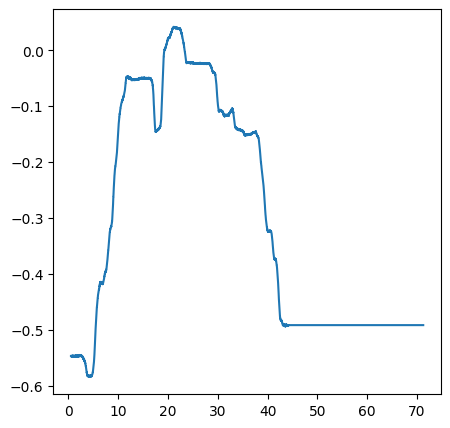

In [ ]:
smooth_losses = [0]
losses = []
loss_checkpoint = 1000
loss_inform_checkpoint = 10000
plot_checkpoint = 50000
validation_checkpoint = 1000
validation_error = 9999999
min_loss = 100

print("INTERVAL 1")

val_observation = torch.zeros(2, 1, d_x+d_y, device=device)
nof_val_trajs = x_val.shape[0]

print("INTERVAL 2")


for step in range(50000000):
    print("Step:", step)
    observations, target_t, target_output = get_training_sample()
    
    optimizer.zero_grad()
    output = model(observations, target_t)
    loss = log_prob_loss_mul(output, target_output)
    loss.backward()
    optimizer.step()
    
    if loss.data < min_loss:
        min_loss = loss
        print(f'Loss: {loss.data}')
    
    if step % loss_inform_checkpoint == 0:
        print(f'Step: {step} ')
    
    if step % loss_checkpoint == 0:
        losses.append(loss.data.cpu())
        smooth_losses[-1] += loss.data.cpu()/(plot_checkpoint/loss_checkpoint)
    
    if step % validation_checkpoint == 0:
        current_error = 0
        val_traj_ids = np.random.permutation(nof_val_trajs)  # changing validation order, shouldn't make a diff
        for i in val_traj_ids:
            val_observation[0] = val_observation[1] = torch.cat((x_val[i, 0], y_val[i, 0]))
            y_pred, std_pred = predict_model_val(val_observation, x_val[i], y_val[i], plot=False, step=-1)
            current_error += torch.mean((y_pred - y_val[i, :])**2) / nof_val_trajs
        if current_error < validation_error:
            validation_error = current_error
            torch.save(model.state_dict(), f'{path_prefix}cnmp_best_validation.h5')
            if not step % plot_checkpoint == 0:
                print(f'Step: {step}. New validation best. Error: {current_error}')
            else:
                print(f'Step: {step}. New validation best.', end=' ')
        
    if step % plot_checkpoint == 0:
        print(f'Plotting... Error: {current_error}')
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.title('Train Loss')
        plt.plot(range(len(losses)),losses)
        plt.subplot(122)
        plt.title('Train Loss (Smoothed)')
        plt.plot(range(len(smooth_losses)), smooth_losses)
        plt.savefig(f'{path_prefix}{step}.png')
        plt.close()
        
        val_traj_ids = np.random.permutation(nof_val_trajs)  # changing validation order, shouldn't make a diff
        #plotting validation cases
        for i in val_traj_ids:
            val_observation[0] = val_observation[1] = torch.cat((x_val[i, 0], y_val[i, 0]))
            predict_model_val(val_observation, x_val[i], y_val[i], plot=True, step=step, val_id=i)
        
        if step!=0:
            smooth_losses.append(0)
print('Finished Training')

In [ ]:
model = LWCNMP((d_x, d_y)).to(device)
model.load_state_dict(torch.load(f'{path_prefix}cnmp_best_validation.h5'))

test_observation = torch.zeros(2, 2, d_x+d_y, device=device)
test_observation[0] = test_observation[1] = torch.hstack((torch.Tensor([[0.], [1]]).to(device), torch.Tensor([[1], [1]]).to(device)))
# test_observation = torch.zeros(1, 1, d_x+d_y, device=device)
# test_observation[0] = torch.cat((torch.Tensor([0.5]).to(device), torch.Tensor([0.5]).to(device)))
p, s = predict_model_val(test_observation, x_val[0], y_val[0], plot=True, step=-2)
print('Finished predicting')

In [ ]:
print(p)

In [ ]:
print(s)